In [410]:
!pip install lightgbm


In [411]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p
import warnings

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor

warnings.filterwarnings("ignore") 

In [412]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [413]:
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [414]:
test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6    2010        WD         Normal  
1   12500      6    2010        WD         Normal  
2       0      3    2010        WD         Normal  
3       0      6    2010        WD         Normal  
4       0      1    2010        WD         Normal  

[5 rows x 80 columns]

In [415]:
test["SalePrice"] = np.nan # we don't have target values for the test

#### Splitting the variables in different categories

In [416]:
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']

num_continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                  '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

cat_ordinal = ['LotShape','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir',
               'Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
               'PavedDrive','PoolQC','Fence']

cat_nominal = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','Foundation','Heating','GarageType','MiscFeature',
               'SaleType','SaleCondition']

#### Removing Outliers<br>
We can define as outliers all the values with z score > 3 or z score < 3. The number of outliers of the features with, at least, weak correlation with Sale Price and a low % of zeros will be presented. Then, the scatterplots of the variables will be plotted to detect the outliers with Low Price.

In [417]:
def z_score(df): 
    return (df-df.mean())/df.std(ddof=0)

In [418]:
# Let's take a look at the number of outliers of the variables with correlation > 0.3 and % of zeros < 30%

idx = []
outliers = []
corrs = []
zeros = []

for i in num_continuous:
    if str(train[i].dtype) != 'object':
        idx.append(i)
        outliers.append(list(abs(z_score(train[i])) > 3).count(True))
        corrs.append(train.SalePrice.corr(train[i]))
        zeros.append(len(train[i][train[i] == 0])/len(train[i]))
        
outs = pd.DataFrame({'# Outliers': outliers, 
                     'Feature': idx, 
                     'Corr': corrs, 
                     '% Zeros': zeros}).sort_values(ascending = False, 
                                                 by = '# Outliers')

outs = outs[outs["# Outliers"] > 0]
outs = outs[abs(outs["Corr"]) > 0.3].reset_index(drop=True)
outs = outs[outs["% Zeros"] < 0.3].reset_index(drop=True)
outs

# Outliers      Feature      Corr   % Zeros
0          22    SalePrice  1.000000  0.000000
1          16    GrLivArea  0.708624  0.000000
2          12     1stFlrSF  0.605852  0.000000
3          12  LotFrontage  0.351799  0.000000
4          10  TotalBsmtSF  0.613581  0.025342
5           7   GarageArea  0.623431  0.055479

In [419]:
# defining a function to plot the correlation of the variables shown above with SalePrice, so we can delete Low Price's outliers

def plot_outliers():
    
    fig = plt.figure(figsize=(15,15), constrained_layout=True)

    gs = GridSpec(3,2,figure=fig)

    rows = [0,0,1,1,2,2]
    columns = [0,1,0,1,0,1]

    colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

    counter = 0

    for i in outs.Feature:
        sns.scatterplot(y=train.SalePrice, x=train[i], 
                      ax=fig.add_subplot(gs[rows[counter],columns[counter]]),
                      color=colors[counter])
        counter = counter + 1

    fig.show()

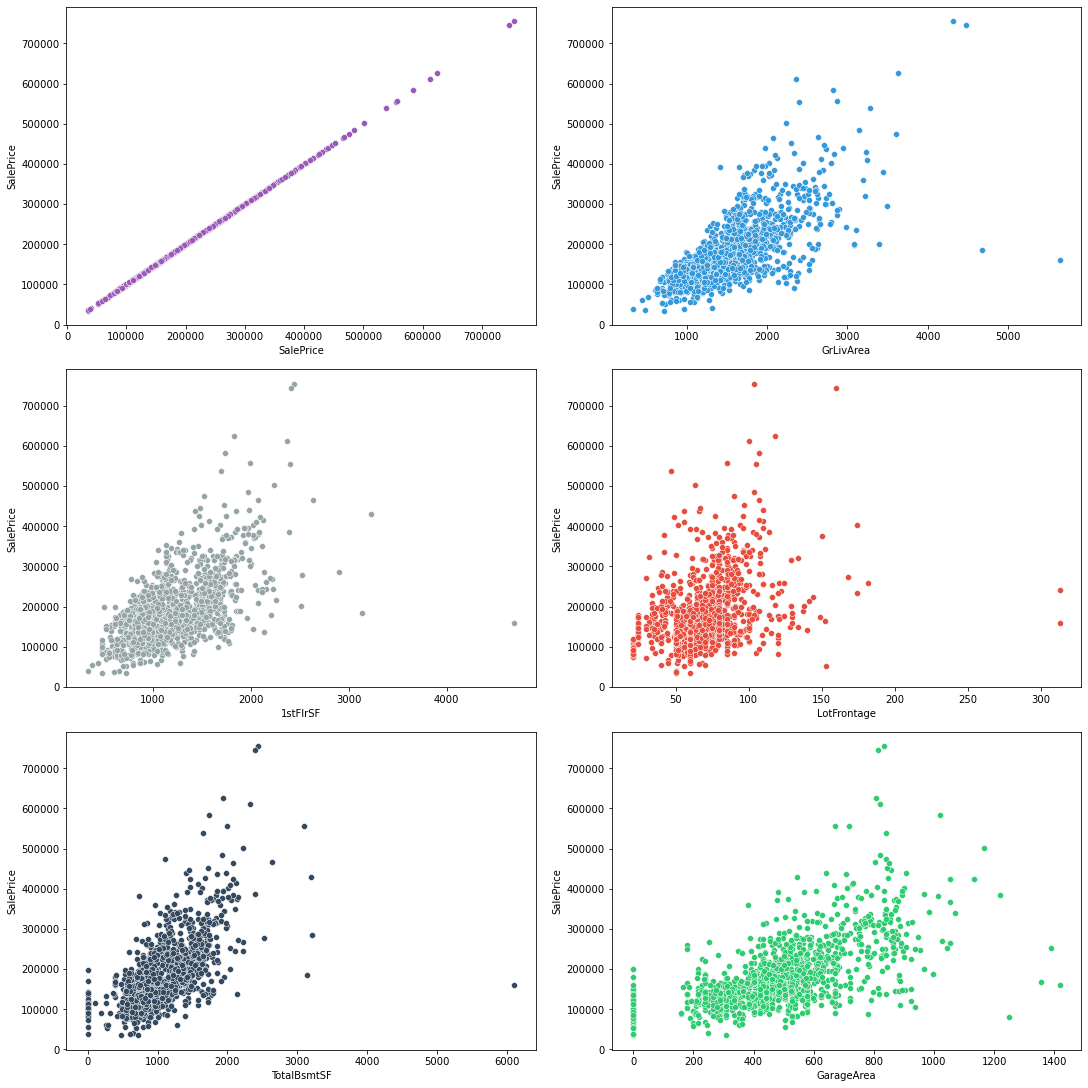

In [420]:
plot_outliers()

There are two outliers with low price for GrLivArea

In [421]:
train = train.drop(train[(train['LotFrontage'] > 300) & (train['SalePrice'] < 300000)].index)

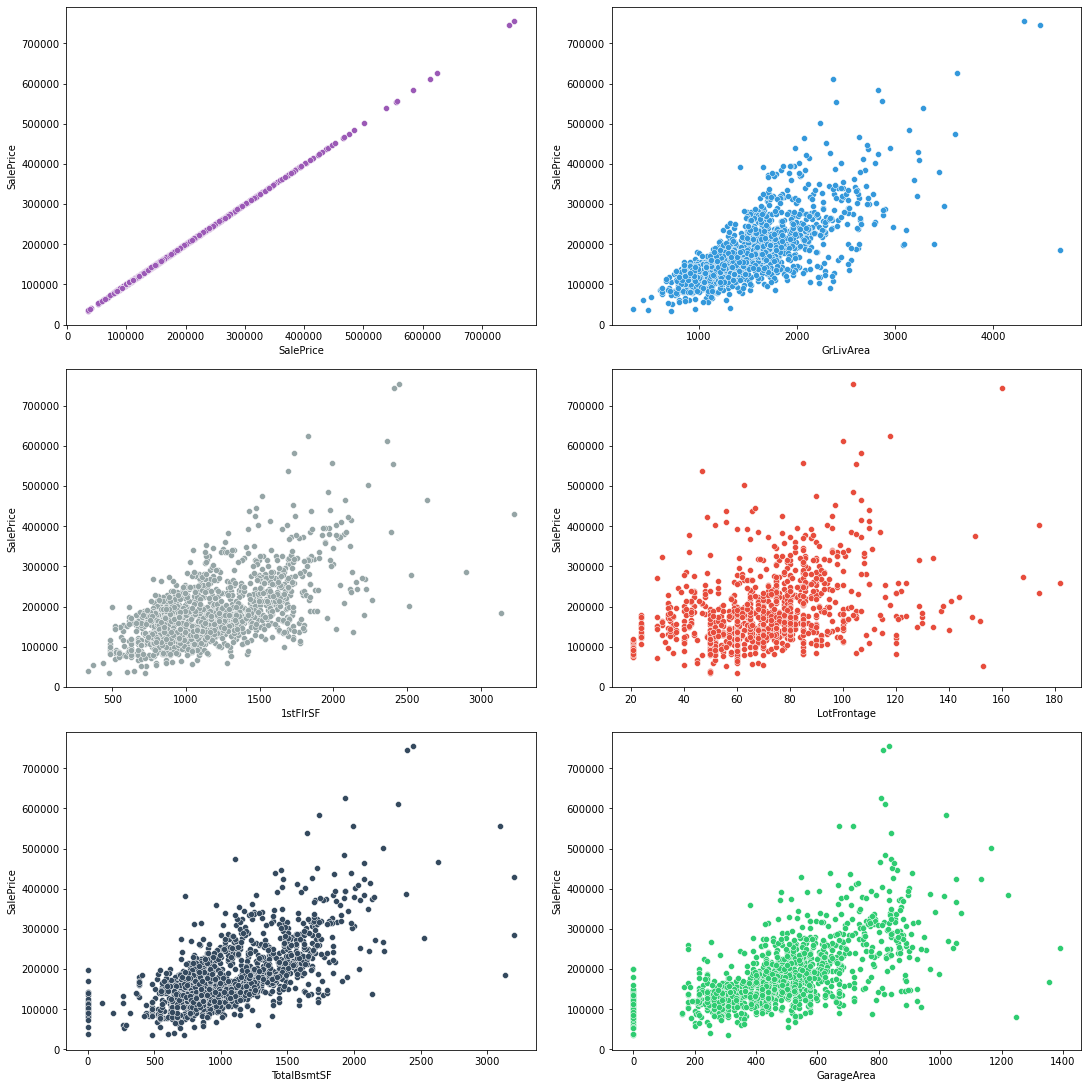

In [422]:
plot_outliers()

In [423]:
# concatenate train and test sets
dataset = pd.concat([train,test],axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

#### Handeling Null values

In [424]:
# defining a function to map the # and % of NaN's for the features
def show_null(df):
    null_columns = (df.isnull().sum(axis = 0)/len(df)).sort_values(ascending=False).index
    null_data = pd.concat([df.isnull().sum(axis = 0),
                           (df.isnull().sum(axis = 0)/len(df)).sort_values(ascending=False),
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes]
                          , axis=1)
    null_data = null_data.rename(columns={0: '#', 
                                          1: '% null', 
                                          2: 'type'}).sort_values(ascending=False, by = '% null')
    null_data = null_data[null_data["#"]!=0]
    return null_data

show_null(dataset)

#    % null     type
PoolQC        2908  0.996915   object
MiscFeature   2812  0.964004   object
Alley         2719  0.932122   object
Fence         2346  0.804251   object
SalePrice     1459  0.500171  float64
FireplaceQu   1420  0.486802   object
LotFrontage    486  0.166610  float64
GarageFinish   159  0.054508   object
GarageQual     159  0.054508   object
GarageCond     159  0.054508   object
GarageYrBlt    159  0.054508  float64
GarageType     157  0.053822   object
BsmtExposure    82  0.028111   object
BsmtCond        82  0.028111   object
BsmtQual        81  0.027768   object
BsmtFinType2    80  0.027425   object
BsmtFinType1    79  0.027083   object
MasVnrType      24  0.008228   object
MasVnrArea      23  0.007885  float64
MSZoning         4  0.001371   object
Functional       2  0.000686   object
BsmtHalfBath     2  0.000686  float64
BsmtFullBath     2  0.000686  float64
Utilities        2  0.000686   object
BsmtFinSF1       1  0.000343  float64
BsmtFinSF2       1  0.000343  float64
SaleType         1  0.000343   object
Electrical       1  0.000343   object
GarageCars       1  0.000343  float64
TotalBsmtSF      1  0.000343  float64
GarageArea       1  0.000343  float64
Exterior2nd      1  0.000343   object
Exterior1st      1  0.000343   object
KitchenQual      1  0.000343   object
BsmtUnfSF        1  0.000343  float64

In [425]:
# Ordinals - Replacing NaN's

dataset.PoolQC[dataset.PoolQC.isnull() == True] = 'NA'
dataset.Fence[dataset.Fence.isnull() == True] = 'NA'
dataset.FireplaceQu[dataset.FireplaceQu.isnull() == True] = 'NA'
dataset.GarageCond[dataset.GarageCond.isnull() == True] = 'NA'
dataset.GarageQual[dataset.GarageQual.isnull() == True] = 'NA'
dataset.GarageFinish[dataset.GarageFinish.isnull() == True] = 'NA'
dataset.BsmtExposure[dataset.BsmtExposure.isnull() == True] = 'NA'
dataset.BsmtCond[dataset.BsmtCond.isnull() == True] = 'NA'
dataset.BsmtQual[dataset.BsmtQual.isnull() == True] = 'NA'
dataset.BsmtFinType2[dataset.BsmtFinType2.isnull() == True] = 'NA'
dataset.BsmtFinType1[dataset.BsmtFinType1.isnull() == True] = 'NA'
dataset.Electrical[dataset.Electrical.isnull() == True] = stats.mode(train.Electrical)[0][0]
dataset.Functional[dataset.Functional.isnull() == True] = stats.mode(train.Functional)[0][0]
dataset.KitchenQual[dataset.KitchenQual.isnull() == True] = stats.mode(train.KitchenQual)[0][0]
dataset.Utilities[dataset.Utilities.isnull() == True] = stats.mode(train.Utilities)[0][0]

In [426]:
# Nominals - Replacing NaN's

dataset.MiscFeature[dataset.MiscFeature.isnull() == True] = 'NA'
dataset.Alley[dataset.Alley.isnull() == True] = 'NA'
dataset.GarageType[dataset.GarageType.isnull() == True] = 'NA'
dataset.MasVnrType[dataset.MasVnrType.isnull() == True] = 'NA'
dataset.MSZoning[dataset.MSZoning.isnull() == True] = stats.mode(train.MSZoning)[0][0]
dataset.SaleType[dataset.SaleType.isnull() == True] = stats.mode(train.SaleType)[0][0]
dataset.Exterior1st[dataset.Exterior1st.isnull() == True] = stats.mode(train.Exterior1st)[0][0]
dataset.Exterior2nd[dataset.Exterior2nd.isnull() == True] = stats.mode(train.Exterior2nd)[0][0]

In [427]:
# Some Numericals - Replacing NaN's

dataset.BsmtFullBath[dataset.BsmtFullBath.isnull() == True] = stats.mode(train.BsmtFullBath)[0][0]
dataset.BsmtHalfBath[dataset.BsmtHalfBath.isnull() == True] = stats.mode(train.BsmtHalfBath)[0][0]
dataset.GarageCars[dataset.GarageCars.isnull() == True] = stats.mode(train.GarageCars)[0][0]
dataset.GarageArea[dataset.GarageArea.isnull() == True] = np.median(train.
                                                                    GarageArea[train.GarageArea.isnull() == False])
dataset.TotalBsmtSF[dataset.TotalBsmtSF.isnull() == True] = np.median(train.
                                                                      TotalBsmtSF[train.TotalBsmtSF.isnull() == False])
dataset.BsmtFinSF1[dataset.BsmtFinSF1.isnull() == True] = np.median(train.
                                                                    BsmtFinSF1[train.BsmtFinSF1.isnull() == False])
dataset.BsmtFinSF2[dataset.BsmtFinSF2.isnull() == True] = np.median(train.
                                                                    BsmtFinSF2[train.BsmtFinSF2.isnull() == False])
dataset.BsmtUnfSF[dataset.BsmtUnfSF.isnull() == True] = np.median(train.
                                                                  BsmtUnfSF[train.BsmtUnfSF.isnull() == False])
dataset.LotFrontage[dataset.LotFrontage.isnull() == True] = np.median(train.
                                                                    LotFrontage[train.LotFrontage.isnull() == False])

In [428]:
#Special Cases
# MasVnrArea

dataset[dataset.MasVnrArea.isnull() == True].MasVnrType

234     NA
529     NA
650     NA
935     NA
972     NA
976     NA
1242    NA
1277    NA
1689    NA
1704    NA
1880    NA
1990    NA
2002    NA
2039    NA
2309    NA
2323    NA
2338    NA
2347    NA
2366    NA
2590    NA
2655    NA
2684    NA
2860    NA
Name: MasVnrType, dtype: object

for MasVnrArea, but the NaN values happen just because there is no Masonry veener. Therefore we can define them as 0.

In [429]:
dataset.MasVnrArea[dataset.MasVnrArea.isnull() == True] = 0

In [430]:
# GarageYrBlt

dataset[["GarageType",
          "GarageFinish",
          "GarageQual",
          "GarageCond",
         "GarageYrBlt"]][dataset.GarageYrBlt.isnull() == True].dropna()

Empty DataFrame
Columns: [GarageType, GarageFinish, GarageQual, GarageCond, GarageYrBlt]
Index: []

In [431]:
dataset.GarageYrBlt[dataset.GarageYrBlt.isnull() == True] = 'NA'

In [432]:
# Let's see again the # and % of NaN's 
show_null(dataset)


#    % null     type
SalePrice  1459  0.500171  float64

## Data Preprocessing and EDA

In [433]:
# Discrete Variables
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']
 

In [434]:
# defining a function to plot boxplot and stripplot for non continuous variables
def make_discrete_plot(feature, rotation1, rotation2):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=dataset.SalePrice, x=dataset[feature], ax=fig.add_subplot(gs[0,0]))
    plt.xticks(rotation = rotation1)
    sns.stripplot(y=dataset.SalePrice, x=dataset[feature], ax=fig.add_subplot(gs[0,1]))
    plt.xticks(rotation = rotation2)
    fig.show()

In [435]:
#BsmtFullBath, BsmtHalfBath, FullBath, HalfBath
# these variables tell alomist the same information, hence, adding them 
#Number of Bathrooms

dataset["Baths"] = dataset.BsmtFullBath + 0.5*dataset.BsmtHalfBath + dataset.FullBath + 0.5*dataset.HalfBath

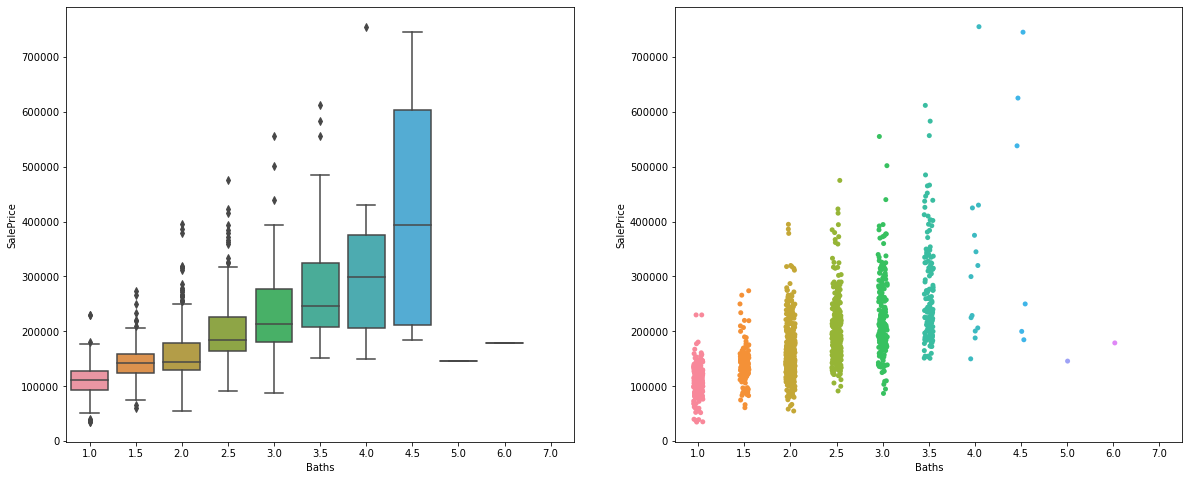

In [436]:
make_discrete_plot("Baths",0,0)

In [437]:
# there few values greater than 4, so let's put them together with 3.5
dataset.Baths = dataset.Baths.apply(lambda x: 3.5 if x > 3.5 else x)

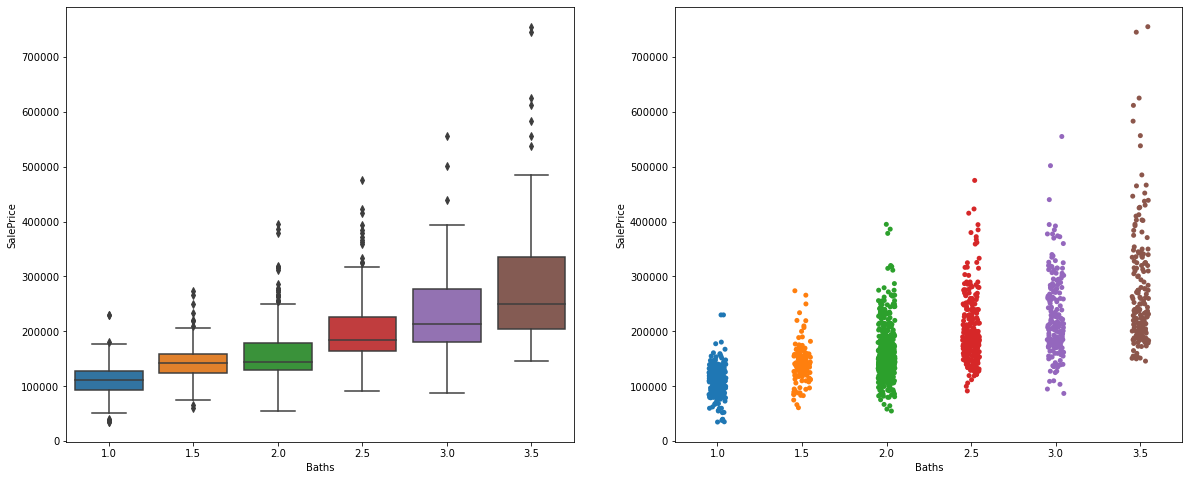

In [438]:
make_discrete_plot("Baths",0,0)

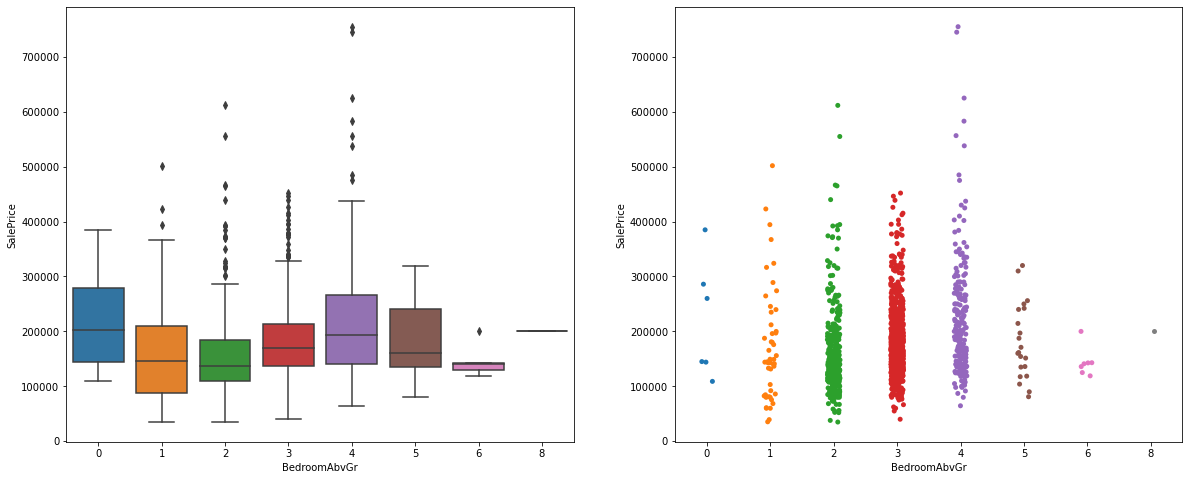

In [439]:
# Bedrooms above grade
make_discrete_plot("BedroomAbvGr",0,0)

In [440]:
# there few values greater than 5, so let's put them together with 5
dataset.BedroomAbvGr = dataset.BedroomAbvGr.apply(lambda x: 5 if x > 5 else x)

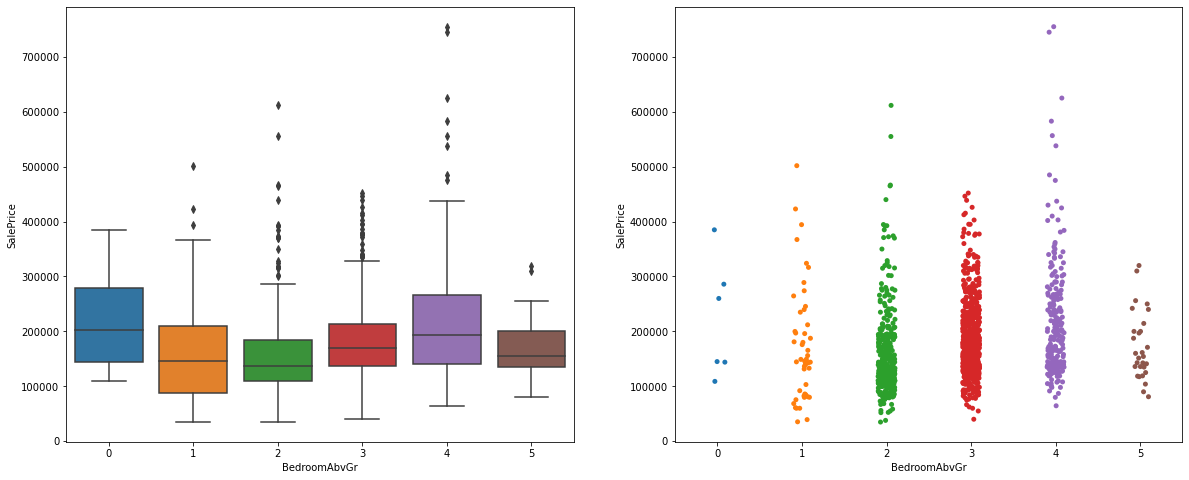

In [441]:
make_discrete_plot("BedroomAbvGr",0,0)


In [442]:
# change type to category
dataset.BedroomAbvGr = dataset.BedroomAbvGr.astype(str)

Kitchens above grade

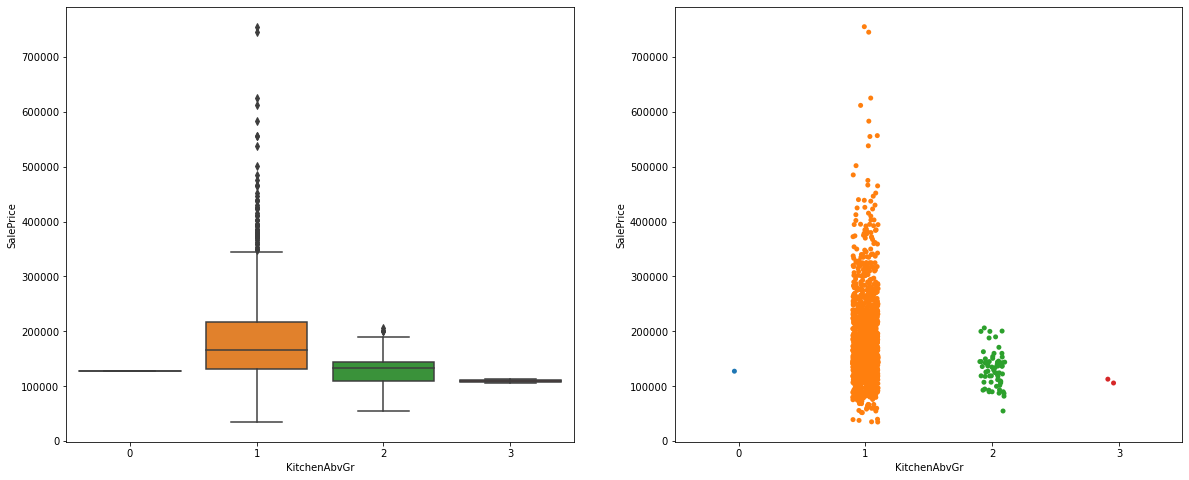

In [443]:
make_discrete_plot("KitchenAbvGr",0,0)

In [444]:
# there few values equal to 0 or 3, so let's put them together with other classes
dataset.KitchenAbvGr = dataset.KitchenAbvGr.apply(lambda x: 1 if x==0 else(2 if x==3 else x))

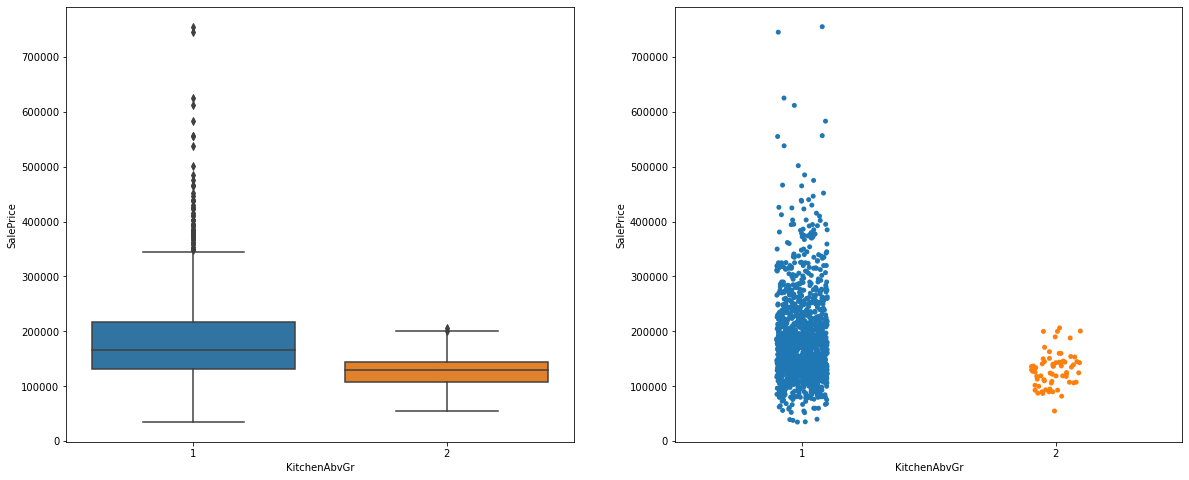

In [445]:
make_discrete_plot("KitchenAbvGr",0,0)

In [446]:
# change type to category
dataset.KitchenAbvGr = dataset.KitchenAbvGr.astype(str)

Total rooms above grade (does not include bathrooms).

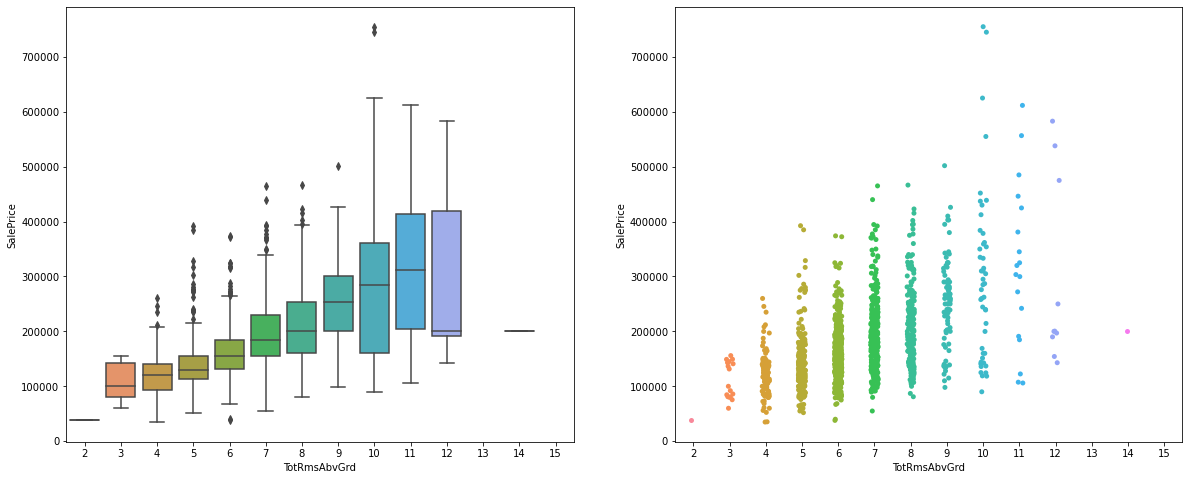

In [447]:
make_discrete_plot("TotRmsAbvGrd",0,0)

In [448]:
# there few values equal to 2 or greater than 11, so let's put them together with other classes
dataset.TotRmsAbvGrd = dataset.TotRmsAbvGrd.apply(lambda x: 3 if x==2 else(11 if x>11 else x))

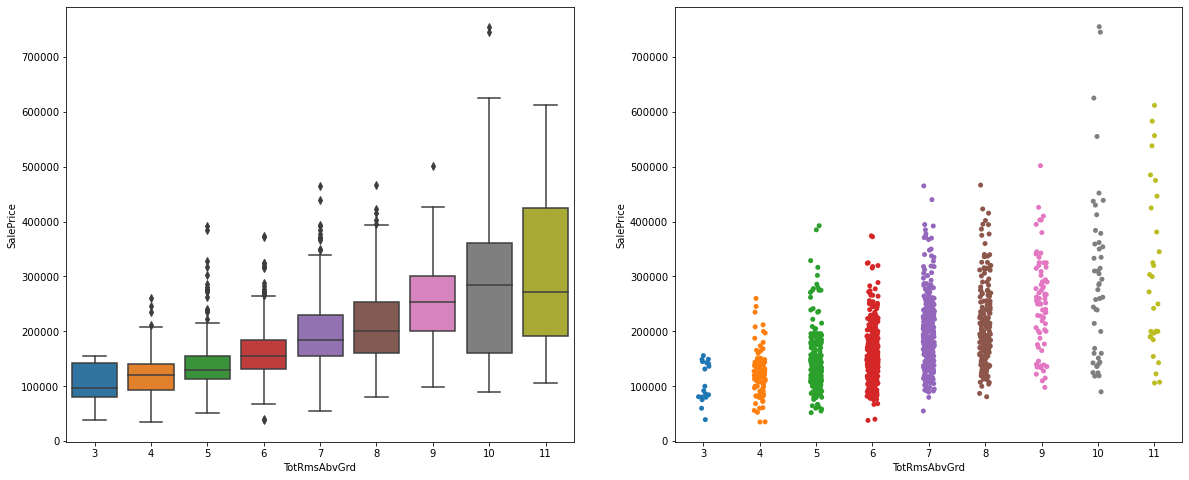

In [449]:
make_discrete_plot("TotRmsAbvGrd",0,0)

Number of fireplaces

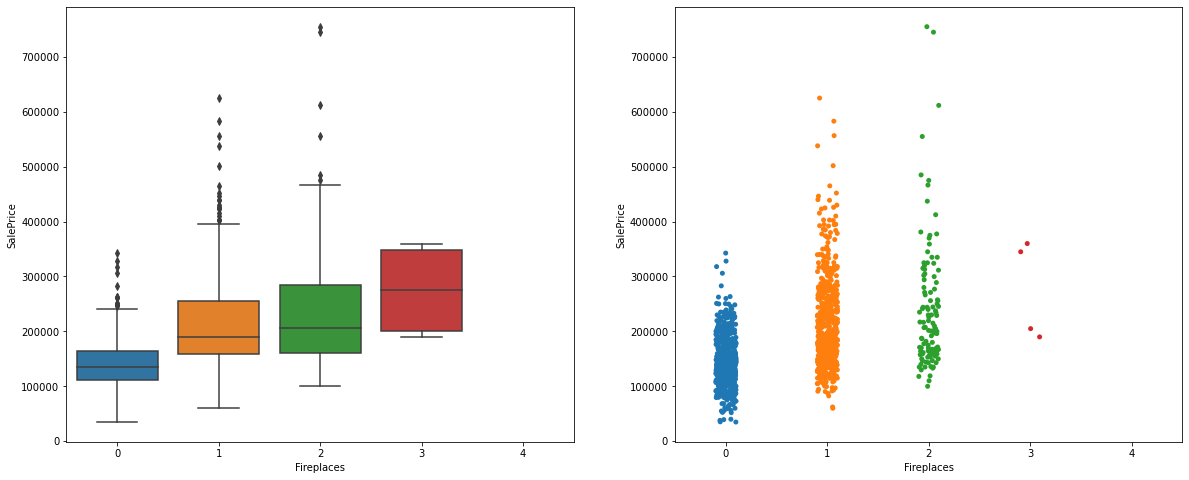

In [450]:
make_discrete_plot("Fireplaces",0,0)

In [451]:
# there few values greater than 2, so let's flag
dataset.Fireplaces = dataset.Fireplaces.apply(lambda x: 1 if x>1 else x)

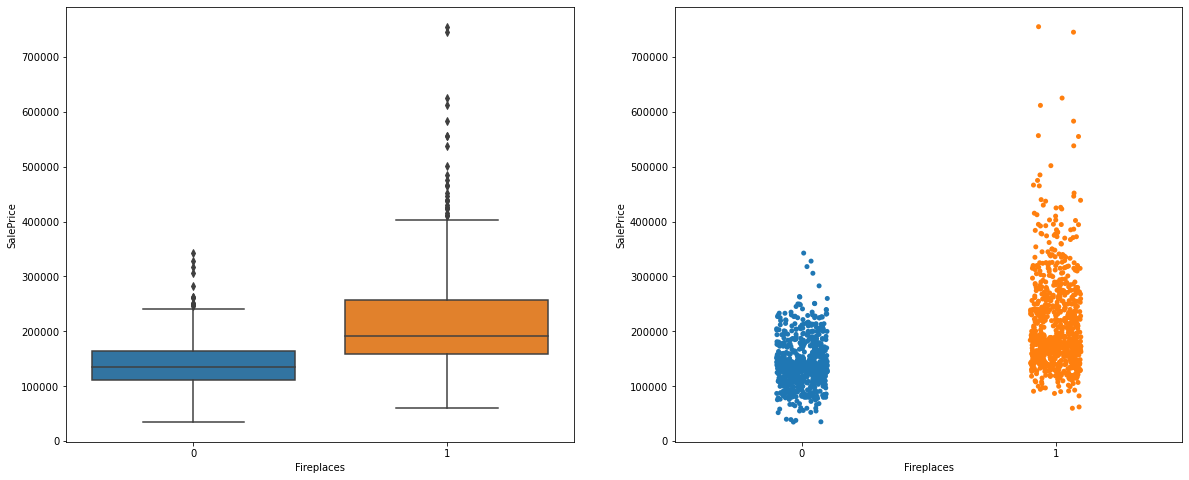

In [452]:
make_discrete_plot("Fireplaces",0,0)

size of garage in car capacity

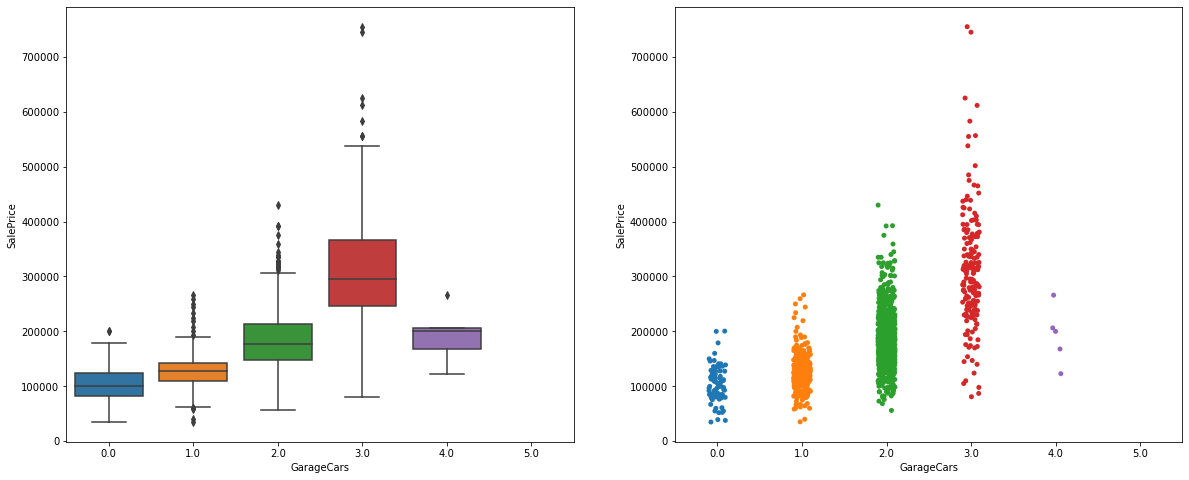

In [453]:
make_discrete_plot("GarageCars",0,0)

In [454]:
# there few values greater than 3, so let's put them together with other classes
dataset.GarageCars = dataset.GarageCars.apply(lambda x: 3 if x>3 else x)

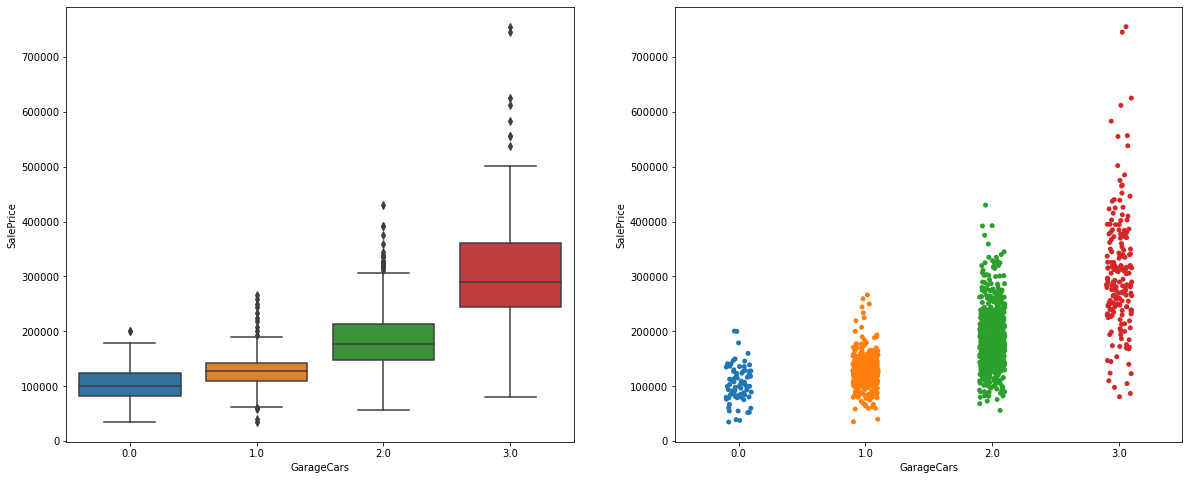

In [455]:
make_discrete_plot("GarageCars",0,0)

Year garage was built.

In [ ]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["GarageYrBlt"][dataset["GarageYrBlt"] != 'NA'])
plt.show()

In [457]:
dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'].sort_values(ascending= False).head(3) 

2590    2207.0
1500    2010.0
986     2010.0
Name: GarageYrBlt, dtype: object

In [458]:
dataset.GarageYrBlt[dataset.GarageYrBlt == 2207] = 2007

In [459]:
# Let's transform those values into categories
min(dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'].values)

1895.0

In [460]:
bins = [1890, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'] = pd.cut(dataset.GarageYrBlt[dataset["GarageYrBlt"] != 'NA'], 
                                                             bins, 
                                                             labels=names)

In [461]:
# change type from category to str
dataset.GarageYrBlt = dataset.GarageYrBlt.astype(str)

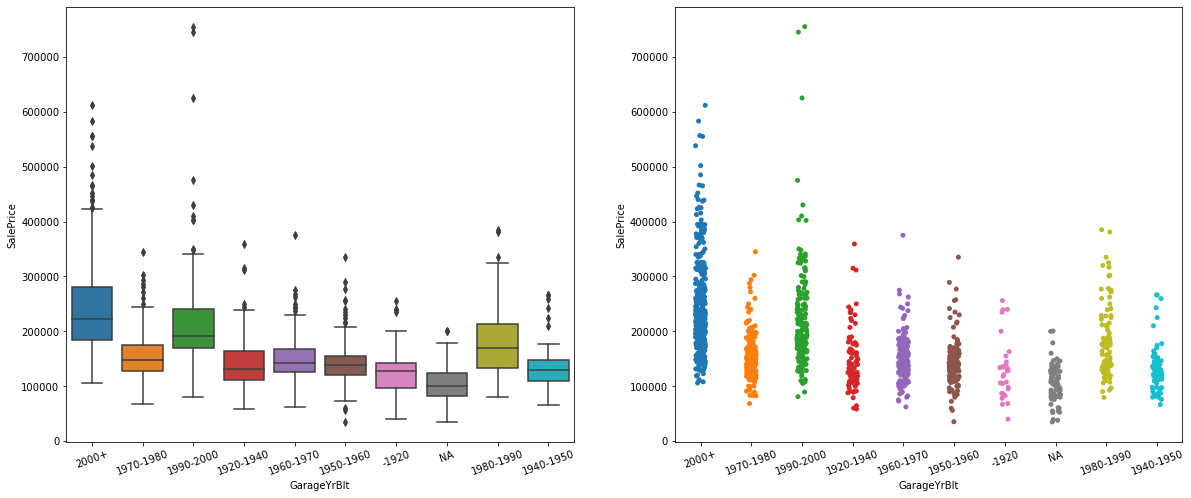

In [462]:
make_discrete_plot("GarageYrBlt",20,20)

Remodel date (same as construction date if no remodeling or additions).

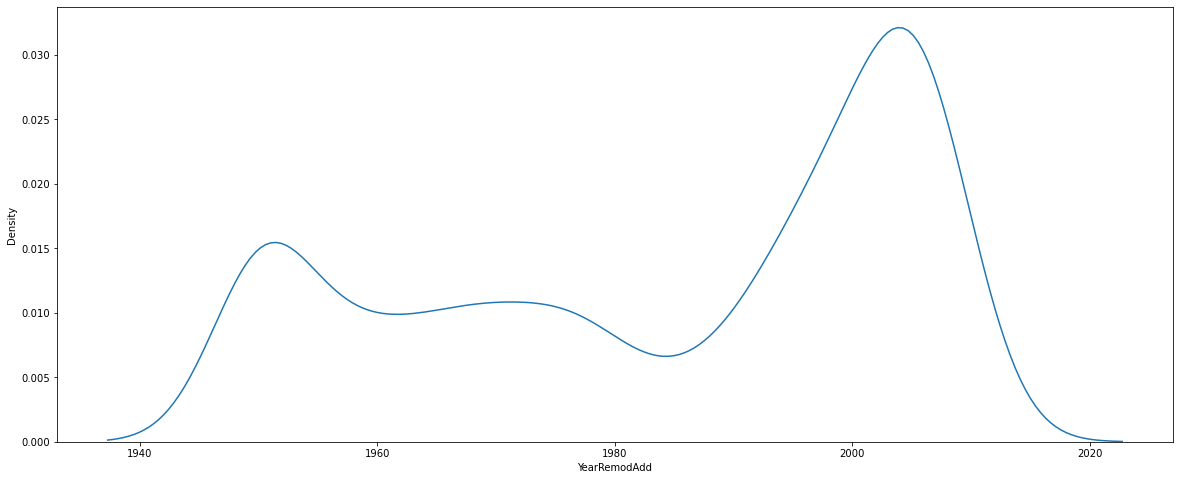

In [463]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["YearRemodAdd"])
plt.show()

In [464]:
# Let's transform those values into categories
print(min(dataset.YearRemodAdd[dataset["YearRemodAdd"] != 'NA'].values), ',',
      max(dataset.YearRemodAdd[dataset["YearRemodAdd"] != 'NA'].values))

1950 , 2010


In [465]:
bins = [1949, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['1950-1960', '1960-1970',
         '1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.YearRemodAdd = pd.cut(dataset.YearRemodAdd, bins, labels=names)

In [466]:
# change type from category to str
dataset.YearRemodAdd = dataset.YearRemodAdd.astype(str)

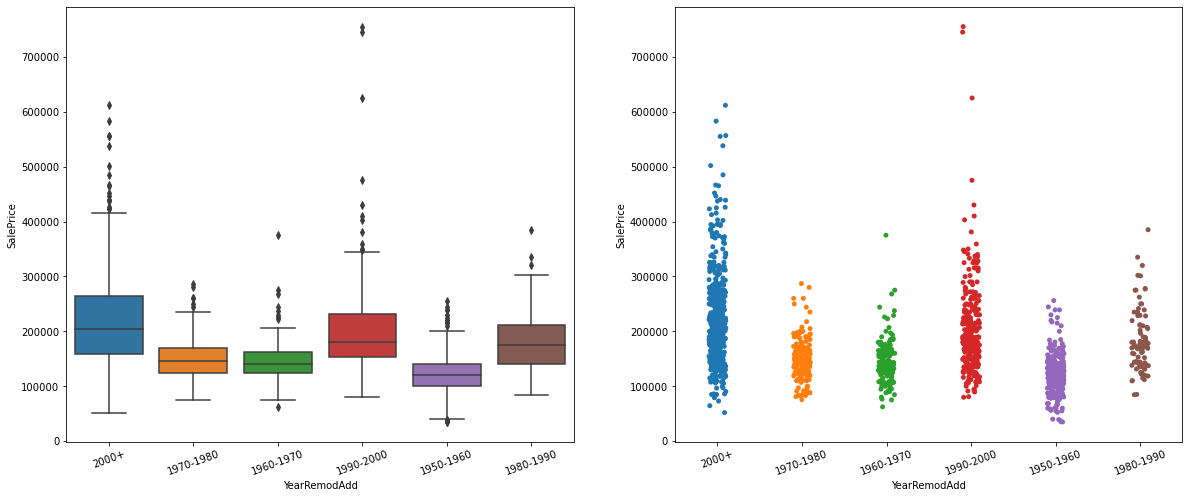

In [467]:
make_discrete_plot("YearRemodAdd",20,20)


original construction date

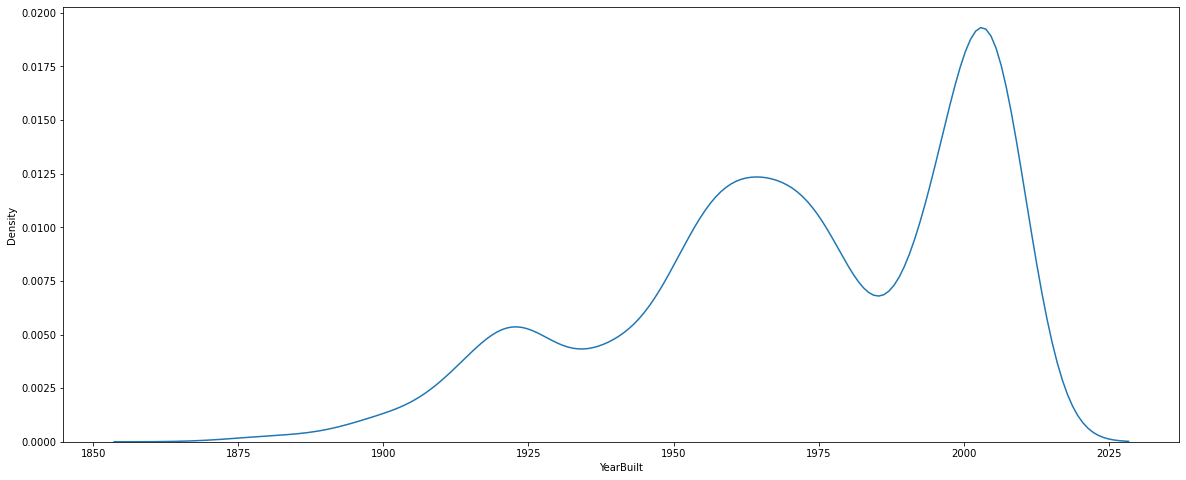

In [468]:
plt.figure(figsize=(20,8))
sns.kdeplot(dataset["YearBuilt"][dataset["YearBuilt"] != 'NA'])
plt.show()

In [469]:
# Let's transform those values into categories
#print(min(dataset.YearBuilt[dataset["YearBuilt"] != 'NA'].values), ',',
#      max(dataset.YearBuilt[dataset["YearBuilt"] != 'NA'].values))

In [470]:
!pip install pandas

In [471]:

bins = [1870, 1920, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2011]
names = ['-1920', '1920-1940', '1940-1950', '1950-1960', '1960-1970','1970-1980', '1980-1990', '1990-2000', '2000+']

dataset.YearBuilt = pd.cut(dataset.YearBuilt, bins, labels=names)

In [472]:
dataset.YearBuilt

0           2000+
1       1970-1980
2           2000+
3           -1920
4       1990-2000
          ...    
2912    1960-1970
2913    1960-1970
2914    1950-1960
2915    1990-2000
2916    1990-2000
Name: YearBuilt, Length: 2917, dtype: category
Categories (9, object): ['-1920' < '1920-1940' < '1940-1950' < '1950-1960' ... '1970-1980' < '1980-1990' < '1990-2000' < '2000+']

In [473]:
# change type from category to str
dataset.YearBuilt = dataset.YearBuilt.astype(str)

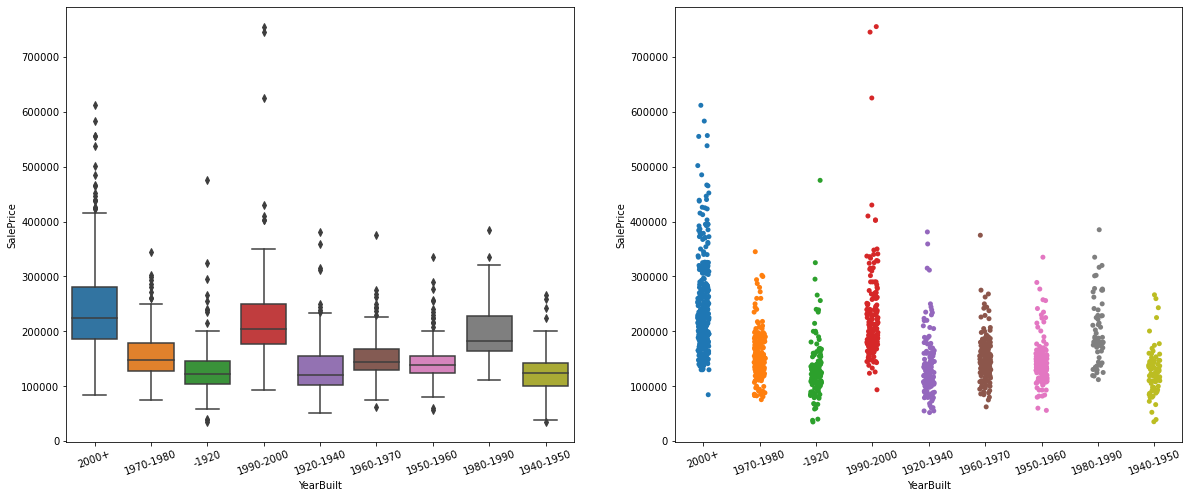

In [474]:
make_discrete_plot("YearBuilt",20,20)

Year Sold (YYYY).

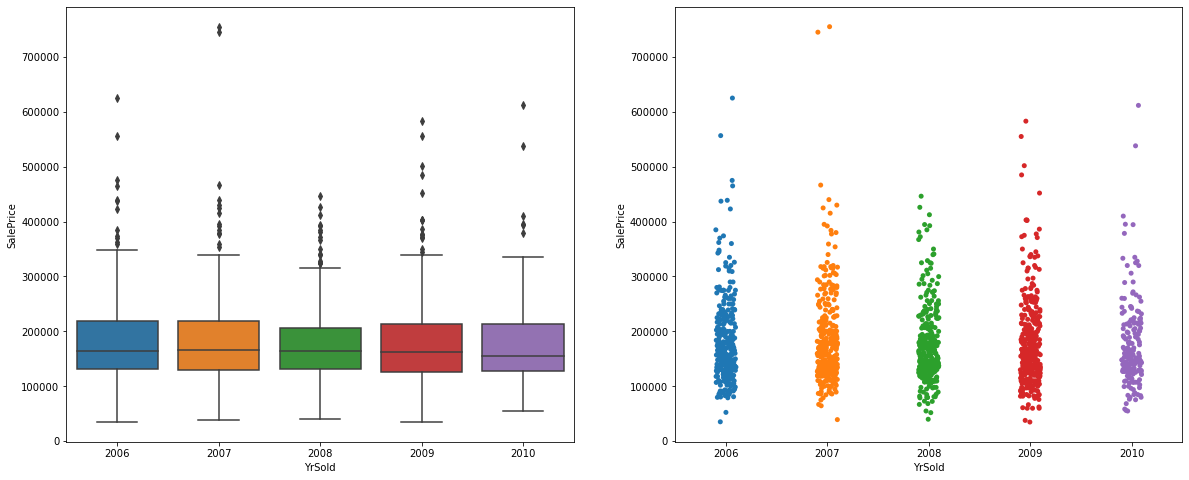

In [475]:
make_discrete_plot("YrSold",0,0)

In [476]:
# change type from int to str
dataset.YrSold = dataset.YrSold.astype(str)

Month Sold (MM).

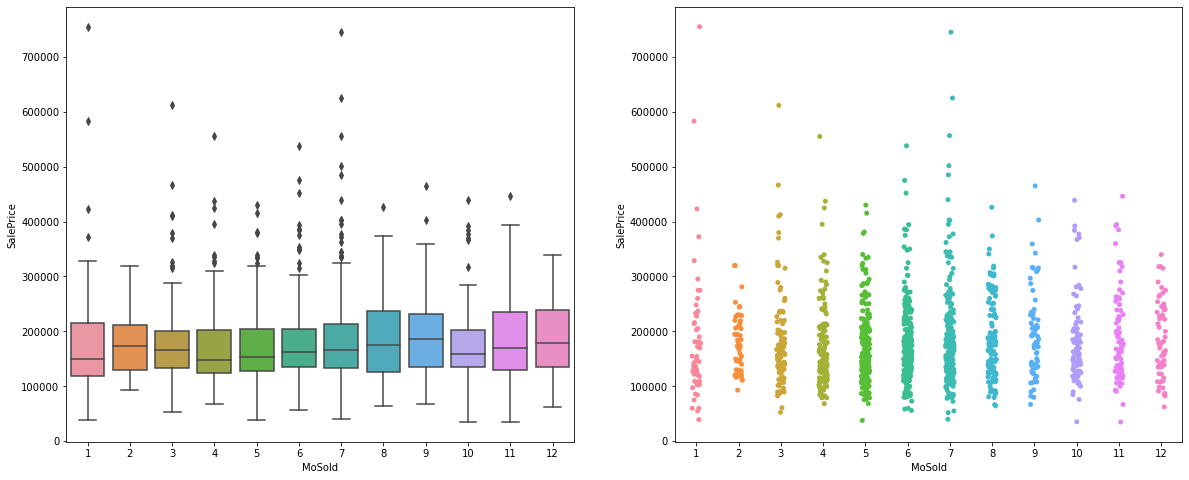

In [477]:
make_discrete_plot("MoSold",0,0)

In [478]:
# change type from int to str
dataset.MoSold = dataset.MoSold.astype(str)

## Continuous Variables

Here we are going to analyze correlation of each feature with SalePrice, see skewness for linear and boxcox transformations (with different lambdas) e apply the better one. If skewness continues high, we will bin the variable into categories or flag (0 and 1). And if there are missing values, we will drop the column.

In [479]:
# to remember
num_continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                  '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                  'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

In [480]:
# defining function to plot scatterplot for continuous variables with SalePrice.
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=np.log1p(dataset['SalePrice']), 
                        x=boxcox1p(dataset[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(np.log1p(dataset['SalePrice']).corr(boxcox1p(dataset[feature], 0.15)),2)) + ', Skew: ' +
               str(np.round(stats.skew(boxcox1p(dataset[feature], 0.15)),2)))
    
    j = sns.scatterplot(y=np.log1p(dataset['SalePrice']), 
                        x=boxcox1p(dataset[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(np.log1p(dataset['SalePrice']).corr(boxcox1p(dataset[feature], 0.25)),2)) + ', Skew: ' +
               str(np.round(stats.skew(boxcox1p(dataset[feature], 0.25)),2)))
    
    j = sns.scatterplot(y=np.log1p(dataset['SalePrice']), 
                        x=boxcox1p(dataset[feature], 0.35), ax=fig.add_subplot(gs[1,1]), palette = 'blue')

    plt.title('BoxCox 0.35\n' + 'Corr: ' + str(np.round(np.log1p(dataset['SalePrice']).corr(boxcox1p(dataset[feature], 0.35)),2)) + ', Skew: ' +
               str(np.round(stats.skew(boxcox1p(dataset[feature], 0.35)),2)))
    
    j = sns.scatterplot(y=np.log1p(dataset['SalePrice']), 
                        x=dataset[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(np.log1p(dataset['SalePrice']).corr(dataset[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(dataset[feature]),2)))
    
    fig.show()

Linear feet of street connected to property.

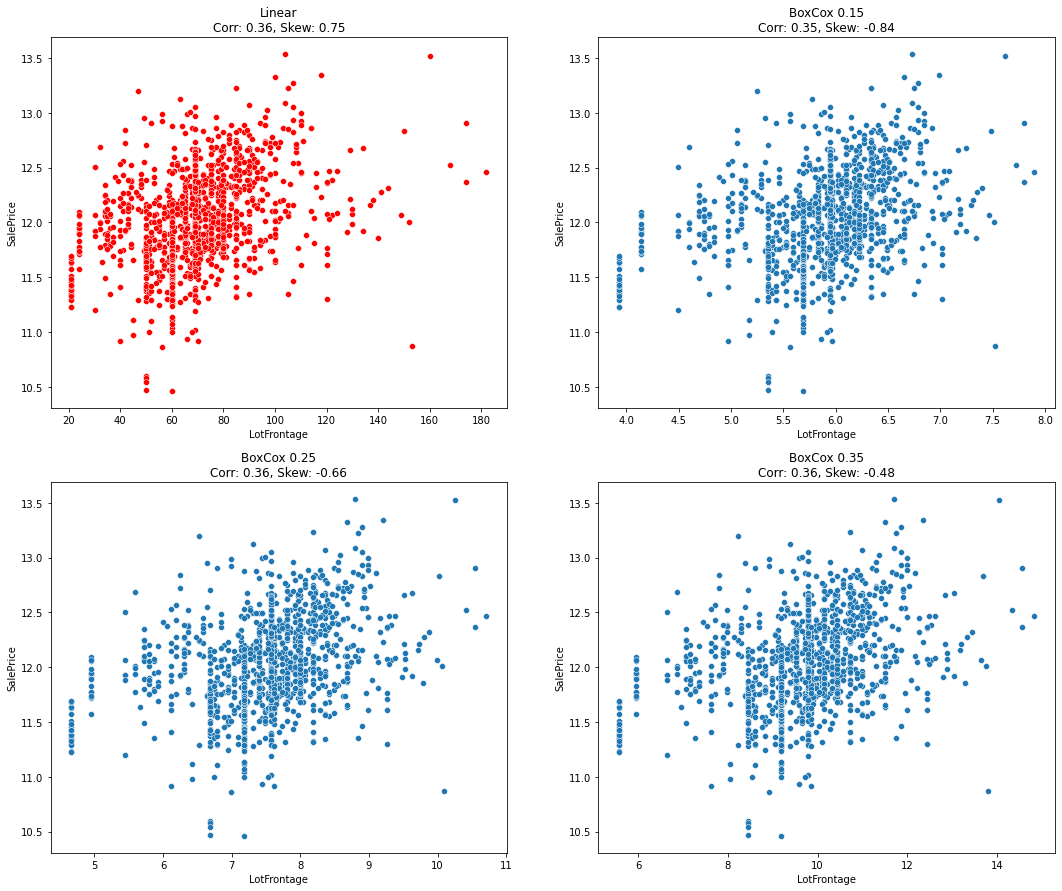

In [481]:
make_continuous_plot('LotFrontage')


In [482]:
dataset.LotFrontage = boxcox1p(dataset.LotFrontage, 0.35)

Area of the Lot

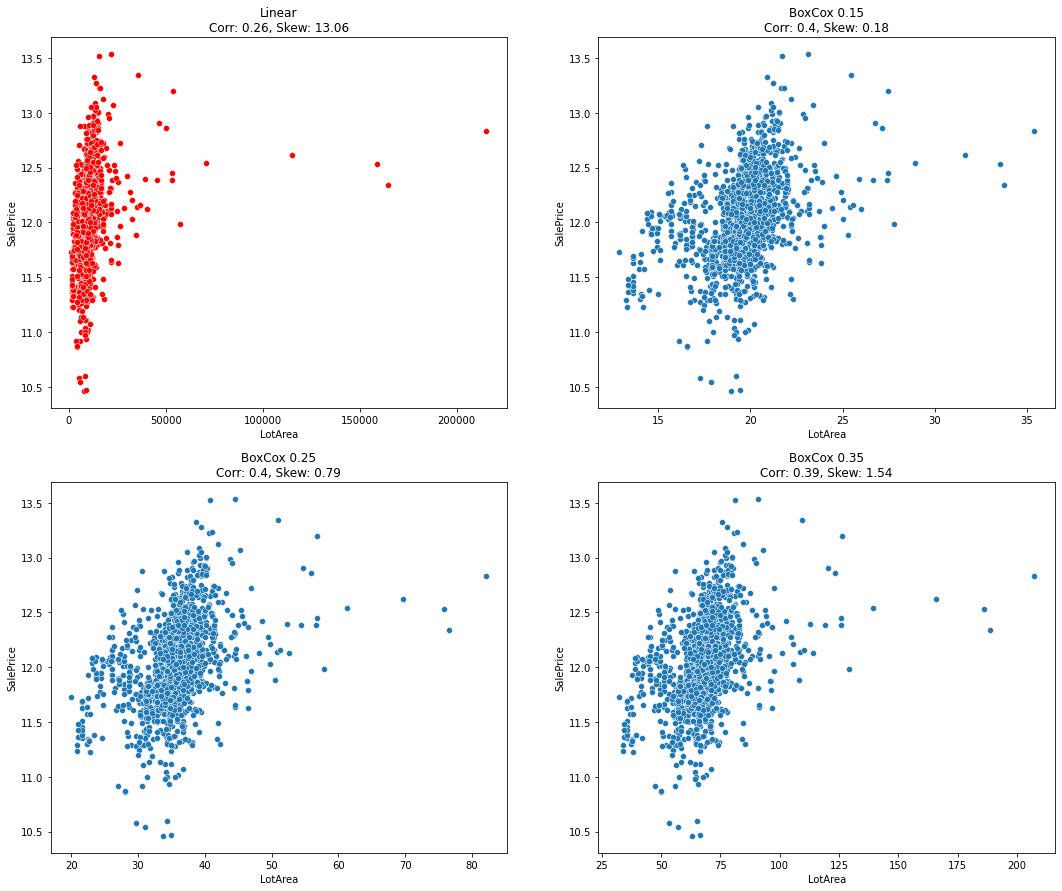

In [483]:
make_continuous_plot('LotArea')

In [484]:
dataset.LotArea = boxcox1p(dataset.LotArea, 0.15)

Masonry veneer area in square feet.

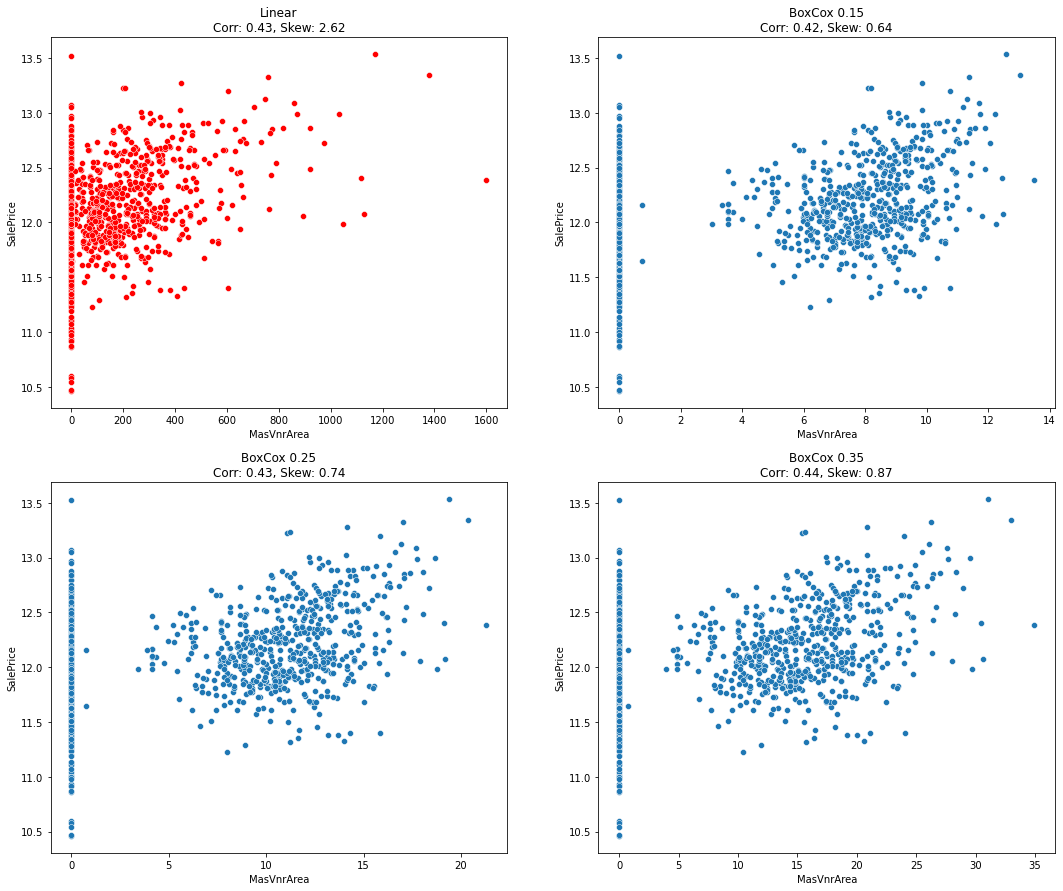

In [485]:
make_continuous_plot('MasVnrArea')

In [486]:
dataset.MasVnrArea = boxcox1p(dataset.MasVnrArea, 0.15)

Types 1 and 2 finished square feet

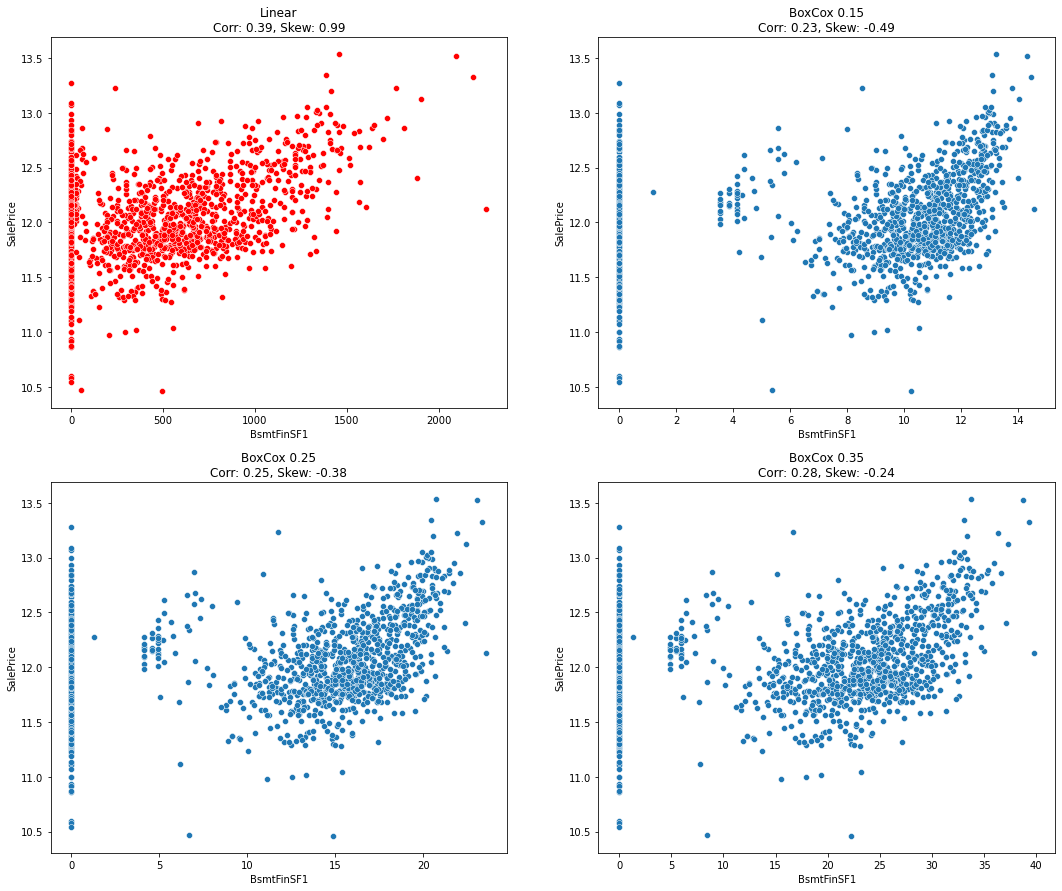

In [487]:
make_continuous_plot('BsmtFinSF1')

In [488]:
# Let's transform those values into categories, because with boxcox 0.35 the correlation decreases a lot
print(min(dataset.BsmtFinSF1.values), ',',
      max(dataset.BsmtFinSF1.values))

0.0 , 4010.0


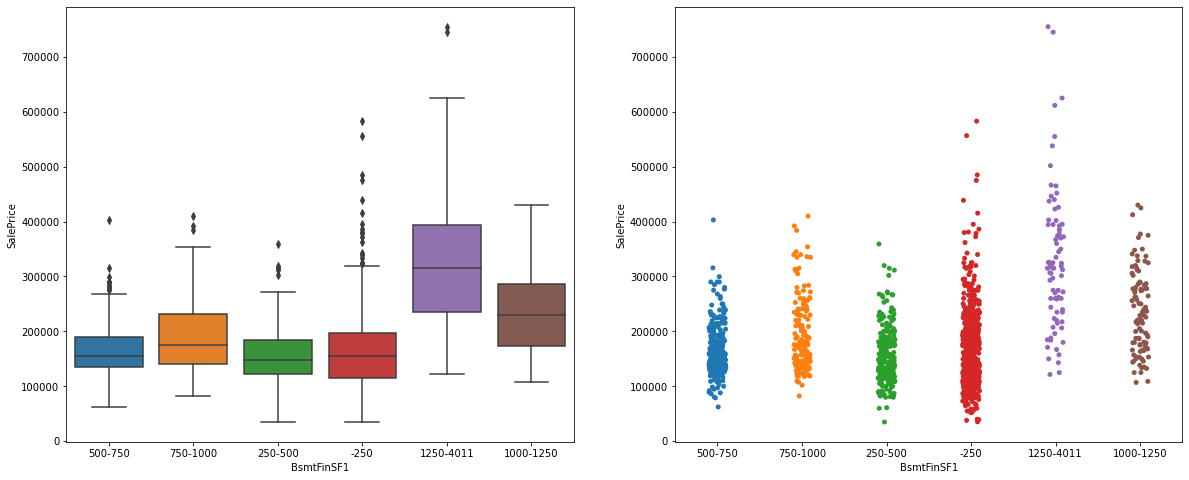

In [489]:
bins = [-1, 250, 500, 750, 1000, 1250, 4011]
names = ['-250', '250-500', '500-750', '750-1000',
         '1000-1250', '1250-4011']

dataset.BsmtFinSF1 = pd.cut(dataset.BsmtFinSF1, bins, labels=names)
# change type from category to str
dataset.BsmtFinSF1 = dataset.BsmtFinSF1.astype(str)
make_discrete_plot('BsmtFinSF1',0,0)

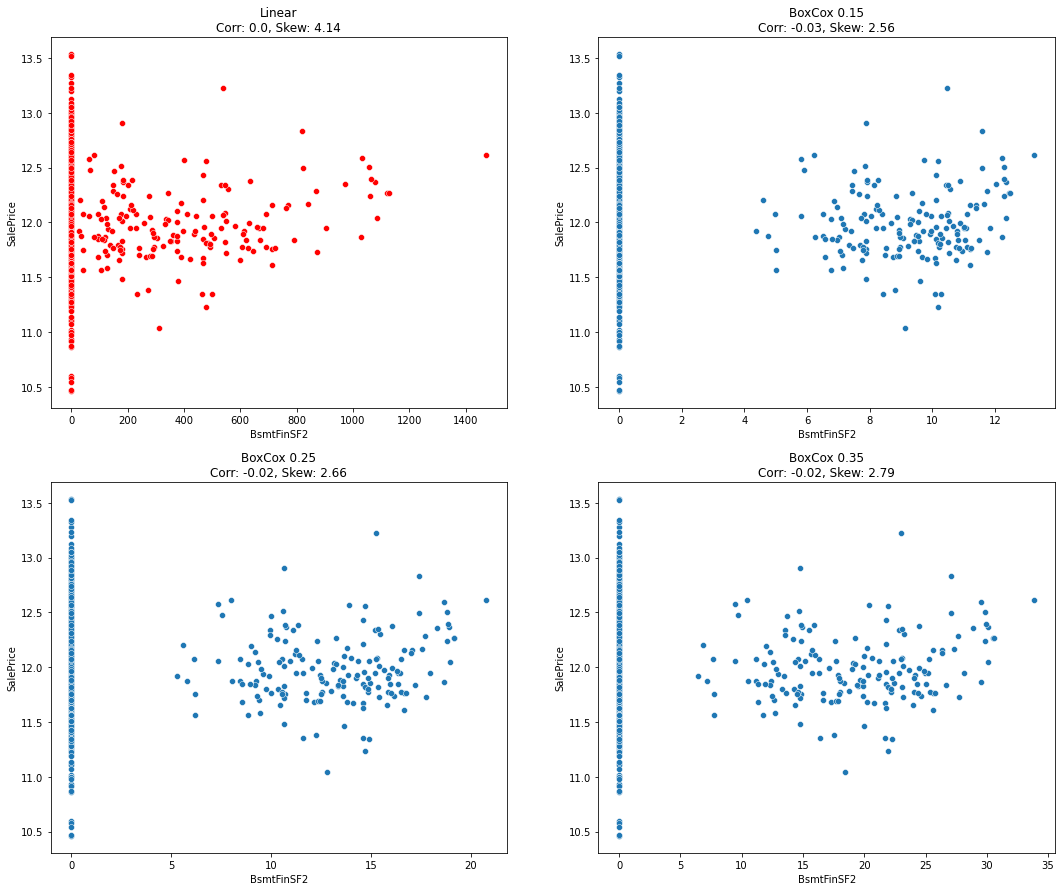

In [490]:
make_continuous_plot('BsmtFinSF2')

In [491]:
# since there is no correlation at all, I'll flag this feature.
dataset.BsmtFinSF2 = dataset.BsmtFinSF2.apply(lambda x: 1 if x > 0 else 0)

Unfinished square feet of basement area.

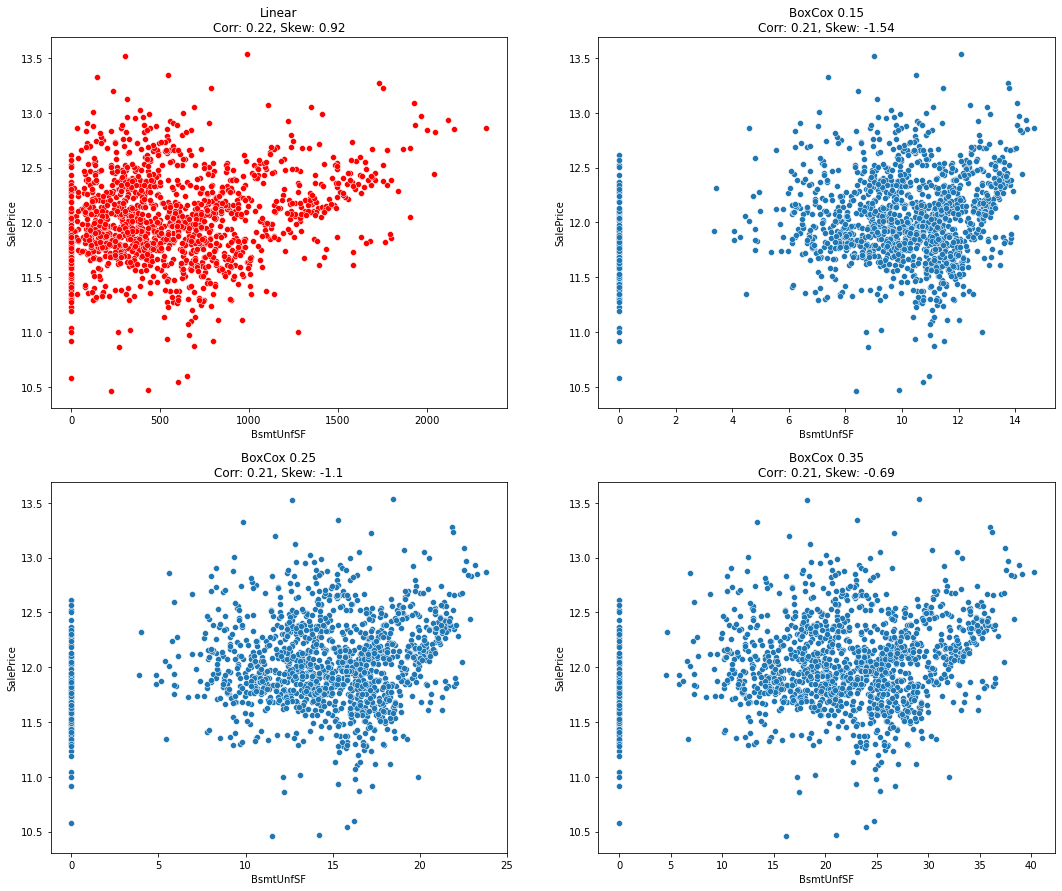

In [492]:
make_continuous_plot('BsmtUnfSF')

0.0 , 2336.0


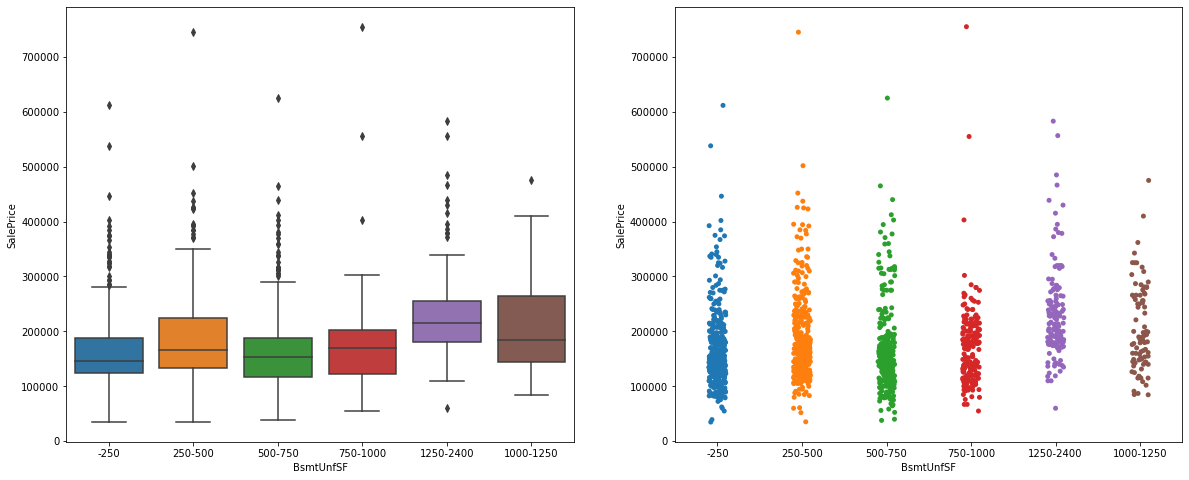

In [493]:
# Let's transform those values into categories
print(min(dataset.BsmtUnfSF.values), ',',
      max(dataset.BsmtUnfSF.values))
0.0 , 2336.0
bins = [-1, 250, 500, 750, 1000, 1250, 2400]
names = ['-250', '250-500', '500-750', '750-1000',
         '1000-1250', '1250-2400']

dataset.BsmtUnfSF = pd.cut(dataset.BsmtUnfSF, bins, labels=names)
# change type from category to str
dataset.BsmtUnfSF = dataset.BsmtUnfSF.astype(str)
make_discrete_plot('BsmtUnfSF',0,0)

Total square feet of basement area.

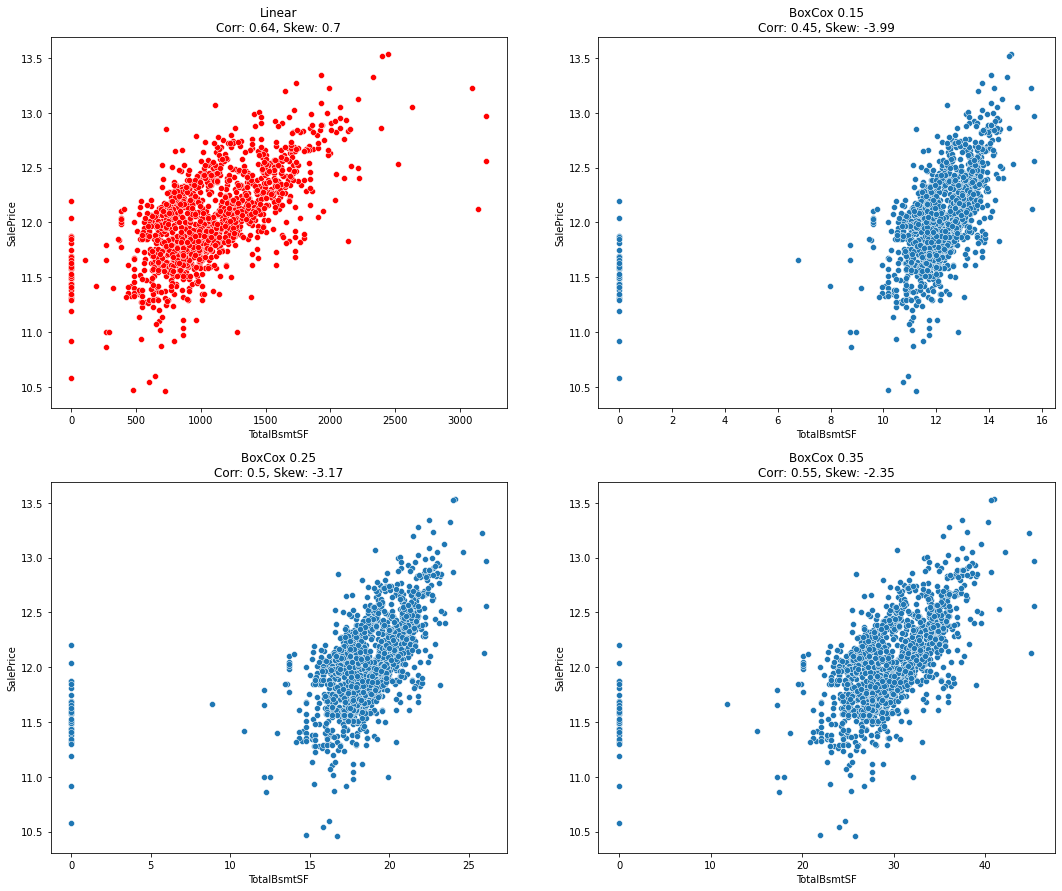

In [494]:
make_continuous_plot('TotalBsmtSF')

First and Second Floors square feet.

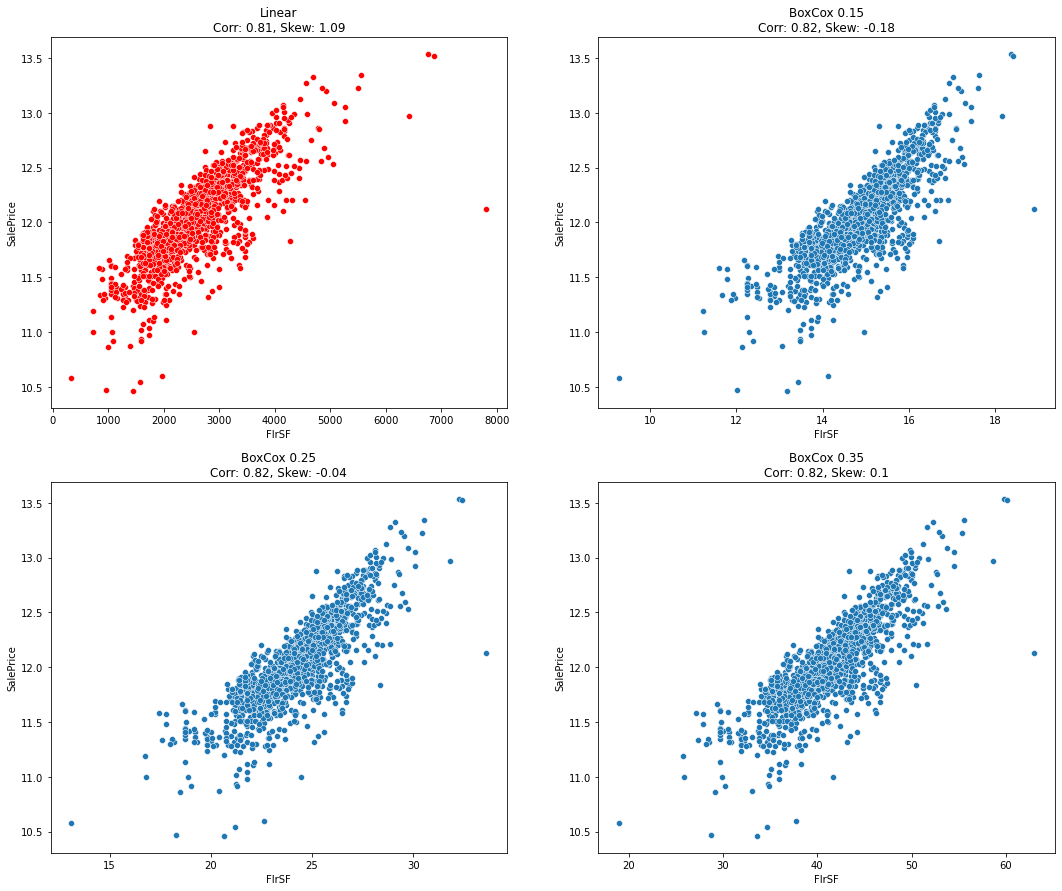

In [495]:
# Let's add another variable, with the sum of these others
dataset["FlrSF"] = dataset["1stFlrSF"] + dataset["2ndFlrSF"] + dataset["TotalBsmtSF"]
make_continuous_plot('FlrSF')

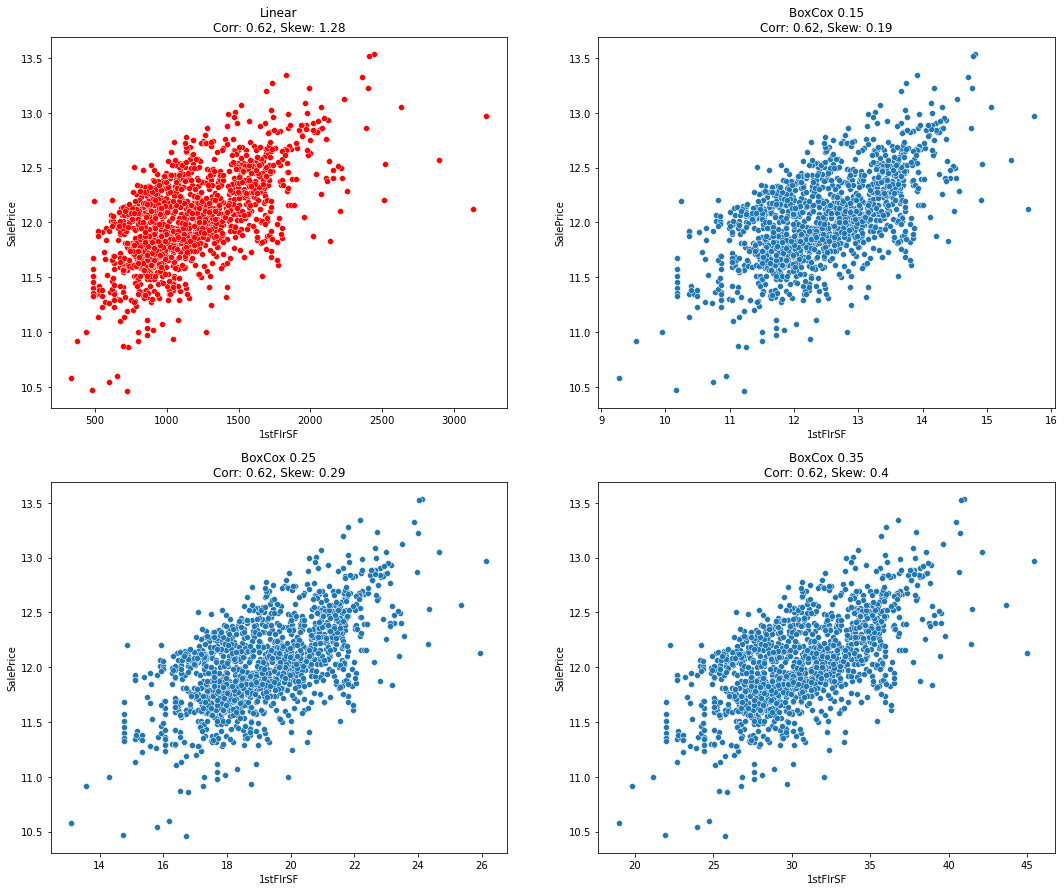

In [496]:
make_continuous_plot('1stFlrSF')

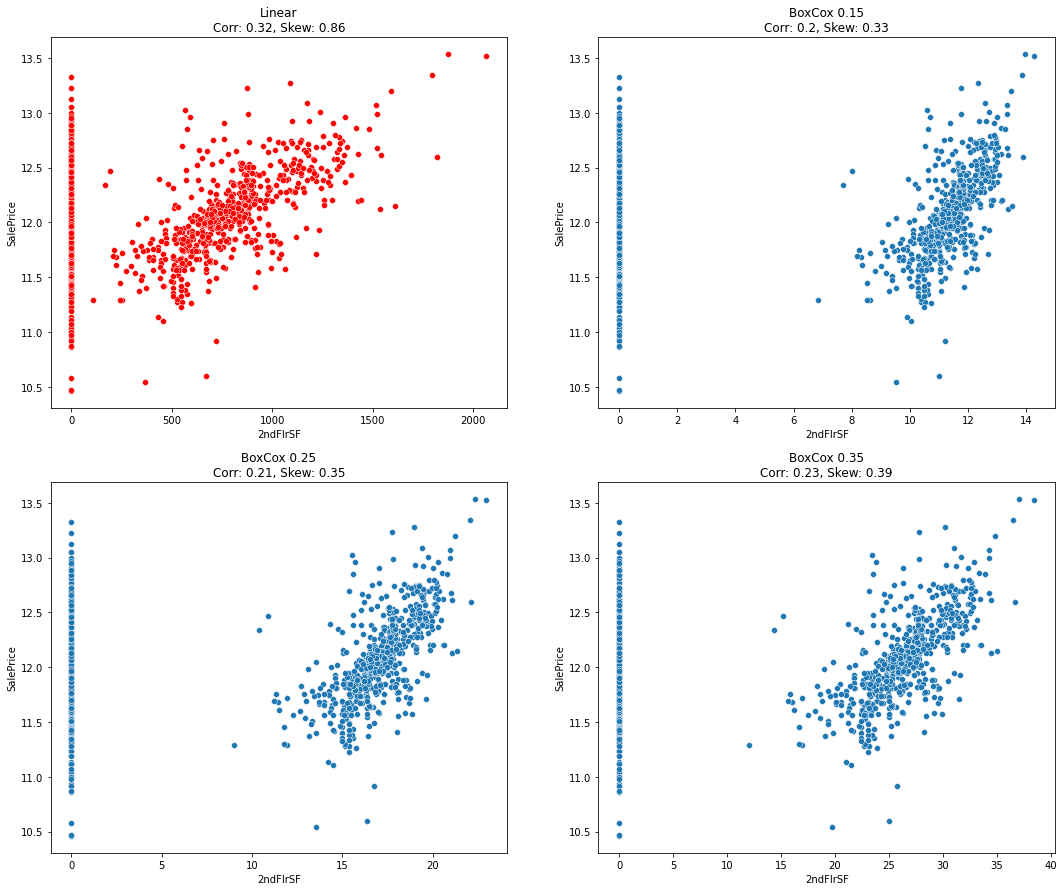

In [497]:
make_continuous_plot('2ndFlrSF')

In [498]:
dataset.FlrSF = boxcox1p(dataset.FlrSF, 0.35)
dataset["1stFlrSF"] = boxcox1p(dataset["1stFlrSF"], 0.15)
# Let's transform values of 2ndFlrSF into categories
print(min(dataset['2ndFlrSF'].values), ',',
      max(dataset['2ndFlrSF'].values))

0 , 2065


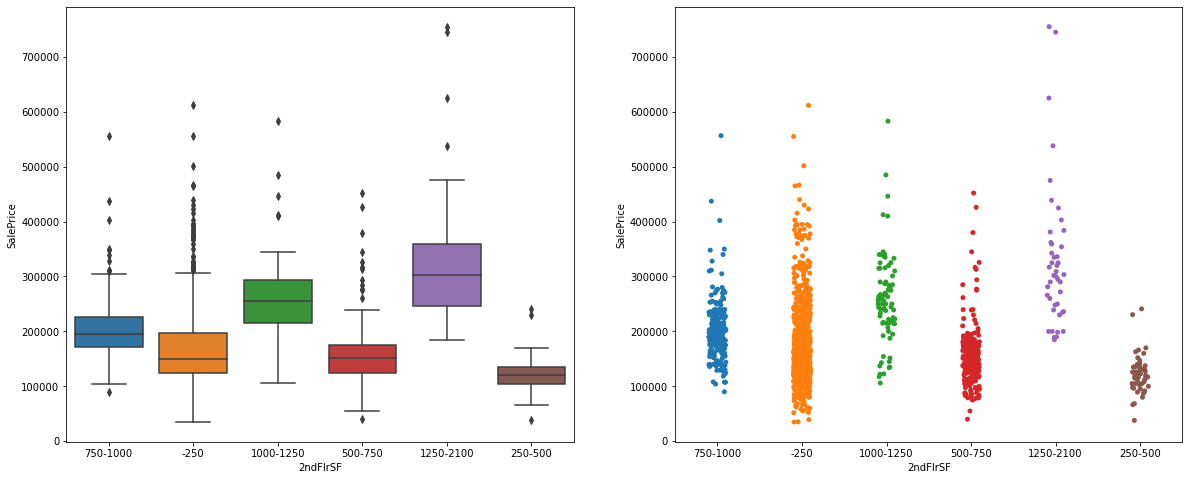

In [499]:
bins = [-1, 250, 500, 750, 1000, 1250, 2100]
names = ['-250', '250-500', '500-750', '750-1000',
         '1000-1250', '1250-2100']

dataset['2ndFlrSF'] = pd.cut(dataset['2ndFlrSF'], bins, labels=names)
# change type from category to str
dataset['2ndFlrSF'] = dataset['2ndFlrSF'].astype(str)
make_discrete_plot('2ndFlrSF',0,0)

Low quality finished square feet (all floors).

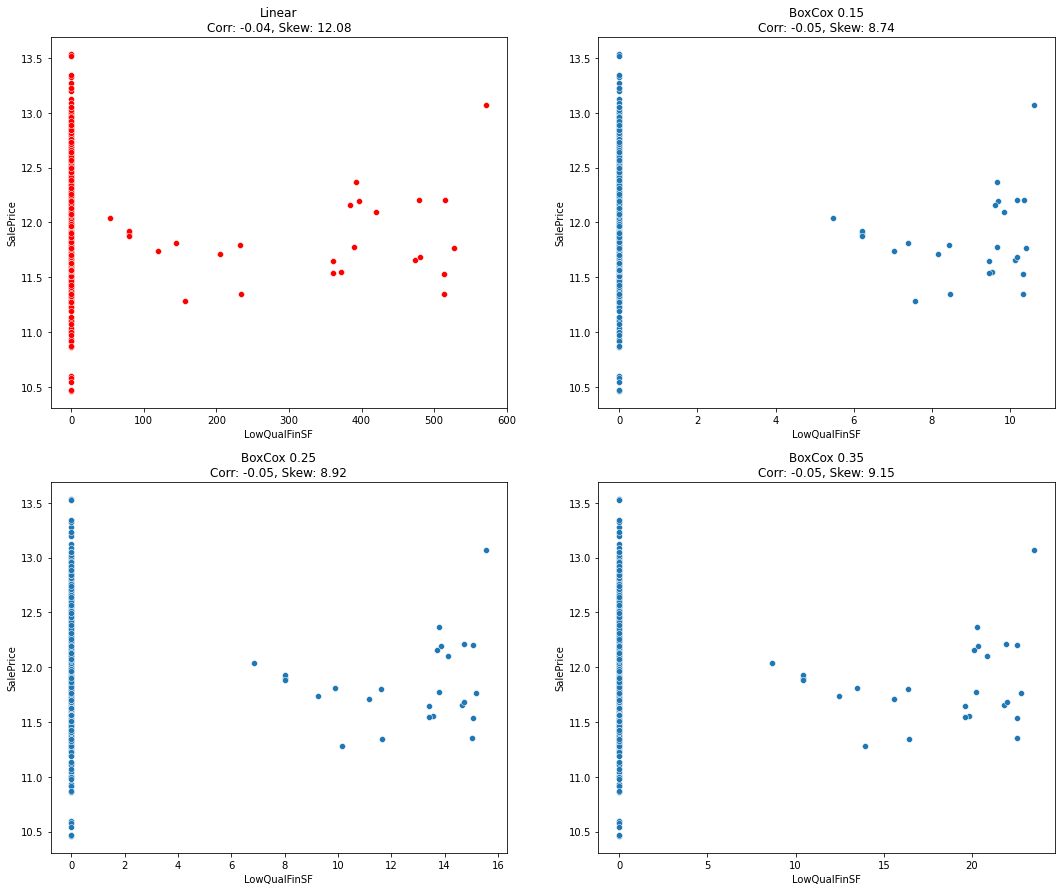

In [500]:
make_continuous_plot('LowQualFinSF')

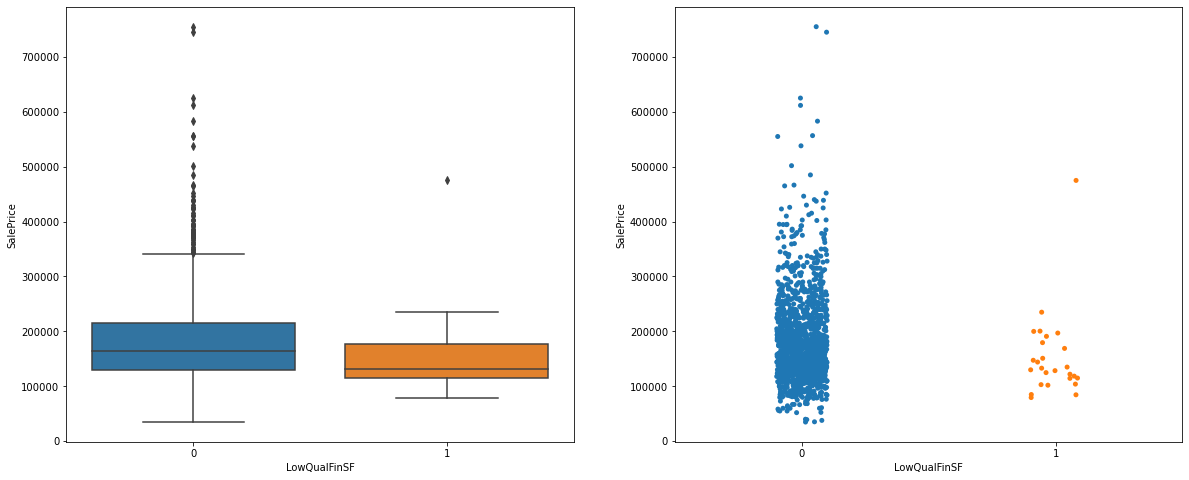

In [501]:
# since there is no correlation, I'll flag it
dataset.LowQualFinSF = dataset.LowQualFinSF.apply(lambda x: 1 if x > 0 else 0)
make_discrete_plot('LowQualFinSF',0,0)


Above grade (ground) living area square feet.

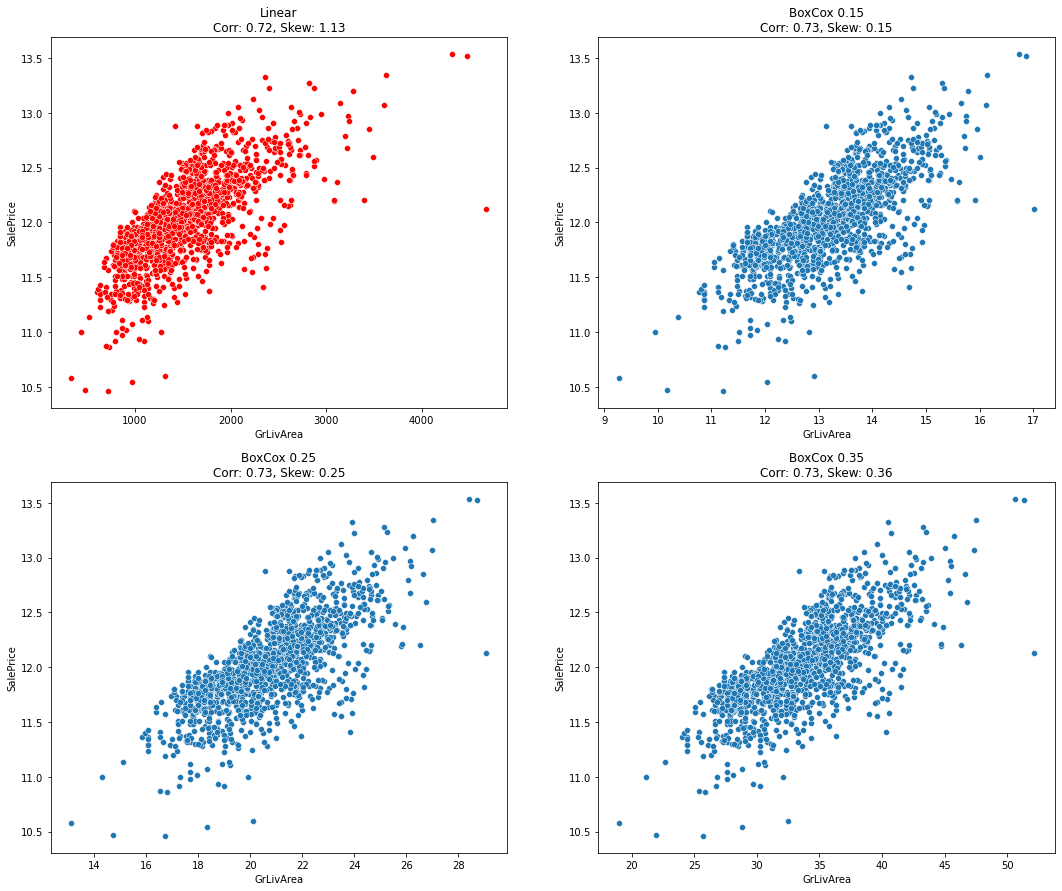

In [502]:
make_continuous_plot('GrLivArea')

In [503]:
dataset.GrLivArea = boxcox1p(dataset.GrLivArea,0.15)

Area of the garage.

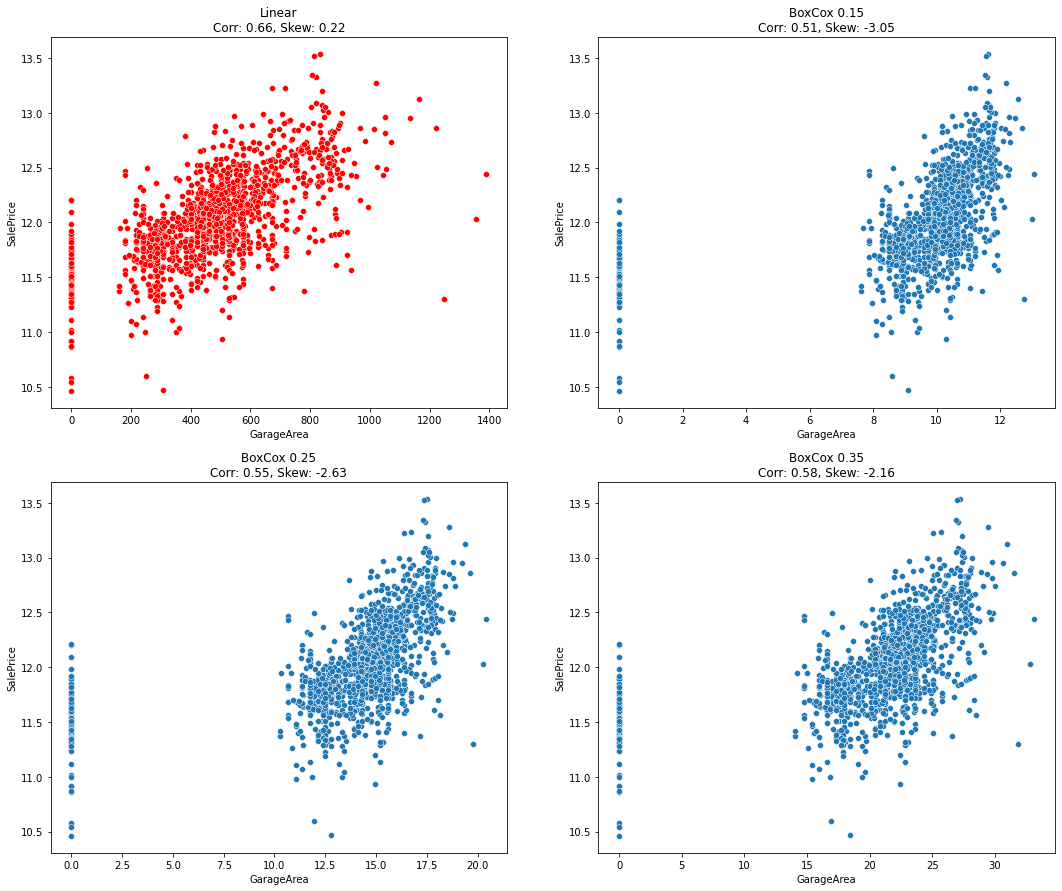

In [504]:
make_continuous_plot('GarageArea')

Wood deck area in square feet.

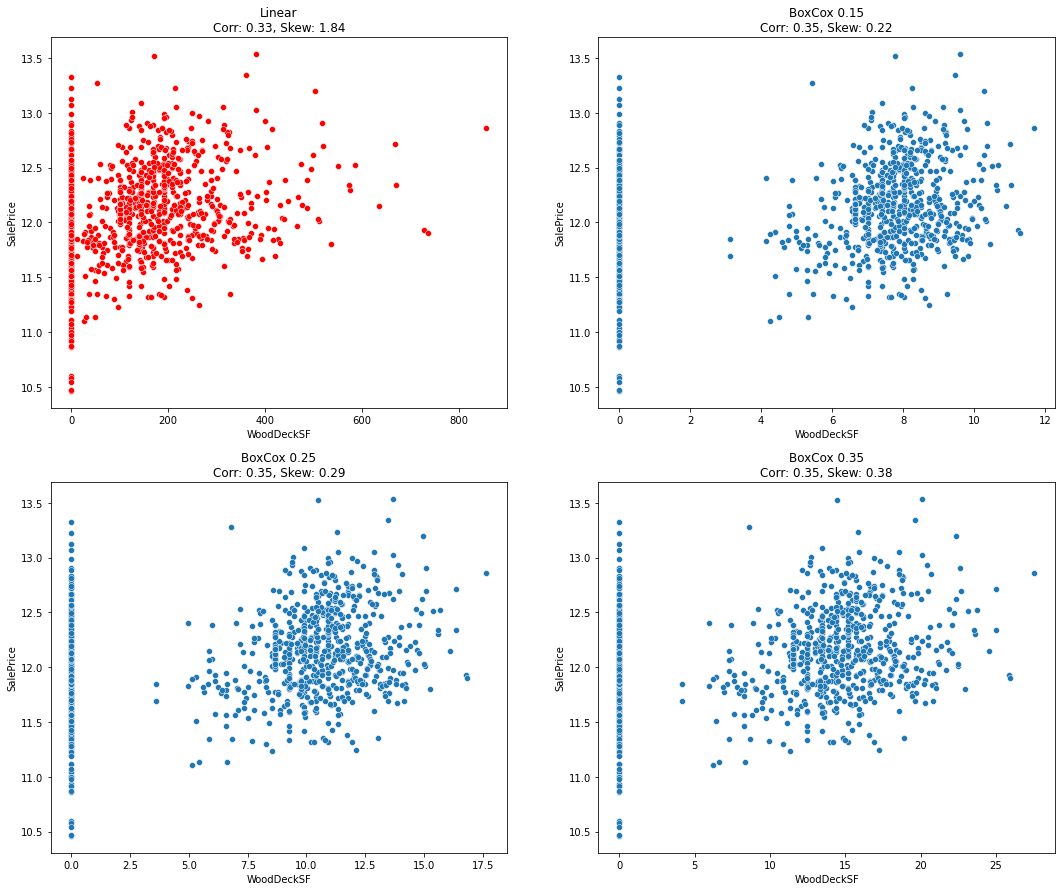

In [505]:
make_continuous_plot('WoodDeckSF')

In [506]:
dataset.WoodDeckSF = boxcox1p(dataset.WoodDeckSF,0.15)

Porch areas in square feet.

In [507]:
# These variables can be summed into one
dataset["PorchSF"] = dataset["OpenPorchSF"] + dataset["EnclosedPorch"] + dataset["3SsnPorch"] + dataset["ScreenPorch"]
dataset = dataset.drop(columns=["OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch"])

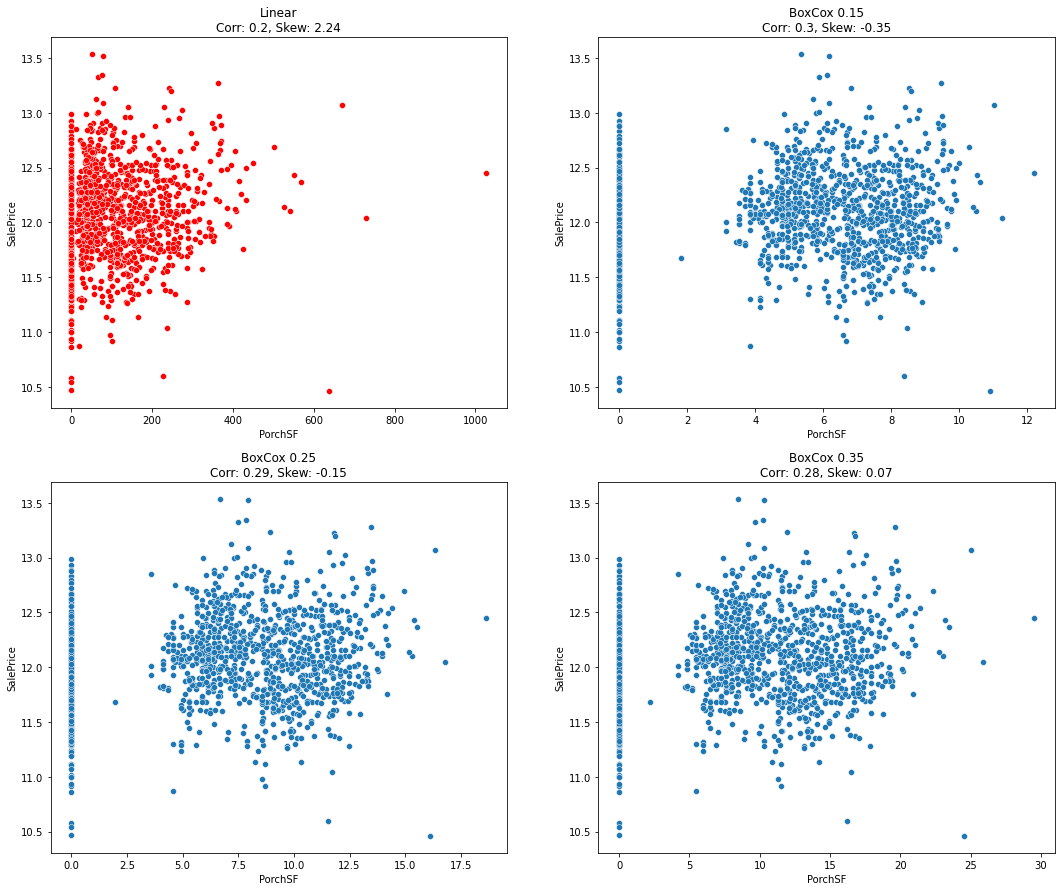

In [508]:
make_continuous_plot('PorchSF')

In [509]:
dataset.PorchSF = boxcox1p(dataset.PorchSF, 0.35)

Pool area in square feet.

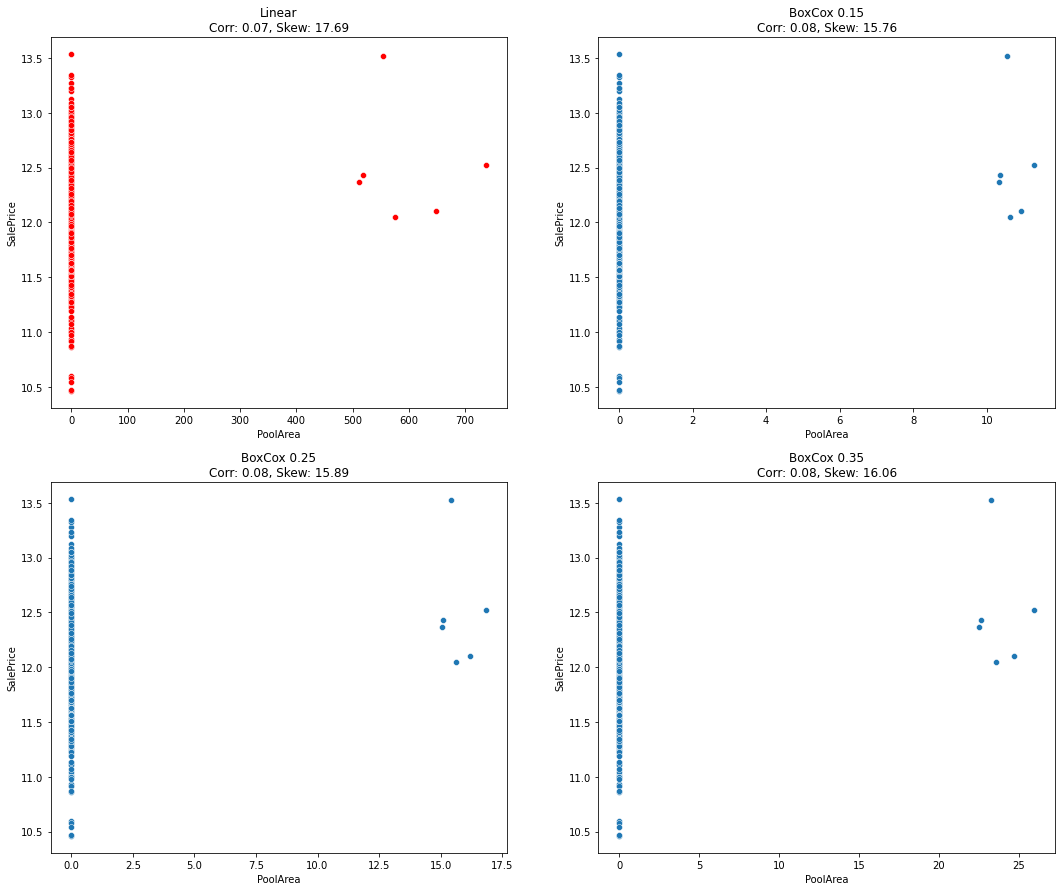

In [510]:
make_continuous_plot('PoolArea')

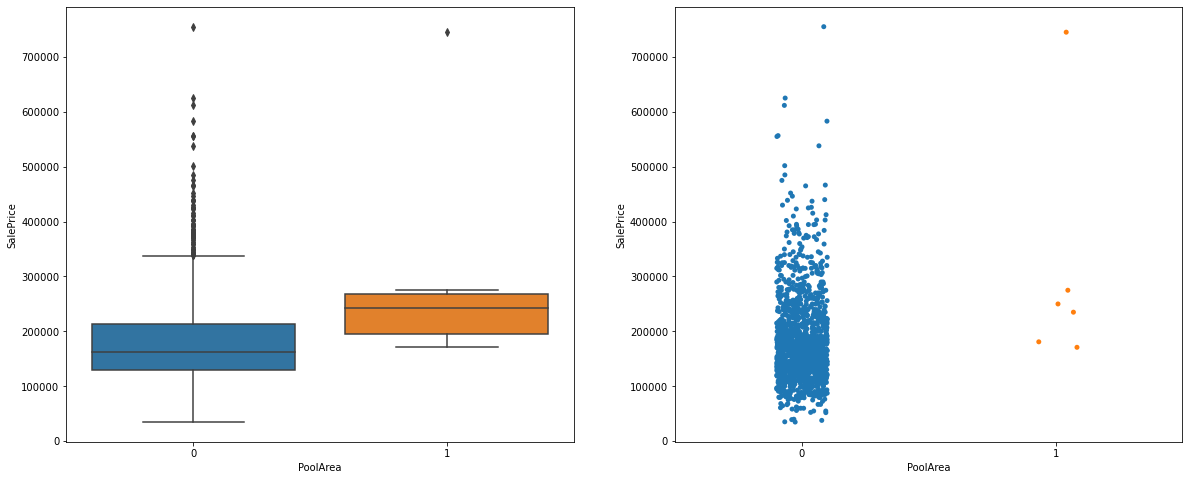

In [511]:
# since there is no correlation, I'll flag it
dataset.PoolArea = dataset.PoolArea.apply(lambda x: 1 if x > 0 else 0)
make_discrete_plot('PoolArea',0,0)

$Value of miscellaneous feature.

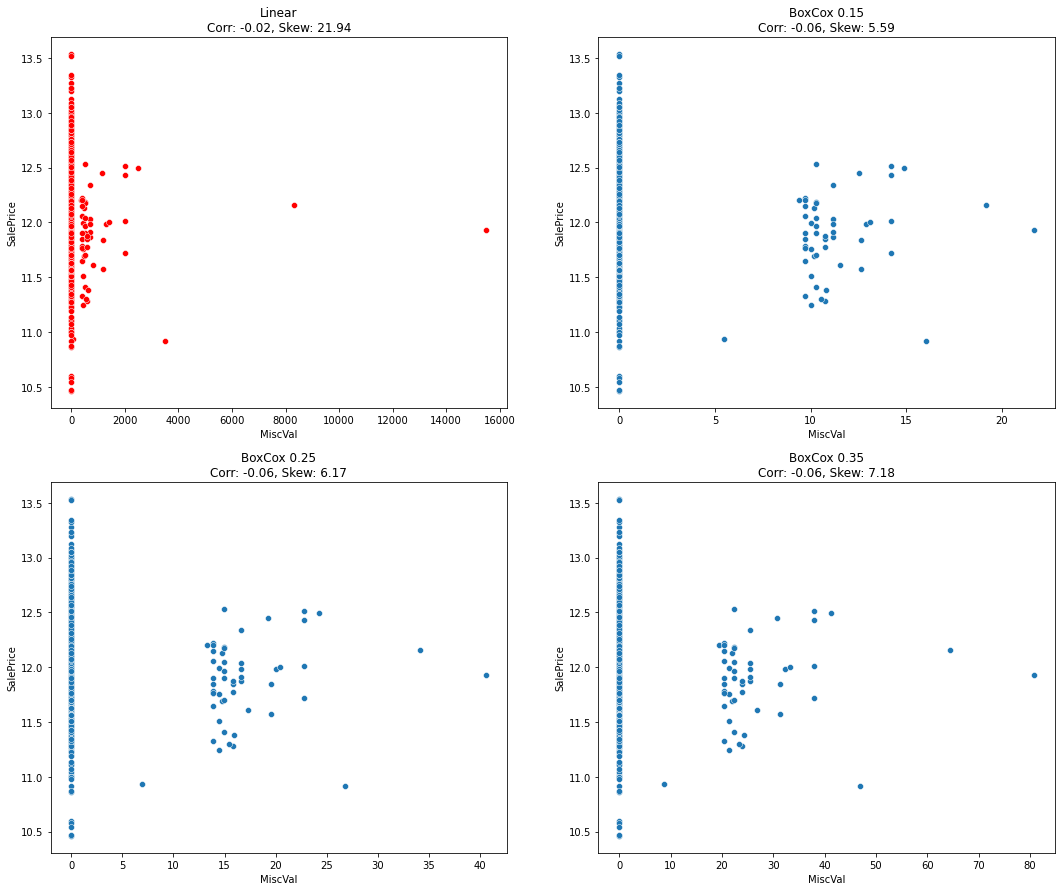

In [512]:
make_continuous_plot('MiscVal')

In [513]:
dataset = dataset.drop(columns=["MiscVal"])

### Ordinal Variables

Here, we will first change the strings by integers, because the variables are ordinal, we can't get dummies unless the correlation with SalePrice is very low. We are going to make decisions based on correlation, missing values and so on.

In [514]:
# To remember

cat_ordinal = ['LotShape','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir',
               'Electrical','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
               'PavedDrive','PoolQC','Fence']

In [515]:
# replace strings for integers, the details are in the description of the competition

dict_ = {"PoolQC": {"NA": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "Fence": {"NA": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4},
         "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "GarageFinish": {"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3},
         "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
         "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "BsmtFinType2": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
         "BsmtFinType1": {"NA": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6},
         "Electrical": {"Mix": 0, "FuseP": 1, "FuseF": 2, "FuseA": 3, "SBrkr": 4},
         "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7},
         "KitchenQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "Utilities": {"ELO": 0, "NoSeWa": 1, "NoSewr": 2, "AllPub": 3},
         "LotShape": {"IR3": 0, "IR2": 1, "IR1": 2, "Reg": 3},
         "LandSlope": {"Sev": 0, "Mod": 1, "Gtl": 2},
         "ExterQual": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "ExterCond": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "HeatingQC": {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
         "CentralAir": {"N": 0, "Y": 1},
         "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
         "PavedDrive": {"N": 0, "P": 1, "Y": 2}}

dataset.replace(dict_, inplace=True)
dataset[cat_ordinal].dtypes

LotShape        int64
Utilities       int64
LandSlope       int64
OverallQual     int64
OverallCond     int64
ExterQual       int64
ExterCond       int64
BsmtQual        int64
BsmtCond        int64
BsmtExposure    int64
BsmtFinType1    int64
BsmtFinType2    int64
HeatingQC       int64
CentralAir      int64
Electrical      int64
KitchenQual     int64
Functional      int64
FireplaceQu     int64
GarageFinish    int64
GarageQual      int64
GarageCond      int64
PavedDrive      int64
PoolQC          int64
Fence           int64
dtype: object

In [516]:
# one of the variables didn't change to integer, so let's change it
dataset.BsmtCond = dataset.BsmtCond.astype(int)

General shape of property.

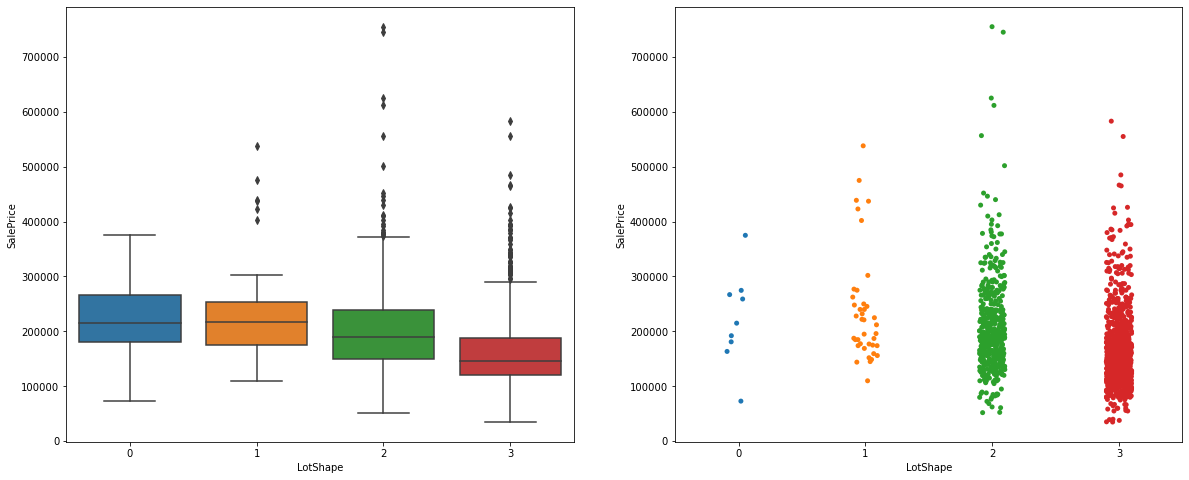

In [517]:
make_discrete_plot('LotShape',0,0)

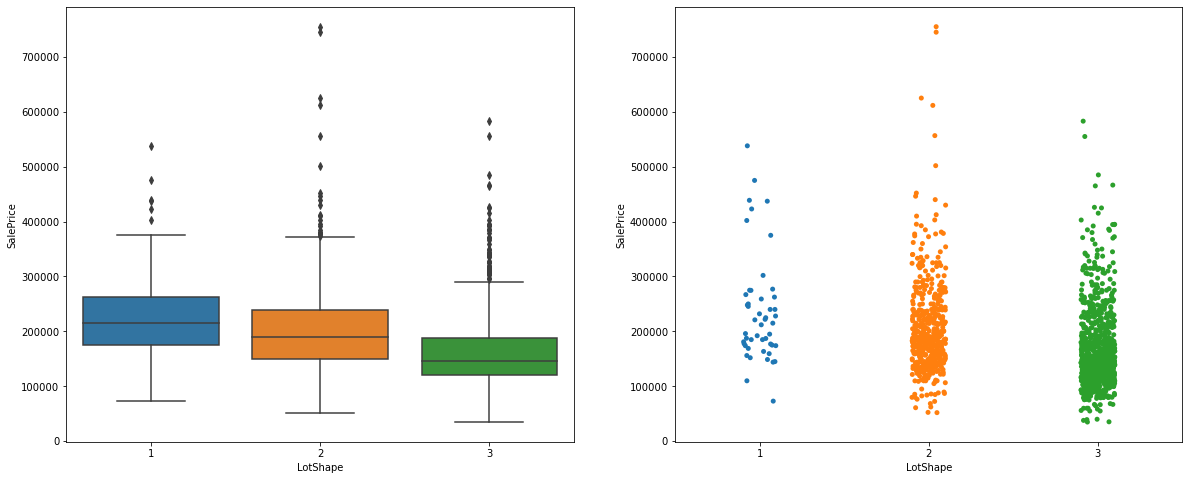

In [518]:
# there few values = 0, so let's put them together with 1
dataset.LotShape = dataset.LotShape.apply(lambda x: 1 if x == 0 else x)
make_discrete_plot('LotShape',0,0)

Type of utilities available

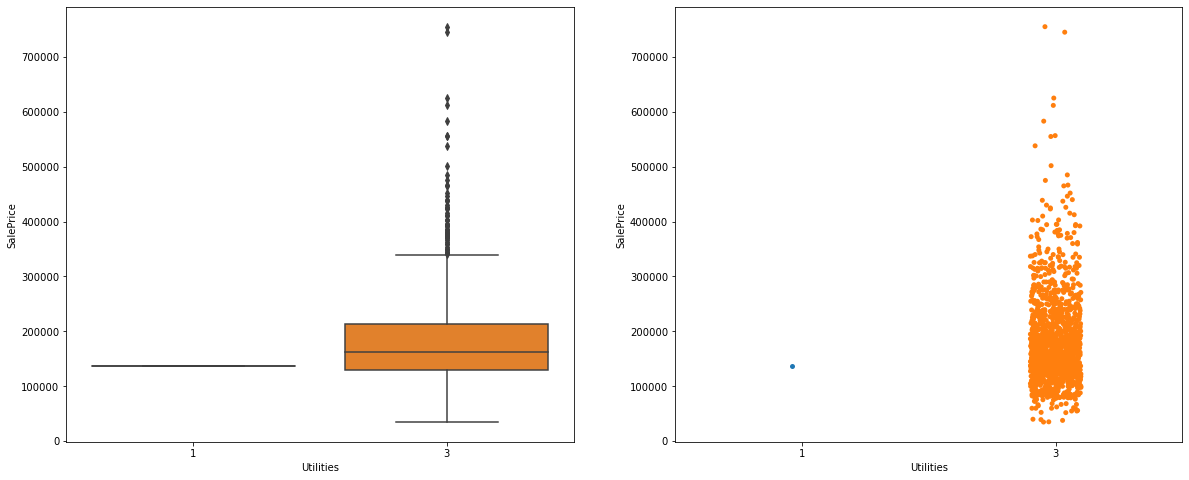

In [519]:
make_discrete_plot('Utilities',0,0)

In [520]:
# of course we need to drop this, just one point in 1
dataset = dataset.drop(columns='Utilities')

Slope of property.

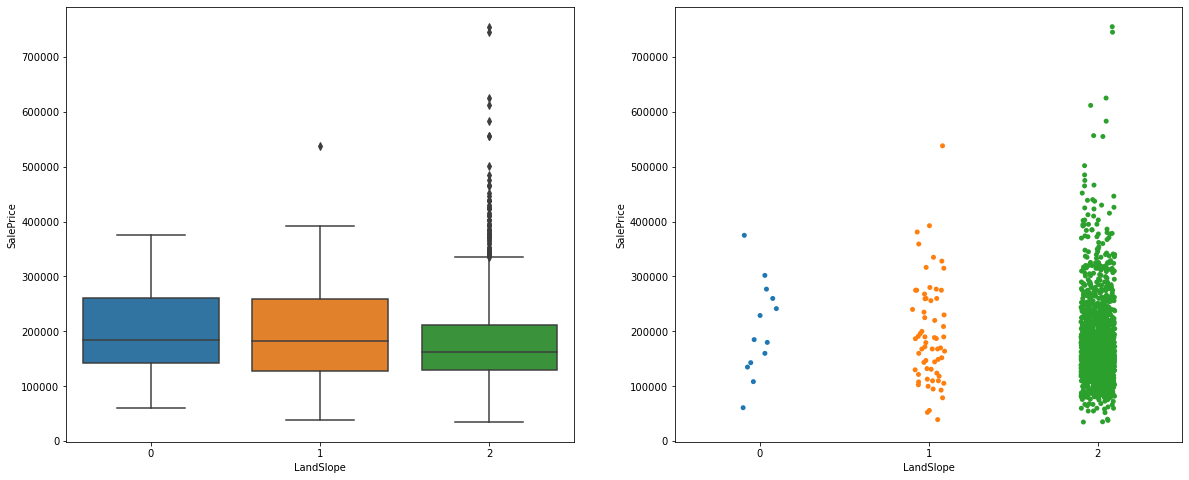

In [521]:
make_discrete_plot('LandSlope',0,0)

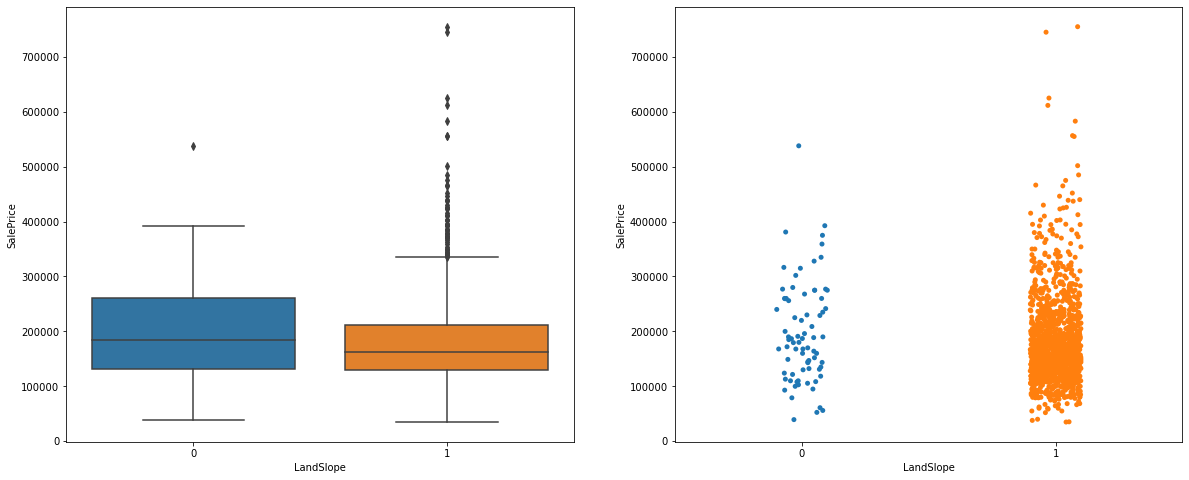

In [522]:
# this variable can make more sense as flag, having gentle slope or not
dataset.LandSlope = dataset.LandSlope.apply(lambda x: 1 if x == 2 else 0)
make_discrete_plot('LandSlope',0,0)

Rates the overall material and finish of the house.

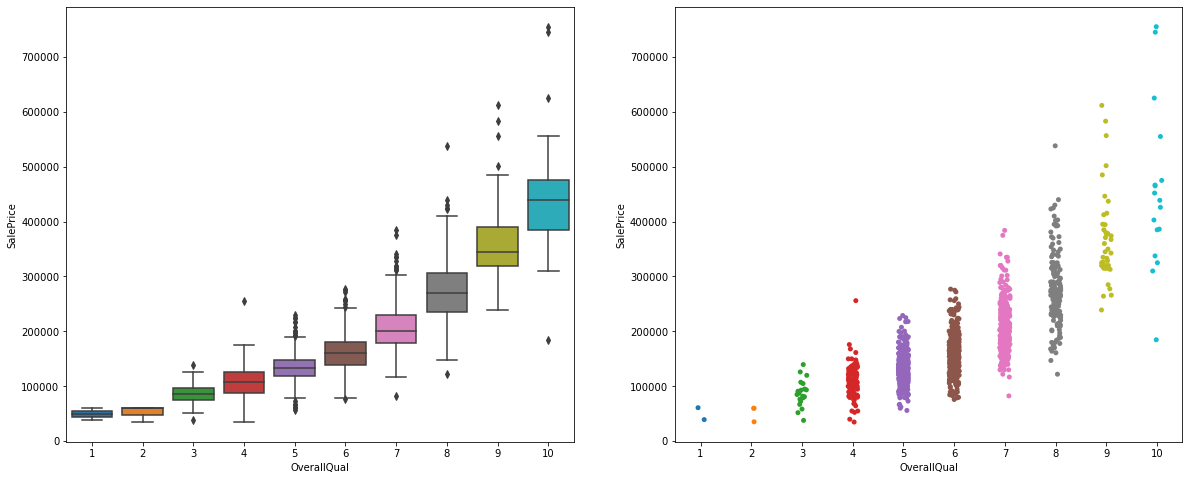

In [523]:
make_discrete_plot('OverallQual',0,0)

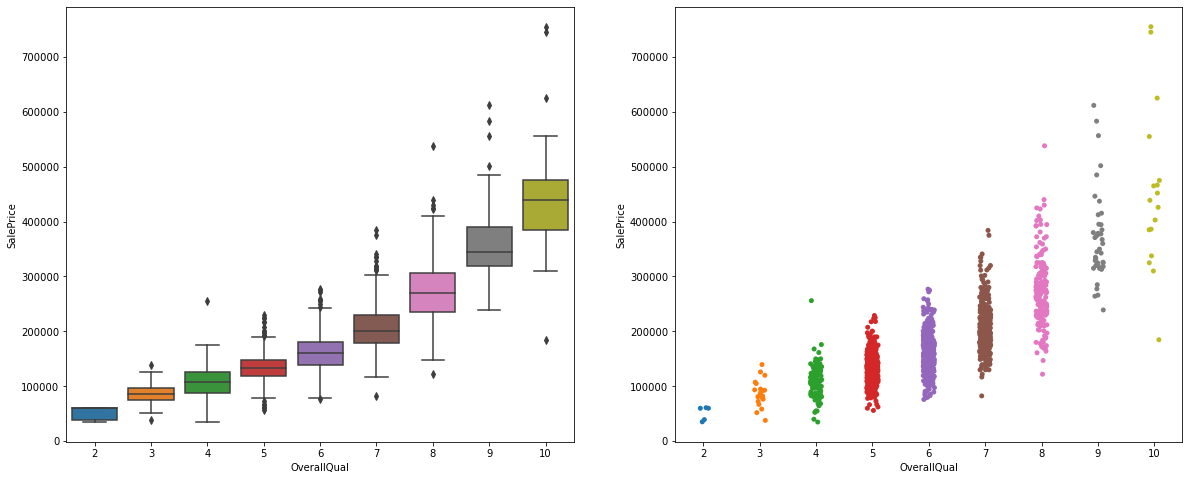

In [524]:
# there are few values < 2, so let's put them together with 2
dataset.OverallQual = dataset.OverallQual.apply(lambda x: 2 if x == 1 else x)
make_discrete_plot('OverallQual',0,0)

Rates the overall condition of the house.

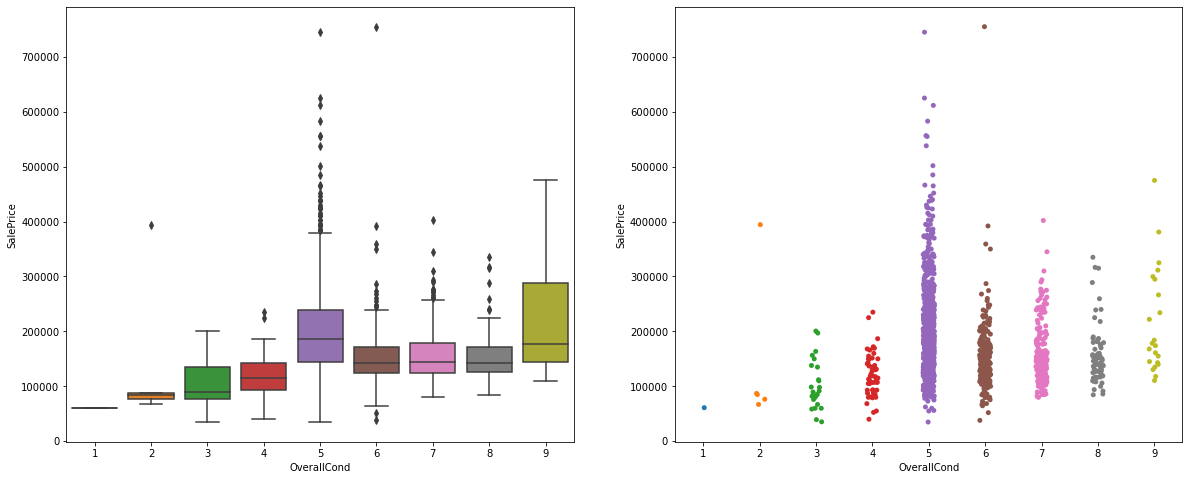

In [525]:
make_discrete_plot('OverallCond',0,0)

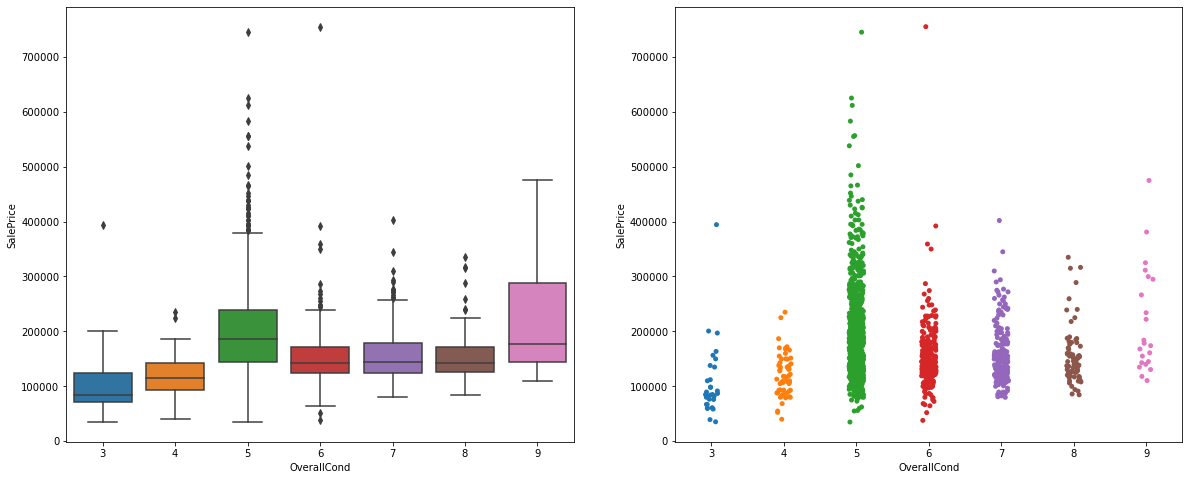

In [526]:
# there are few values <= 2, so let's put them together with 3
dataset.OverallCond = dataset.OverallCond.apply(lambda x: 3 if x < 3 else x)
make_discrete_plot('OverallCond',0,0)

Evaluates the quality of the material on the exterior.

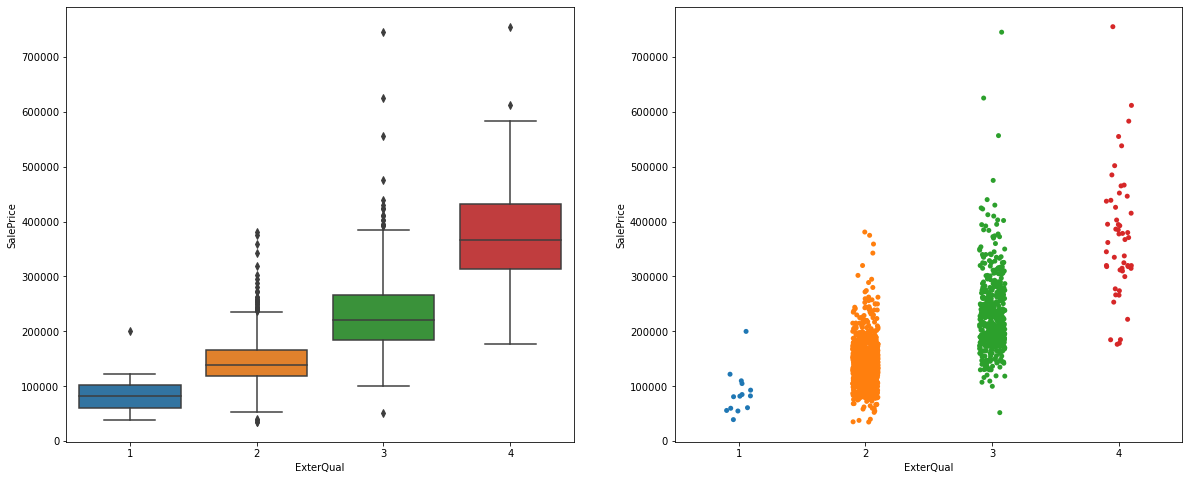

In [527]:
make_discrete_plot('ExterQual',0,0)

Evaluates the present condition of the material on the exterior.

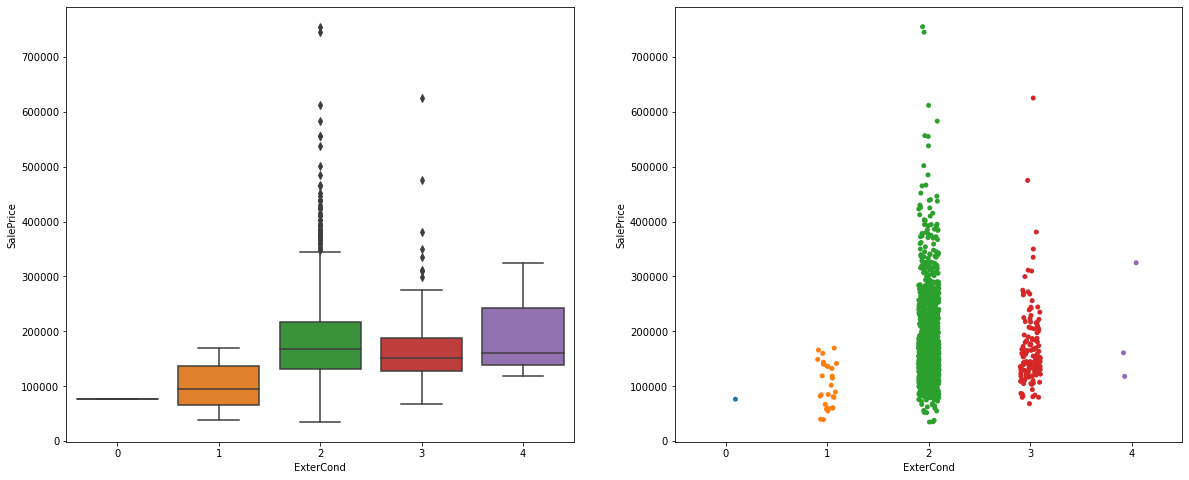

In [528]:
make_discrete_plot('ExterCond',0,0)

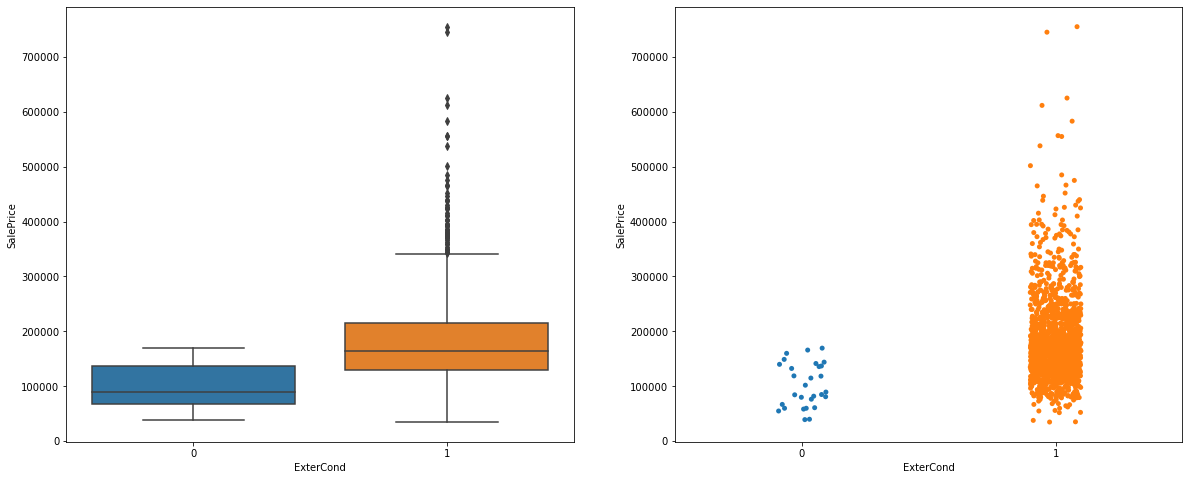

In [529]:
# there are few values < 1, so let's put them together w1 and 0, and 4 with 3 and 2, as 1
dataset.ExterCond = dataset.ExterCond.apply(lambda x: 0 if x == 1 else x)
dataset.ExterCond = dataset.ExterCond.apply(lambda x: 1 if x >= 2 else x)
make_discrete_plot('ExterCond',0,0)

Evaluates the height of the basement.

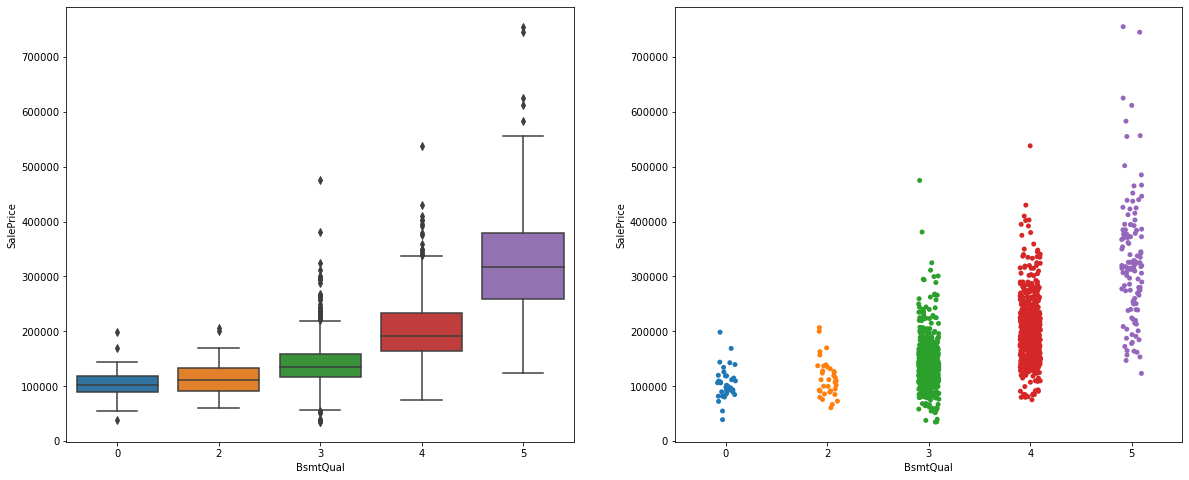

In [530]:
make_discrete_plot('BsmtQual',0,0)

Evaluates the general condition of the basement.

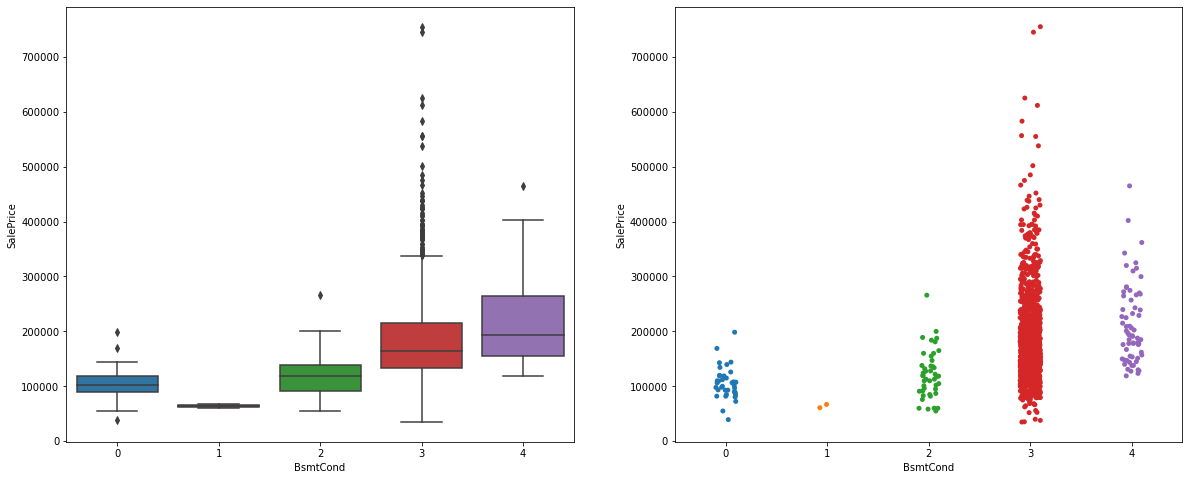

In [531]:
make_discrete_plot('BsmtCond',0,0)

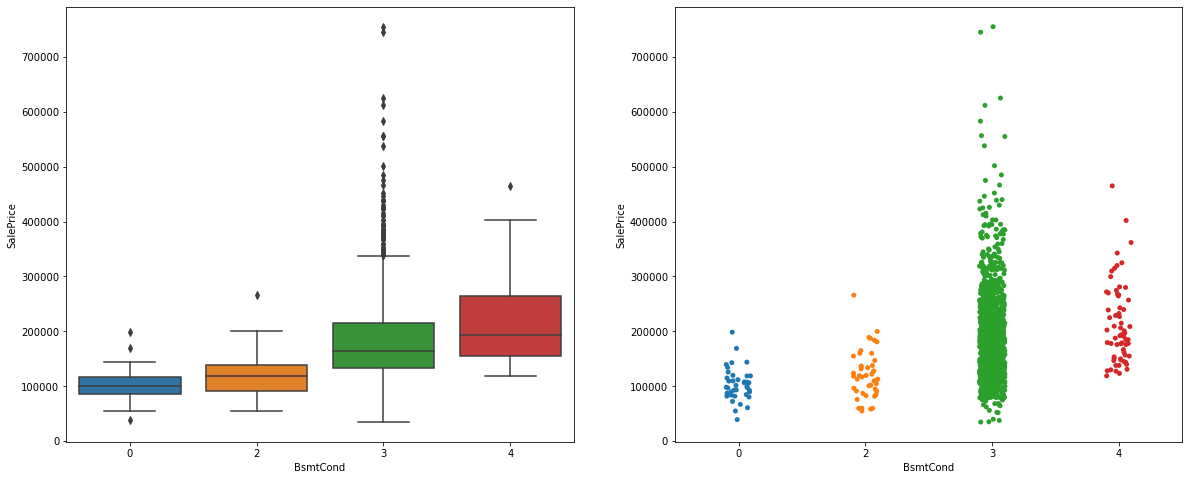

In [532]:
# there are few values = 1, so let's put them together with 0
dataset.BsmtCond = dataset.BsmtCond.apply(lambda x: 0 if x == 1 else x)
make_discrete_plot('BsmtCond',0,0)

Refers to walkout or garden level walls.

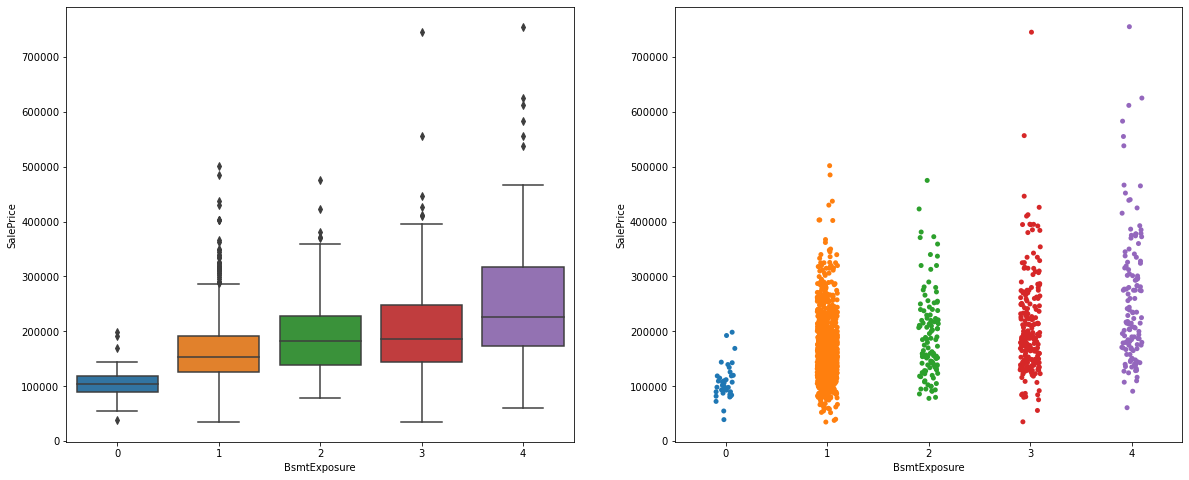

In [533]:
make_discrete_plot('BsmtExposure',0,0)

Rating of basement finished area.

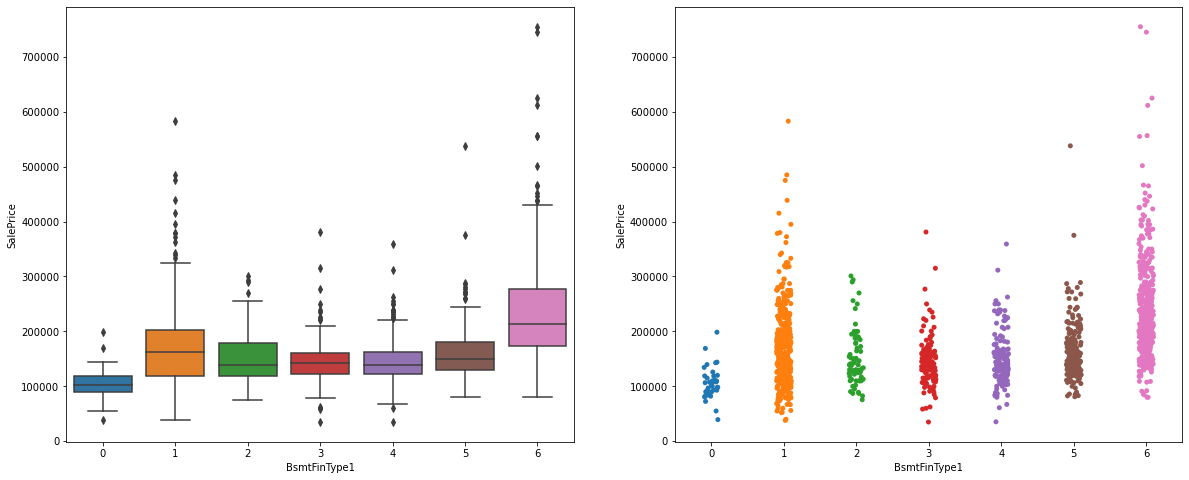

In [534]:
make_discrete_plot('BsmtFinType1',0,0)

In [535]:
# not many difference here between categories, so let's turn into string and later get dummies
dataset.BsmtFinType1 = dataset.BsmtFinType1.astype(str)

Quality of second finished area (if present).

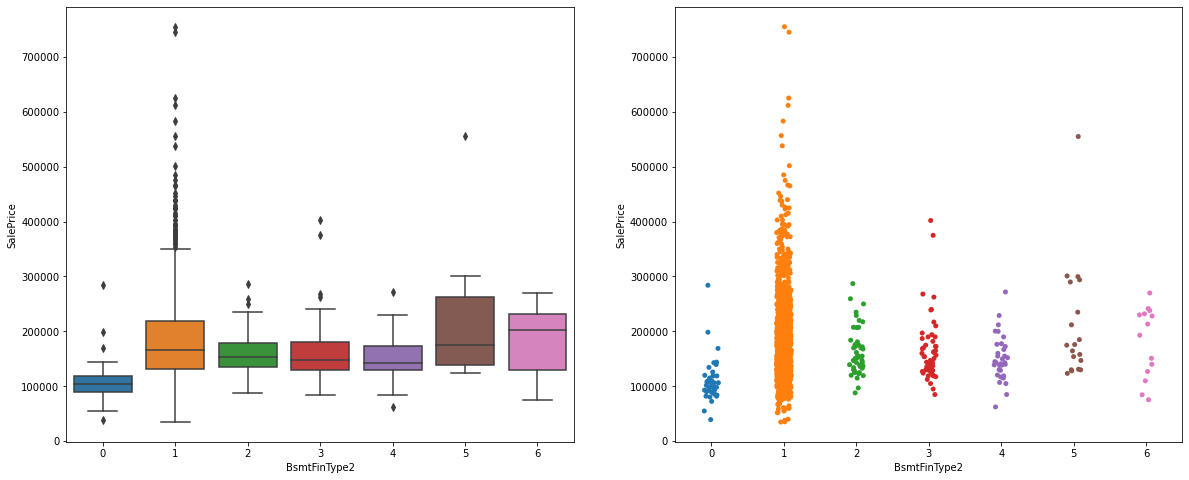

In [536]:
make_discrete_plot('BsmtFinType2',0,0)

In [537]:
# not many difference here between categories, so let's turn into string and later get dummies
dataset.BsmtFinType2 = dataset.BsmtFinType2.astype(str)

Heating quality and condition.

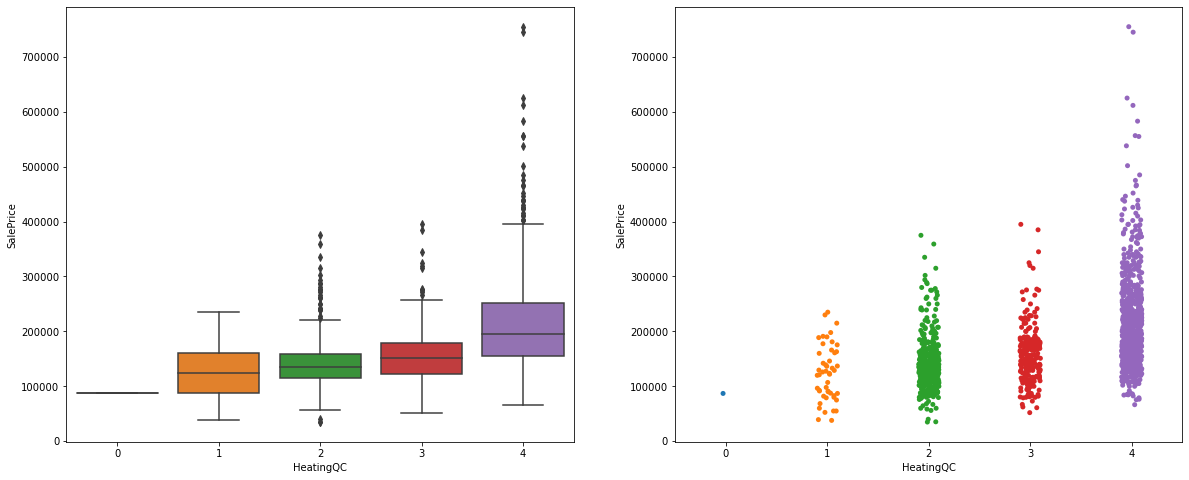

In [538]:
make_discrete_plot('HeatingQC',0,0)

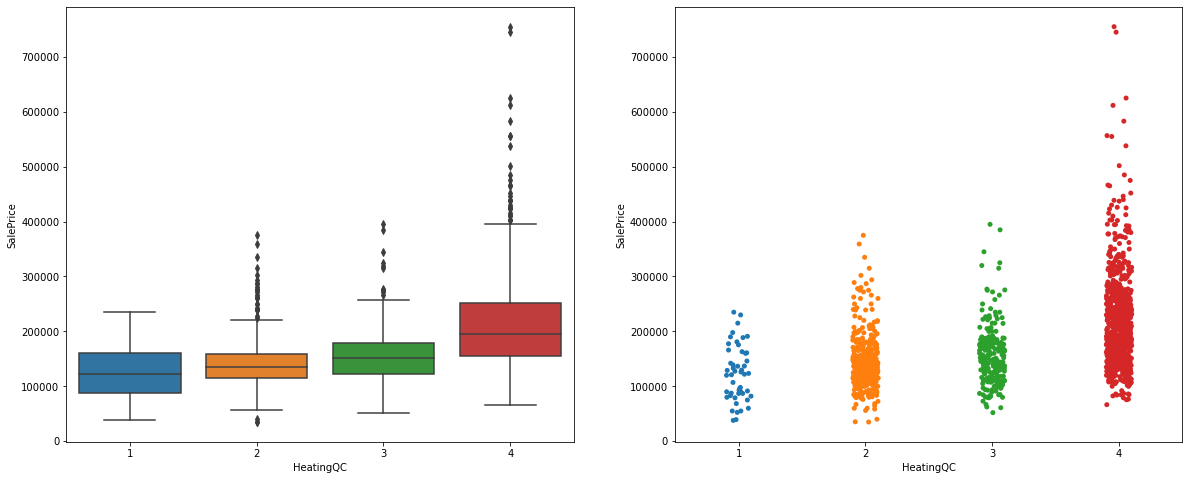

In [539]:
# There are few values = 0, so I will put together with 1
dataset.HeatingQC = dataset.HeatingQC.apply(lambda x: 1 if x == 0 else x)
make_discrete_plot('HeatingQC',0,0)

If Central air conditioning is present.

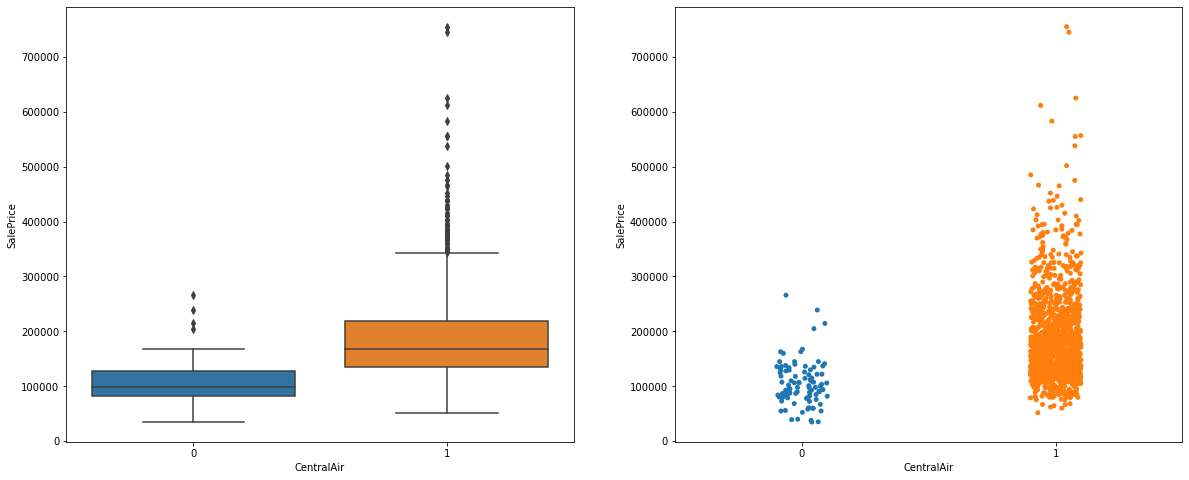

In [540]:
make_discrete_plot('CentralAir',0,0)

Electrical system.

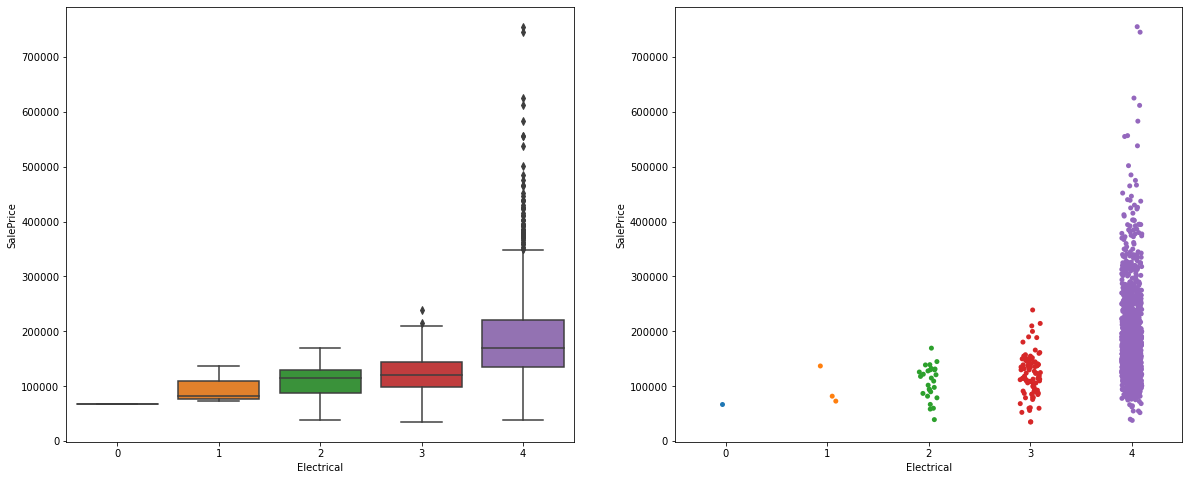

In [541]:
make_discrete_plot('Electrical',0,0)

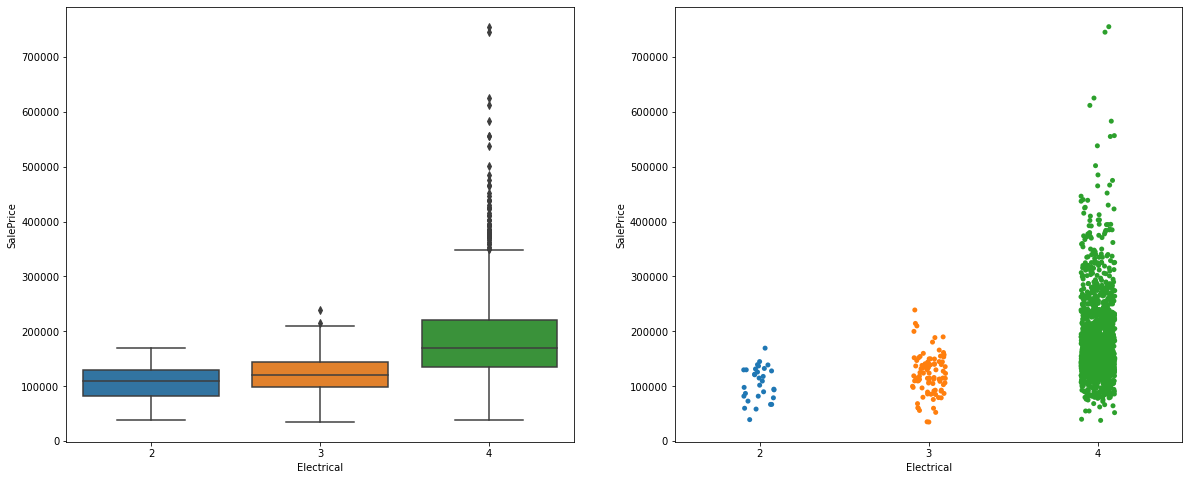

In [542]:
# There are few values < 2, so I will put together with 2
dataset.Electrical = dataset.Electrical.apply(lambda x: 2 if x < 2 else x)
make_discrete_plot('Electrical',0,0)

Kitchen quality.

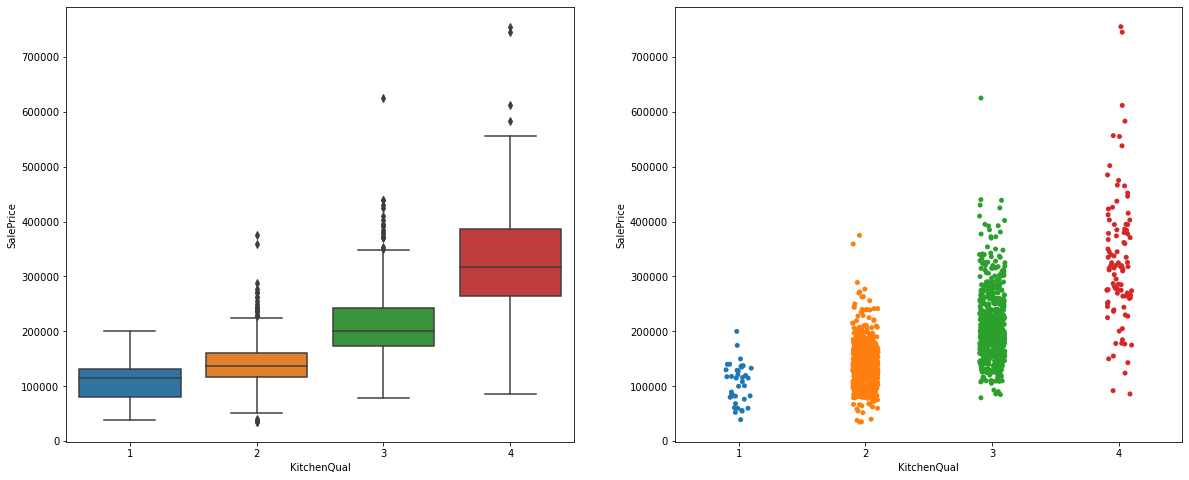

In [543]:
make_discrete_plot('KitchenQual',0,0)

Home functionality (Assume typical unless deductions are warranted).

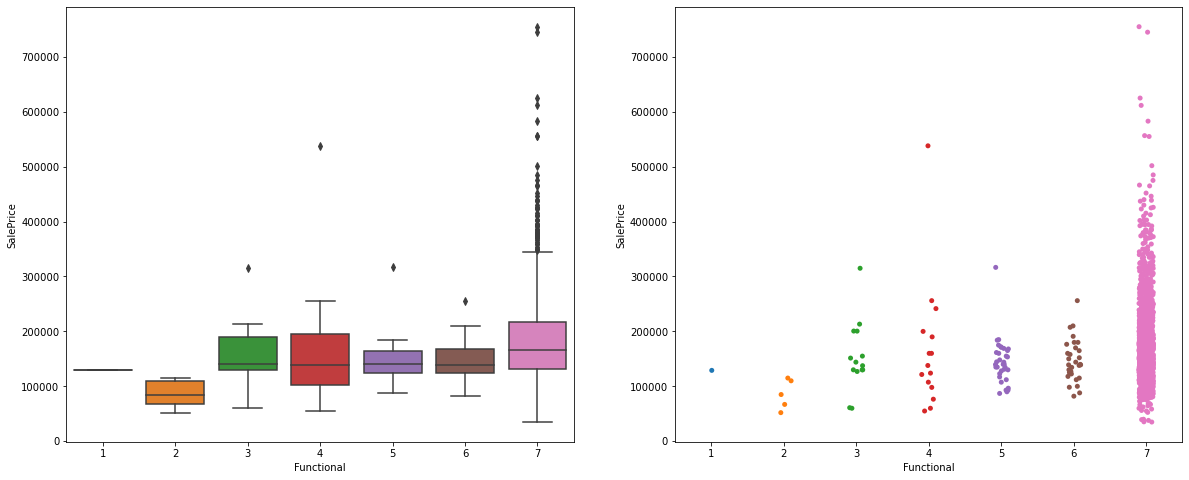

In [544]:
make_discrete_plot('Functional',0,0)

In [545]:
# There are few values = 1, so I will put together with 2
dataset.Functional = dataset.Functional.apply(lambda x: 2 if x < 2 else x)

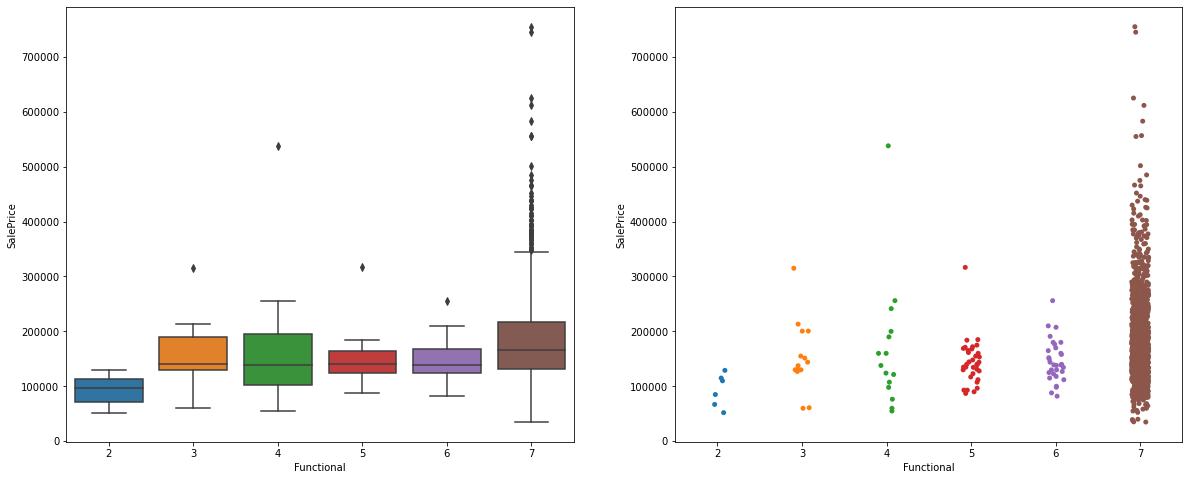

In [546]:
make_discrete_plot('Functional',0,0)

In [547]:
# not many difference here between categories, so let's turn into string and later get dummies
dataset.Functional = dataset.Functional.astype(str)


Fireplace quality.

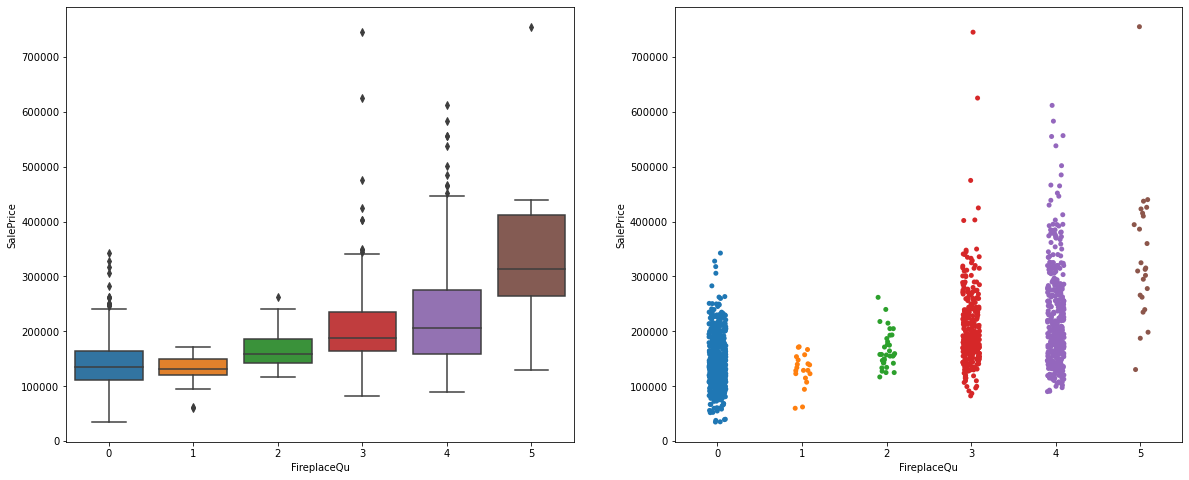

In [548]:
make_discrete_plot('FireplaceQu',0,0)

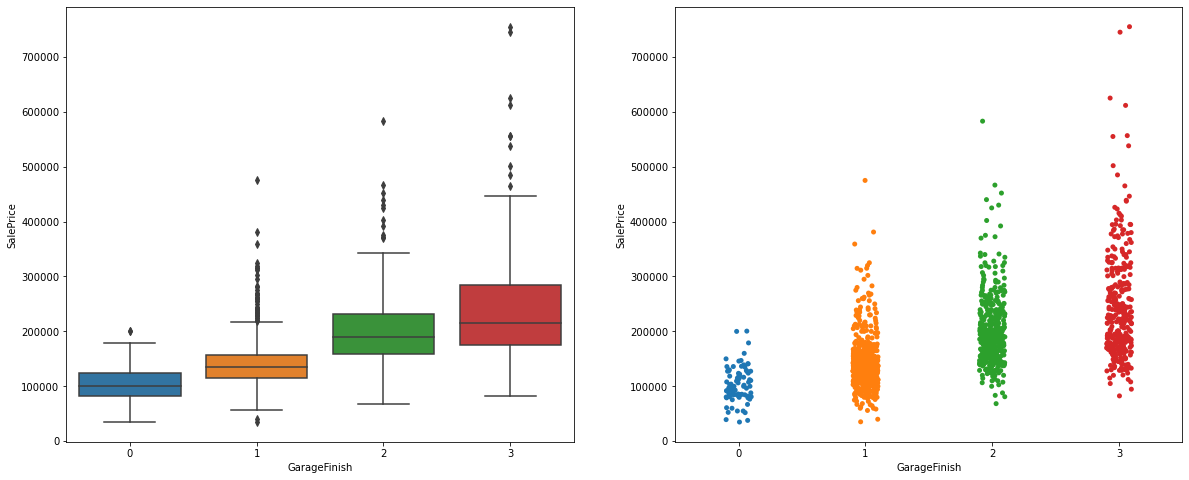

In [549]:
make_discrete_plot('GarageFinish',0,0)

Garage Quality.

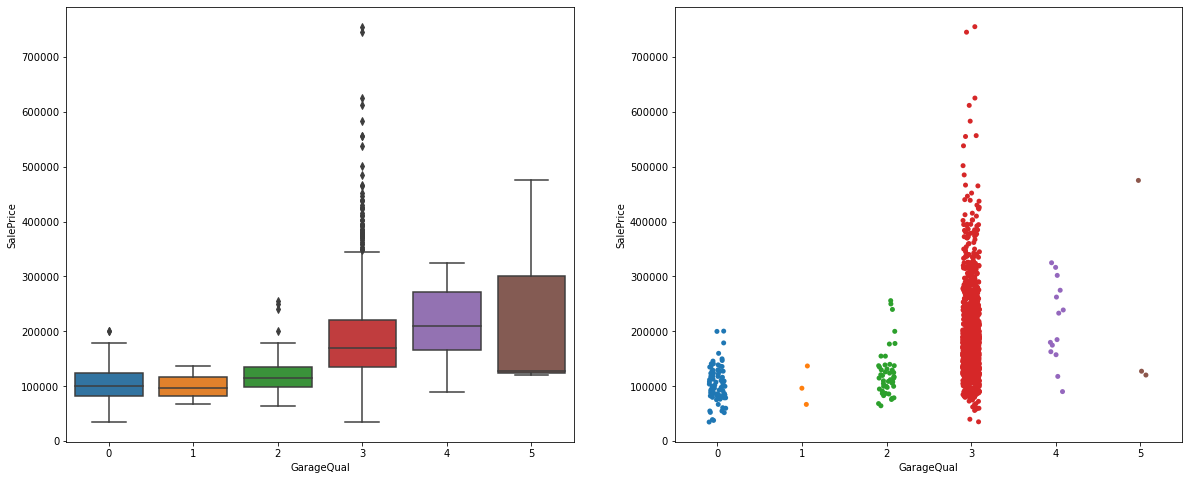

In [550]:
make_discrete_plot('GarageQual',0,0)

In [551]:
# There are few values > 4, so I will put together with 4 and 1 with 0
dataset.GarageQual = dataset.GarageQual.apply(lambda x: 0 if x == 1 else x)
dataset.GarageQual = dataset.GarageQual.apply(lambda x: 4 if x == 5 else x)

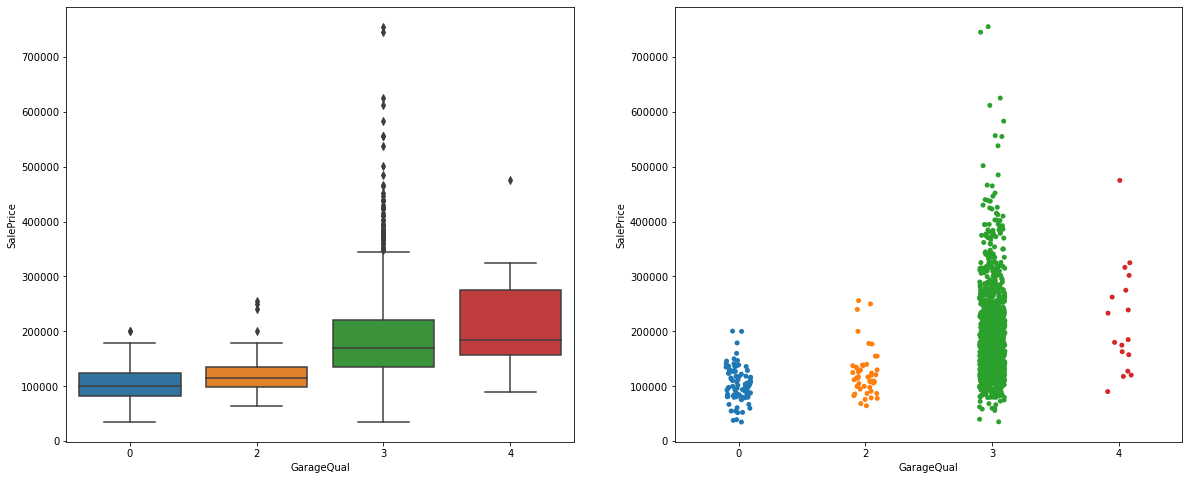

In [552]:
make_discrete_plot('GarageQual',0,0)

Garage condition.

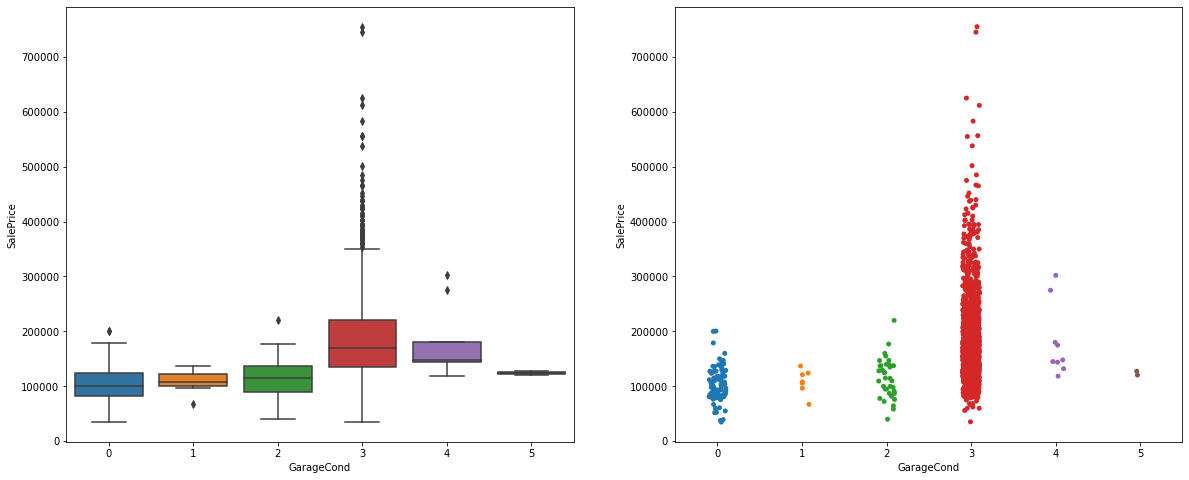

In [553]:
make_discrete_plot('GarageCond',0,0)

In [554]:
# There are few values > 3, so I will put together with 4 and 1 with 0
dataset.GarageCond = dataset.GarageCond.apply(lambda x: 0 if x == 1 else x)
dataset.GarageCond = dataset.GarageCond.apply(lambda x: 3 if x > 3 else x)

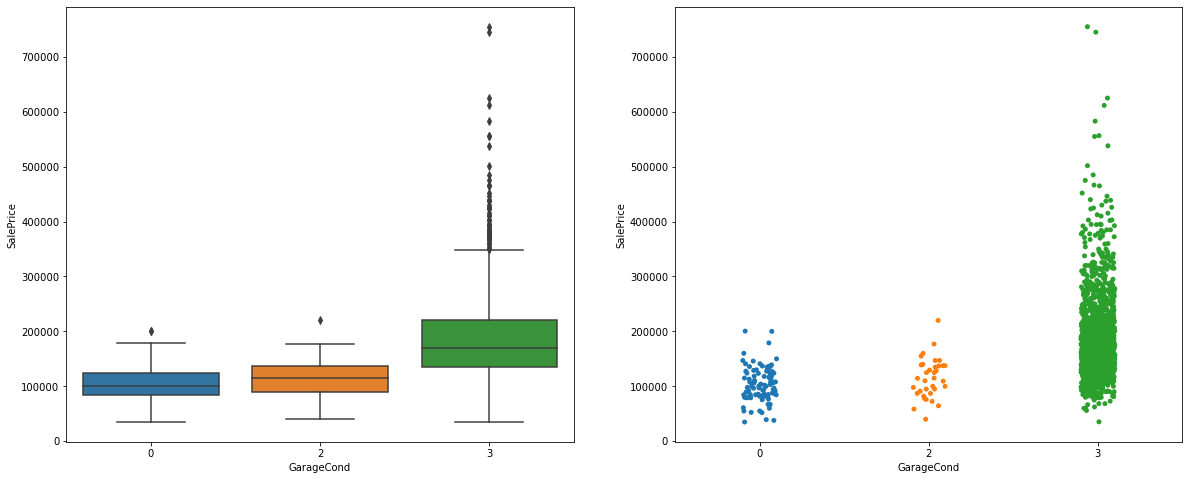

In [555]:
make_discrete_plot('GarageCond',0,0)

In [556]:
# not many difference here between categories, so let's turn into string and later get dummies
dataset.GarageCond = dataset.GarageCond.astype(str)

Type of Paved driveway.

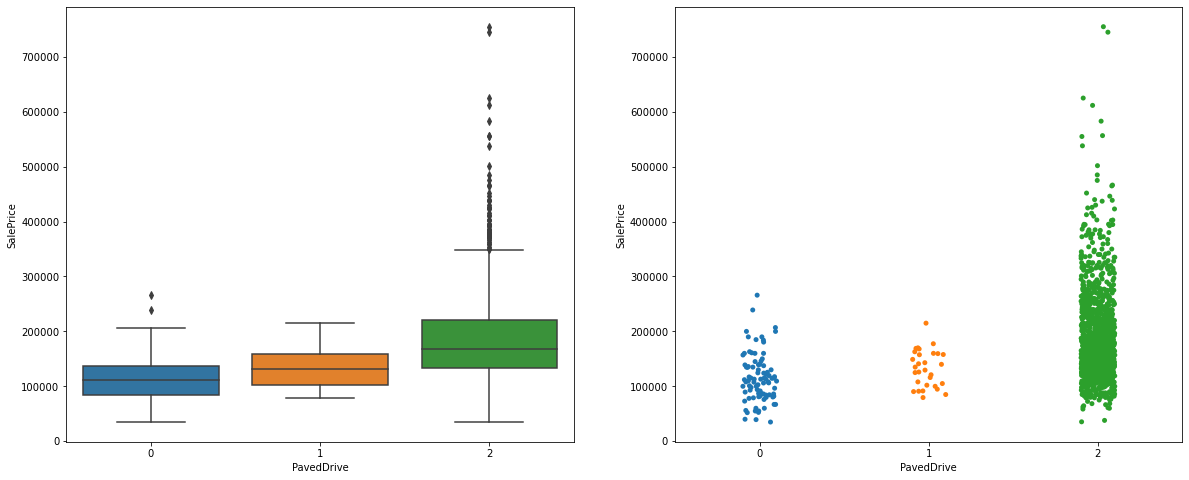

In [557]:
make_discrete_plot('PavedDrive',0,0)

Pool quality.

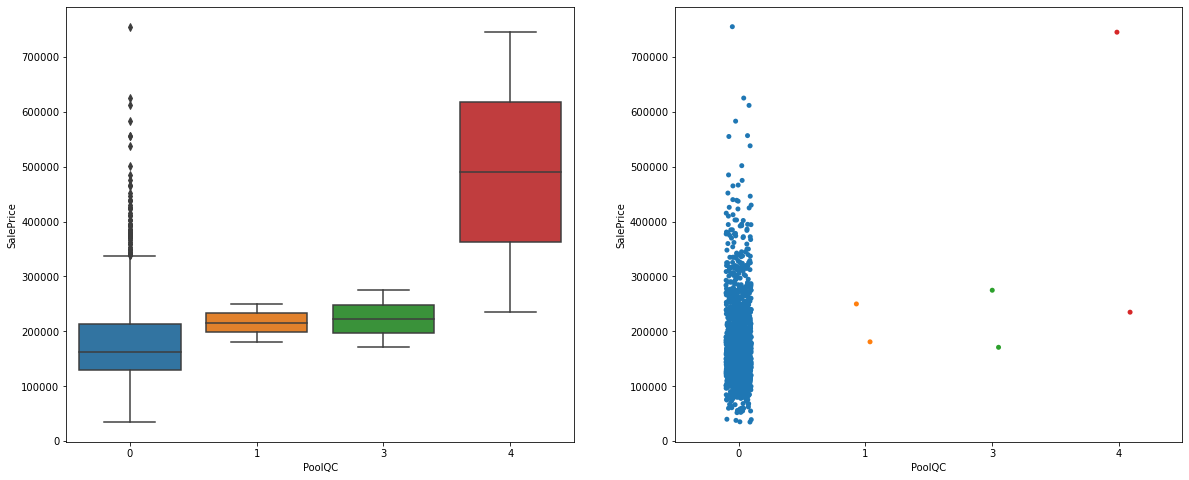

In [558]:
make_discrete_plot('PoolQC',0,0)

In [559]:
# not so many points for values > 0
dataset = dataset.drop(columns='PoolQC')

Fence quality.

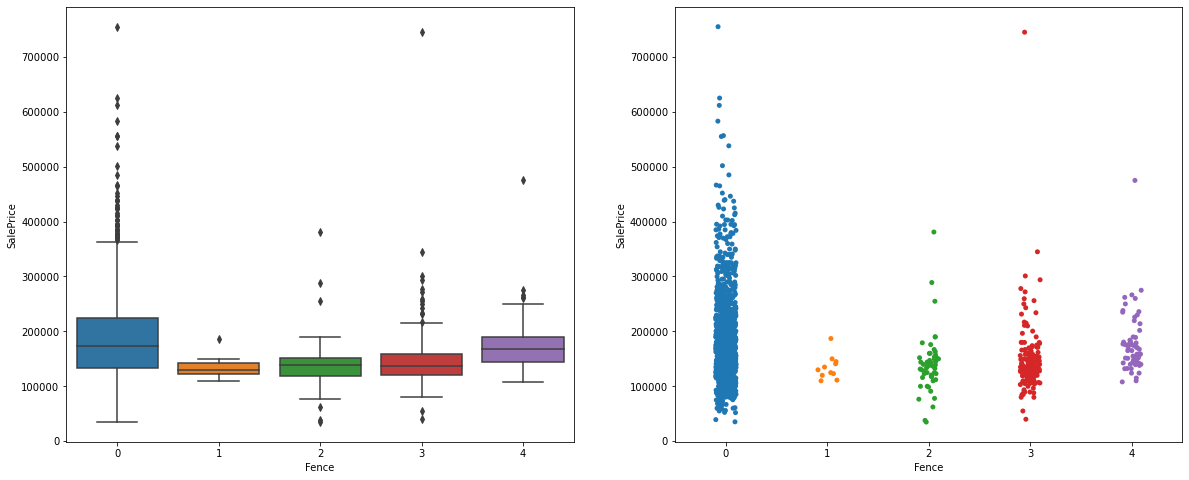

In [560]:
make_discrete_plot('Fence',0,0)

In [561]:
# not many difference here between categories, so let's turn into string and later get dummies
dataset.Fence = dataset.Fence.astype(str)

### Nominal variables

Here we will analyze correlation with the boxplots and missing values. Clustering information when necessary from categories, decisions will be made to drop, flag or keep the column.

In [562]:
# To remember

cat_nominal = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','Foundation','Heating','GarageType','MiscFeature',
               'SaleType','SaleCondition']

The building class.

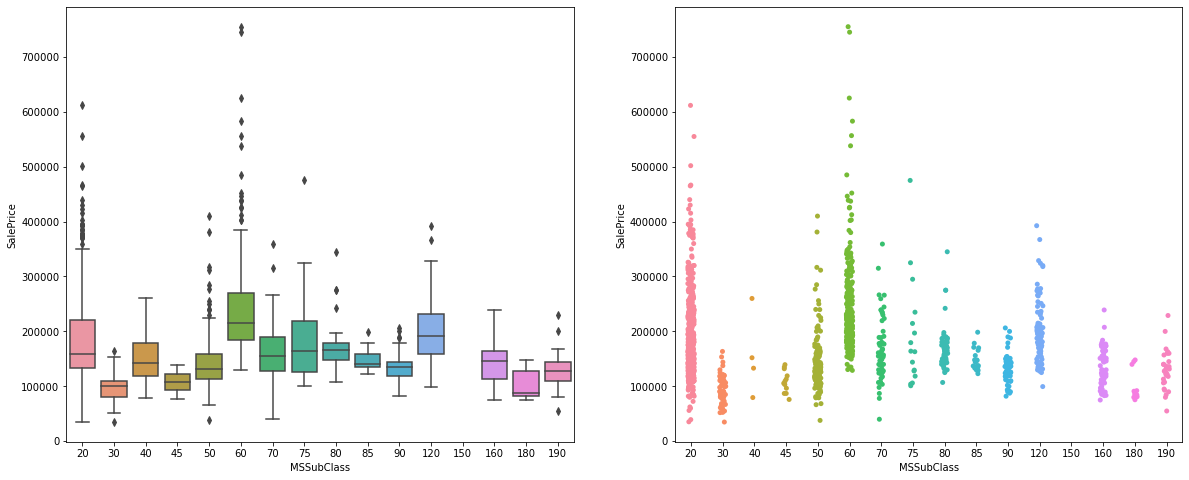

In [563]:
make_discrete_plot('MSSubClass',0,0)

In [564]:
# this variable has integer values, but in fact they need to be categories as strings
dataset.MSSubClass = dataset.MSSubClass.astype(str)

The general zoning classification.

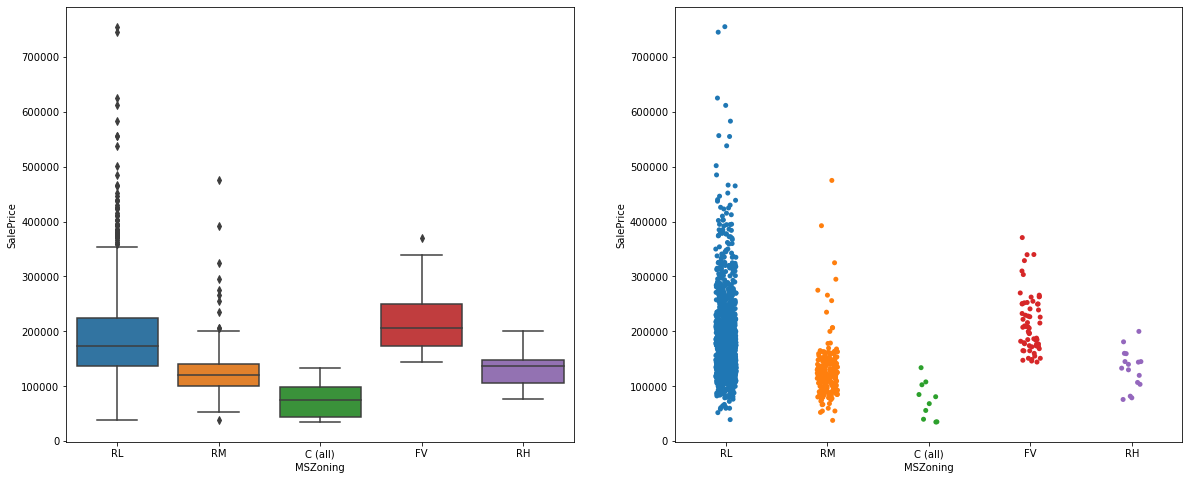

In [565]:
make_discrete_plot('MSZoning',0,0)

Type of road access.

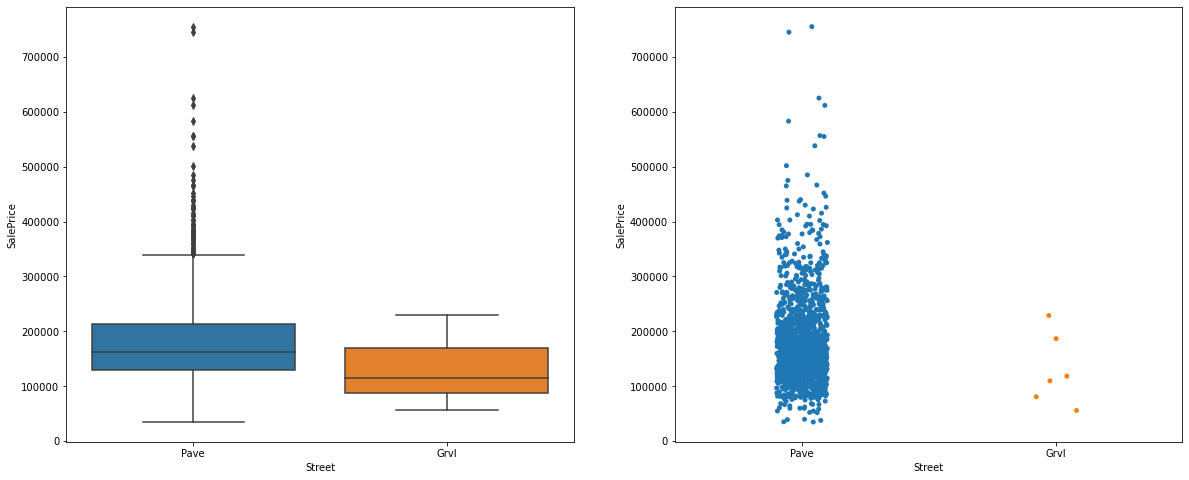

In [566]:
make_discrete_plot('Street',0,0)

In [567]:
# few values for Grvl
dataset = dataset.drop(columns='Street')

Type of alley access

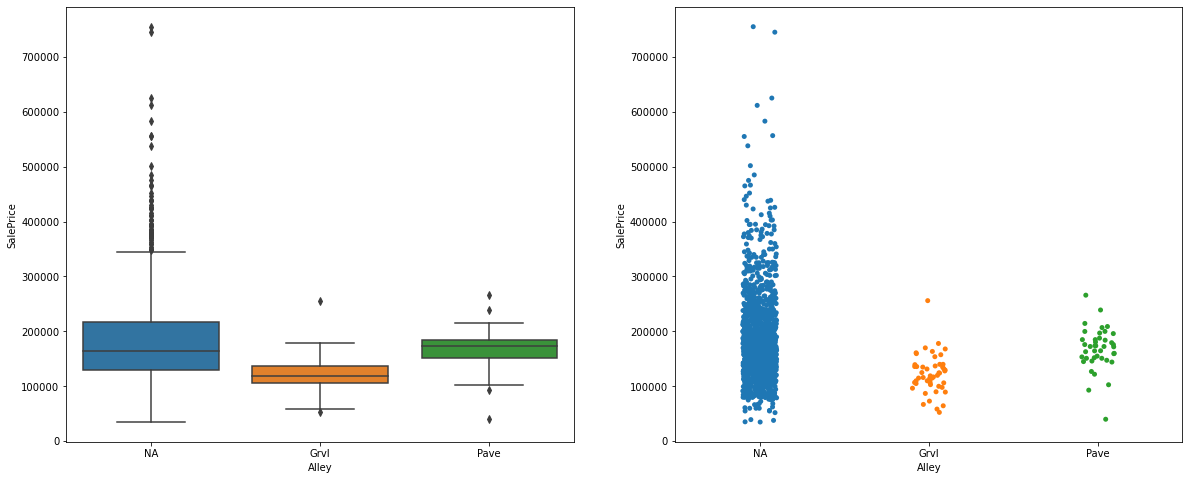

In [568]:
make_discrete_plot('Alley',0,0)

Flatness of the property.

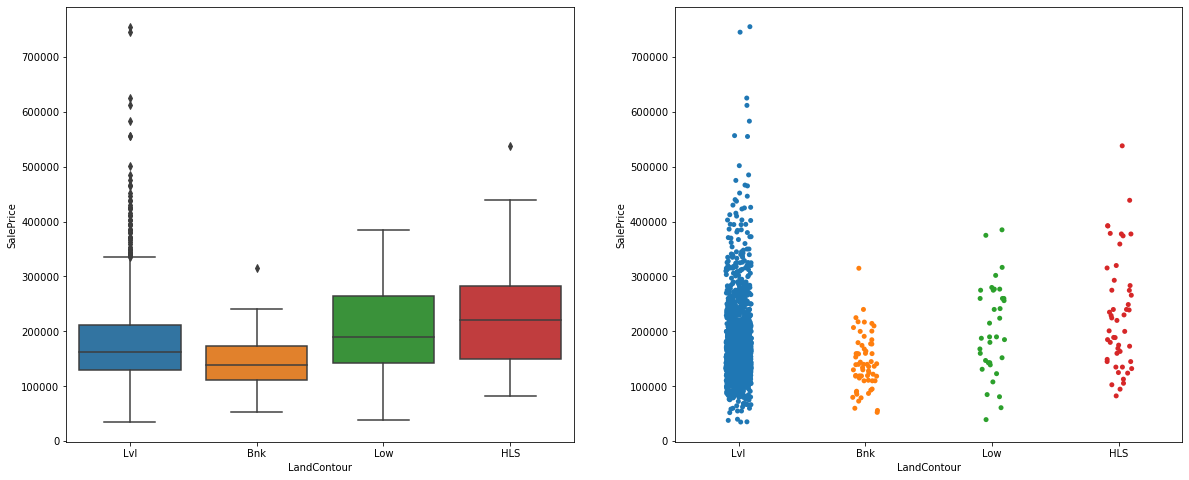

In [569]:
make_discrete_plot('LandContour',0,0)

Lot configuration.

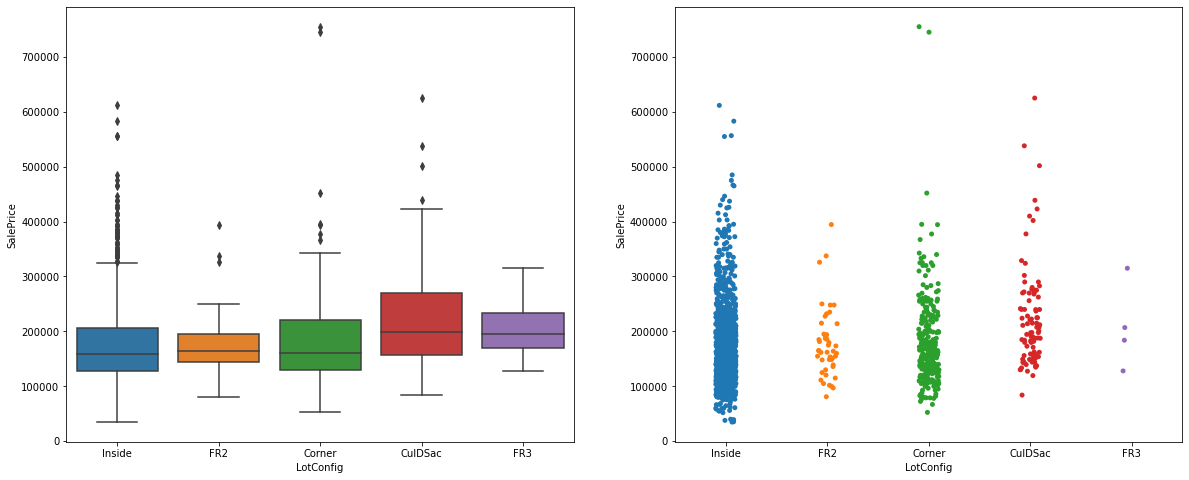

In [570]:
make_discrete_plot('LotConfig',0,0)

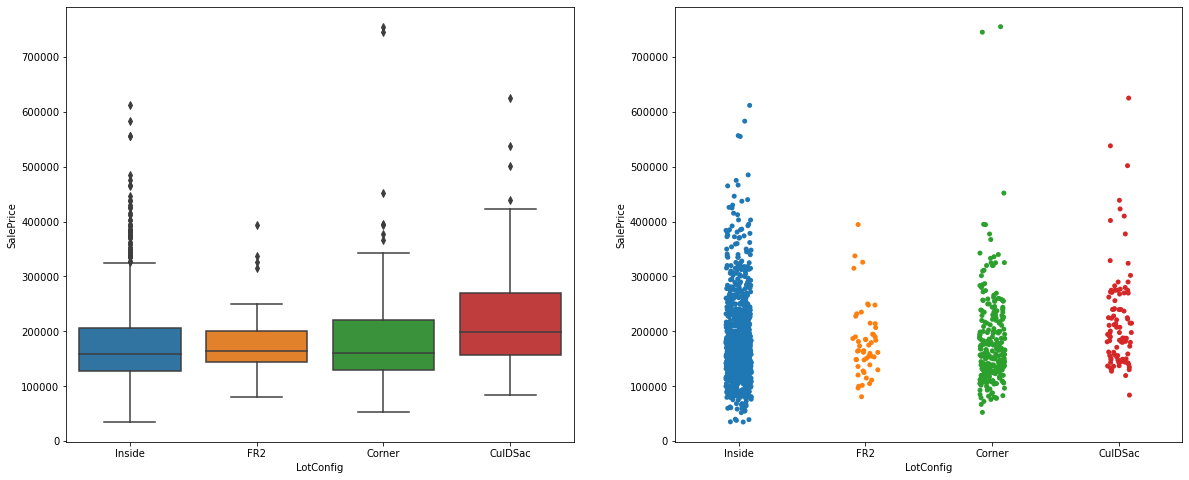

In [571]:
# few values = FR3, so I'll decide to put together with FR2
dataset.LotConfig = dataset.LotConfig.apply(lambda x: 'FR2' if x == 'FR3' else x)
make_discrete_plot('LotConfig',0,0)

Physical locations within Ames city limits.

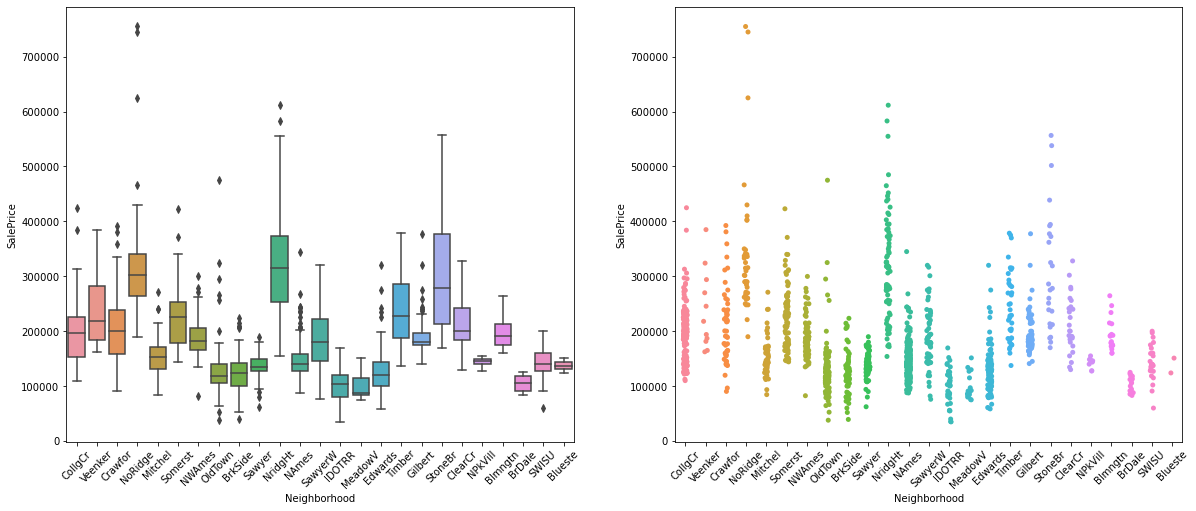

In [572]:
make_discrete_plot('Neighborhood',45,45)

Condition1<br>
Proximity to main road or railroad.

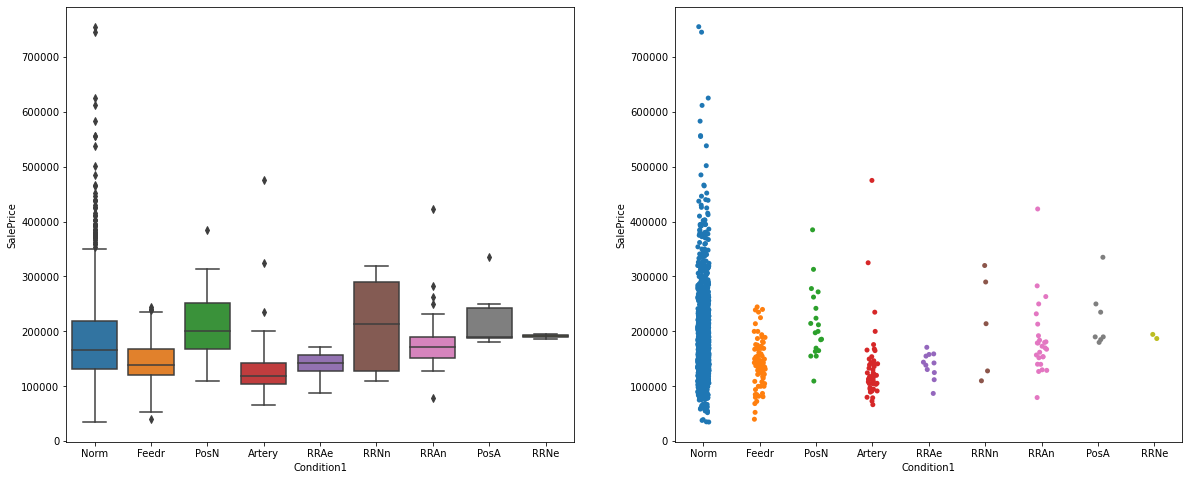

In [573]:
make_discrete_plot('Condition1',0,0)

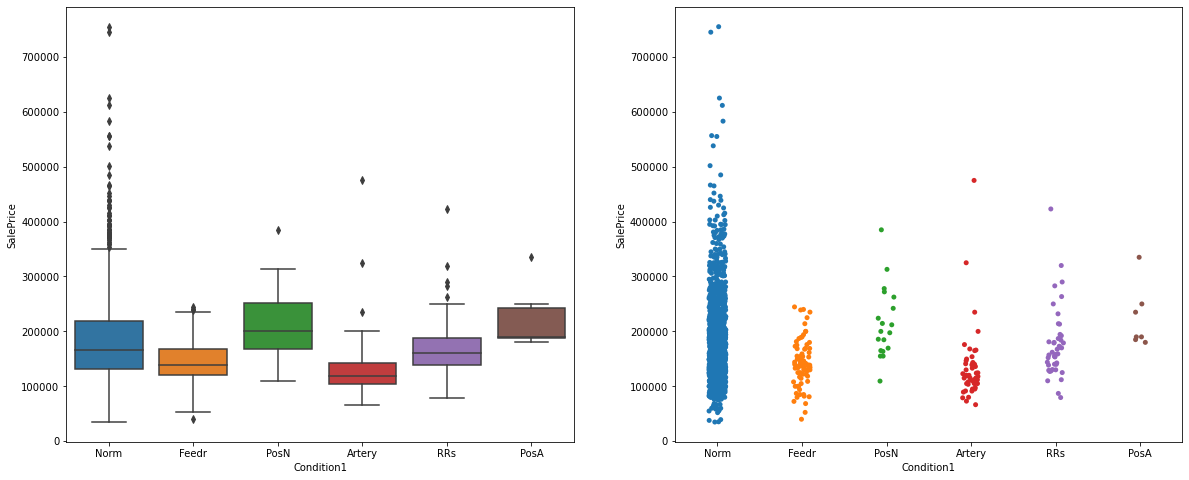

In [574]:
# I'll cluster RRs
dataset.Condition1 = dataset.Condition1.apply(lambda x: 'RRs' if (x == 'RRNe' or x == 'RRAe' or x == 'RRNn' or x == 'RRAn') else x)
make_discrete_plot('Condition1',0,0)

Condition2<br>
Proximity to main road or railroad (if a second is present).

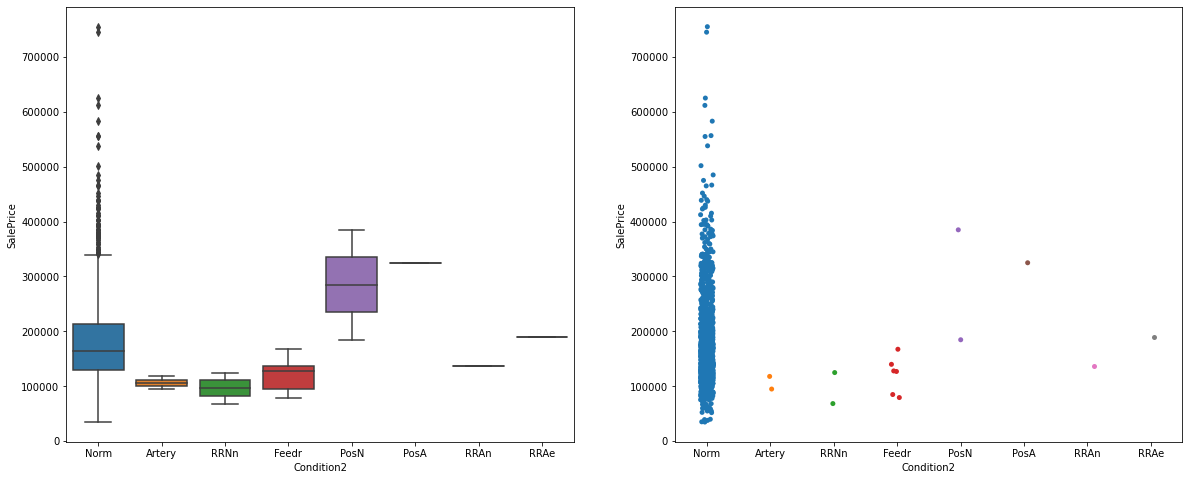

In [575]:
make_discrete_plot('Condition2',0,0)


In [576]:
# most of the values are in Norm
dataset = dataset.drop(columns='Condition2')

Type of dwelling

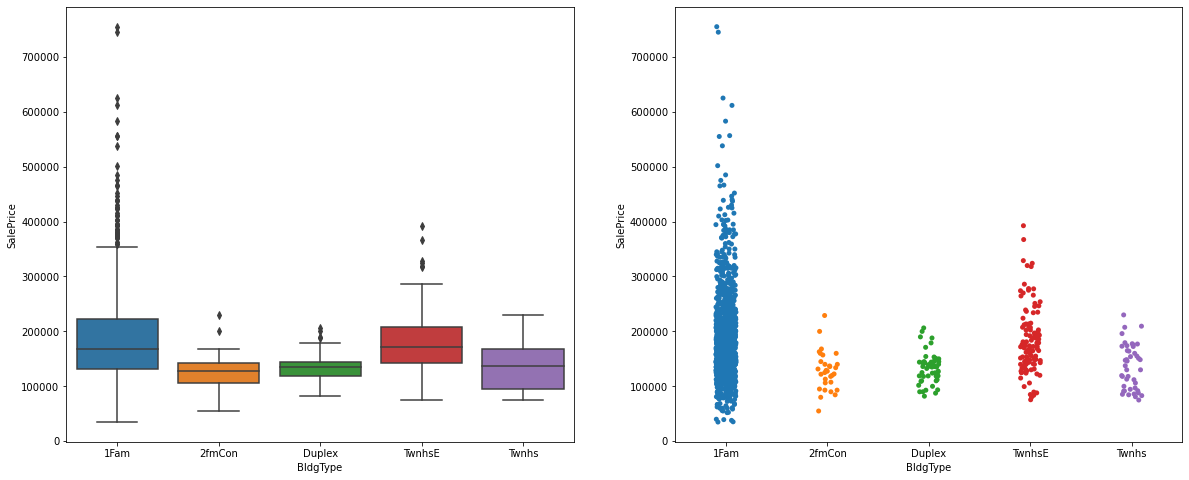

In [577]:
make_discrete_plot('BldgType',0,0)

Style of dwelling.

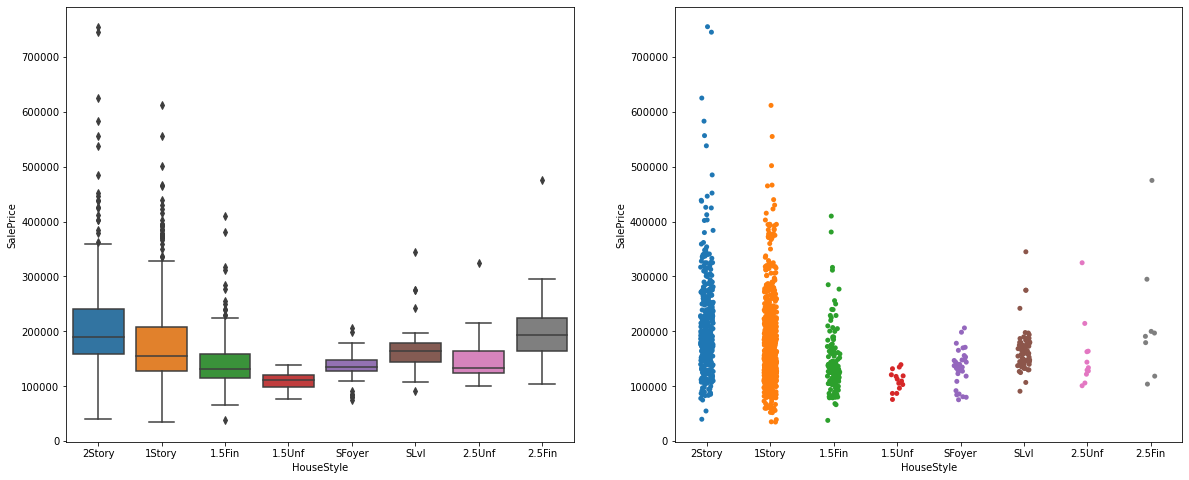

In [578]:
make_discrete_plot('HouseStyle',0,0)

Type of roof.

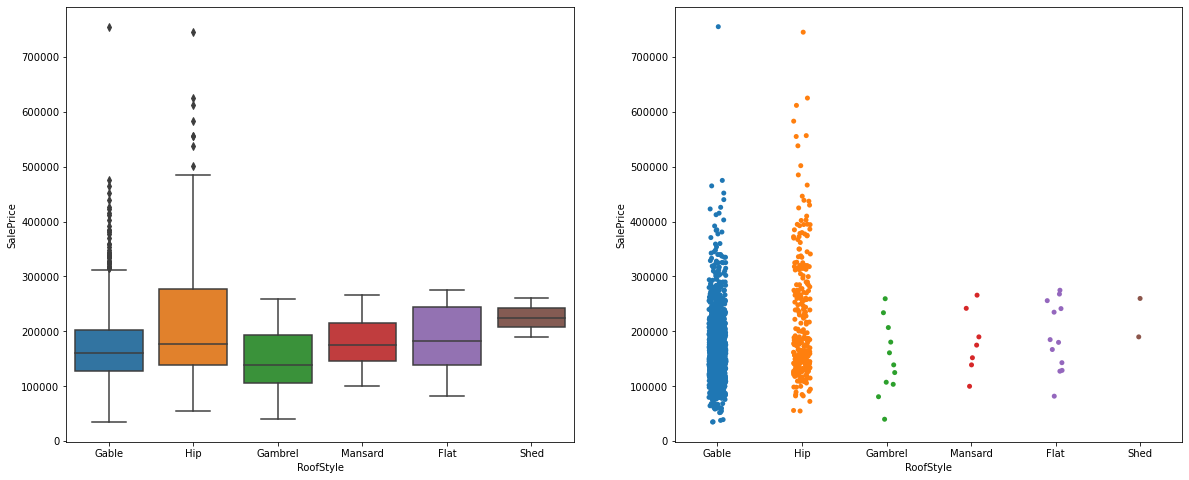

In [579]:
make_discrete_plot('RoofStyle',0,0)

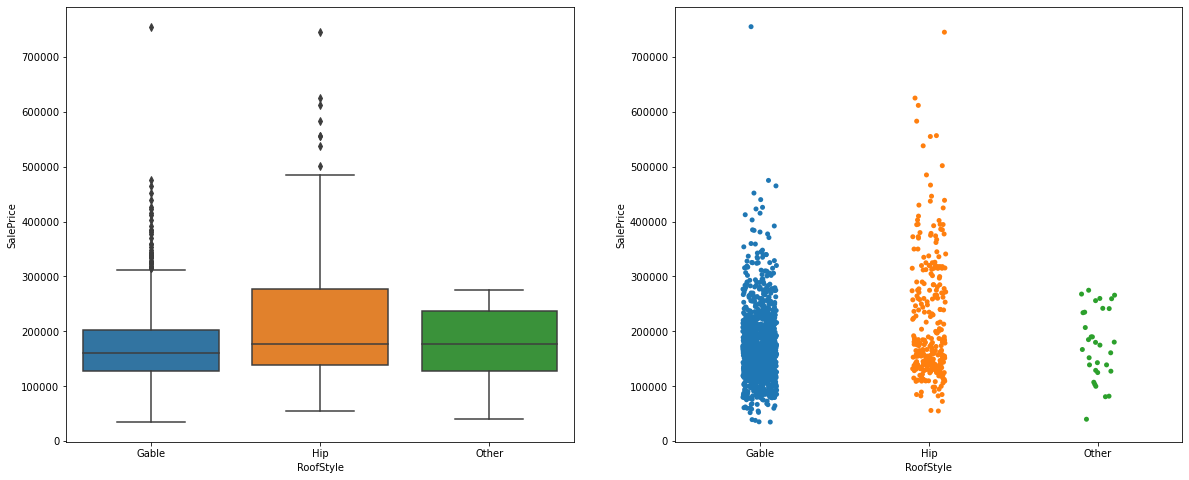

In [580]:
# few values from Gambrel to Shed, so I'll decide to put together = Other
dataset.RoofStyle = dataset.RoofStyle.apply(lambda x: 'Other' if (x == 'Gambrel' or x == 'Mansard' or x == 'Flat' or x == 'Shed') else x)
make_discrete_plot('RoofStyle',0,0)

Roof material.

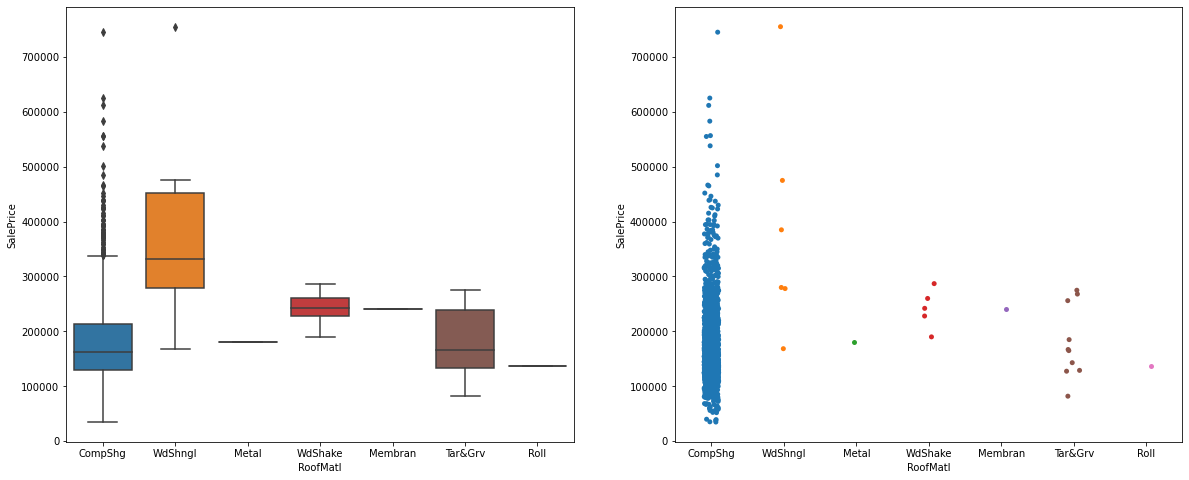

In [581]:
make_discrete_plot('RoofMatl',0,0)

In [582]:
# most of the values are in CompShg, let's drop it
dataset = dataset.drop(columns='RoofMatl')

Exterior covering on house.

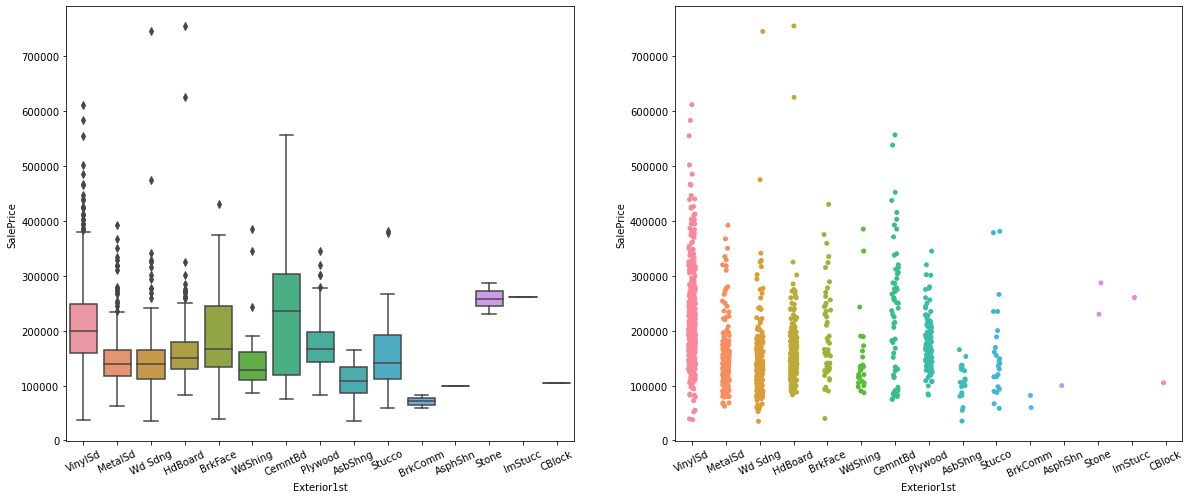

In [583]:
make_discrete_plot('Exterior1st',25,25)

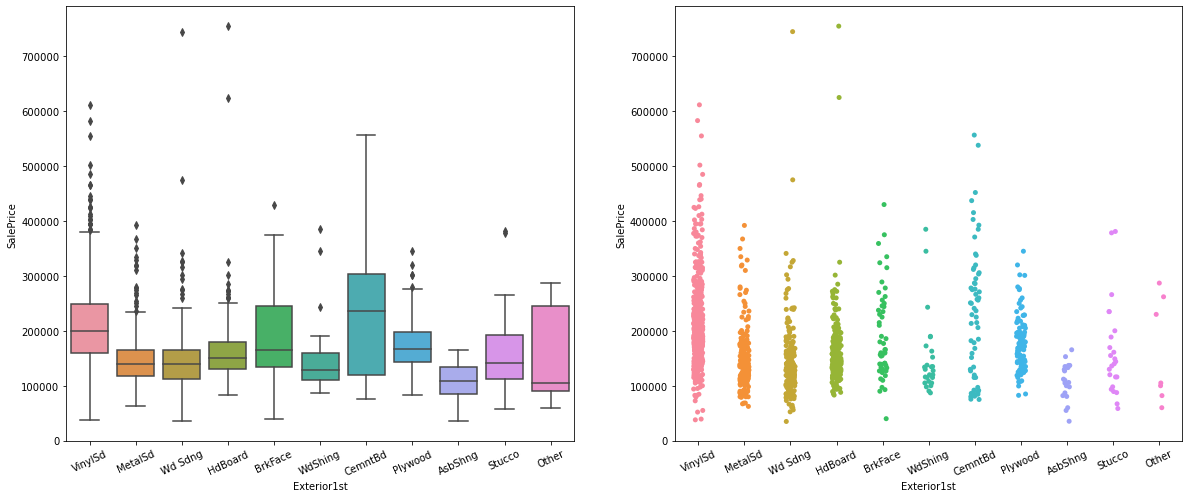

In [584]:
# few values from BrkComm to CBlock, so I'll decide to put together = Other
dataset.Exterior1st = dataset.Exterior1st.apply(lambda x: 'Other' if (x == 'BrkComm' or x == 'AsphShn' or x == 'Stone' or x == 'ImStucc' or x== 'CBlock') else x)
make_discrete_plot('Exterior1st',25,25)

Exterior covering on house (if more than one material).

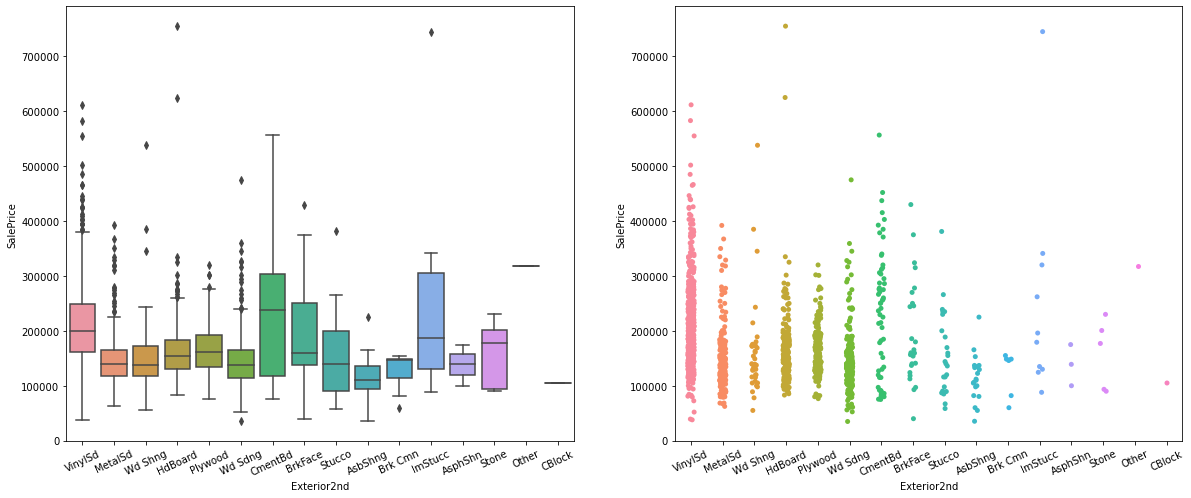

In [585]:
make_discrete_plot('Exterior2nd',25,25)

In [586]:
# similar behavior comparing to Exterior1st
dataset = dataset.drop(columns = 'Exterior2nd')

Masonry veneer type.

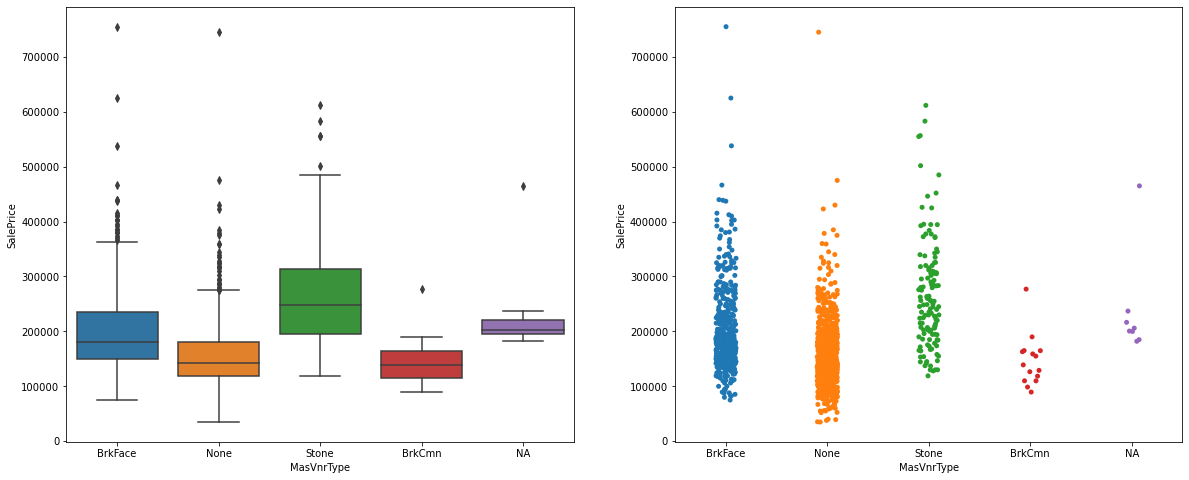

In [587]:
make_discrete_plot('MasVnrType',0,0)

Type of foundation.

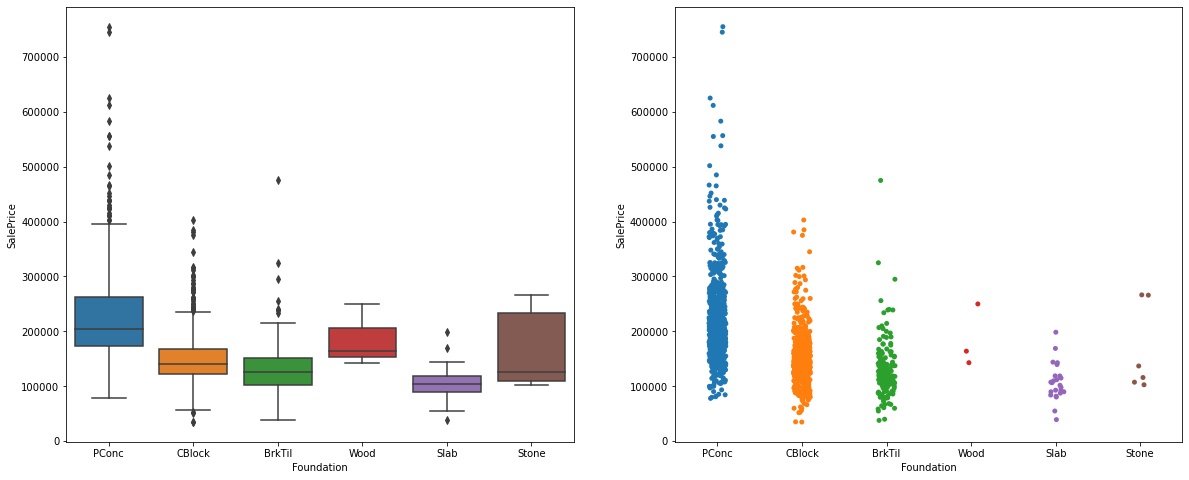

In [588]:
make_discrete_plot('Foundation',0,0)

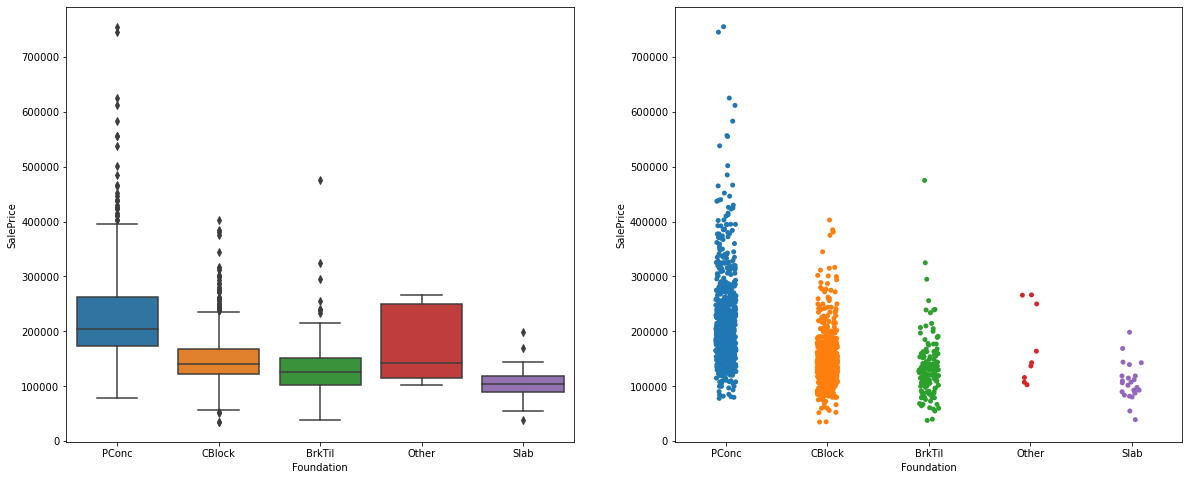

In [589]:
# few values for Wood and Stone, so I'll decide to put together = Other
dataset.Foundation = dataset.Foundation.apply(lambda x: 'Other' if (x == 'Wood' or x == 'Stone') else x)
make_discrete_plot('Foundation',0,0)

Type of heating.

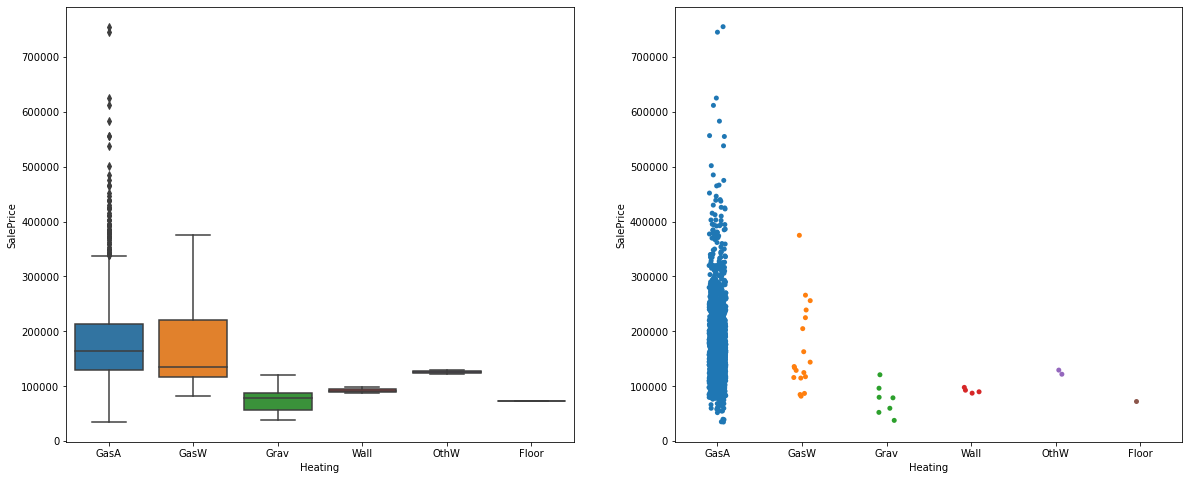

In [590]:
make_discrete_plot('Heating',0,0)

Garage type.

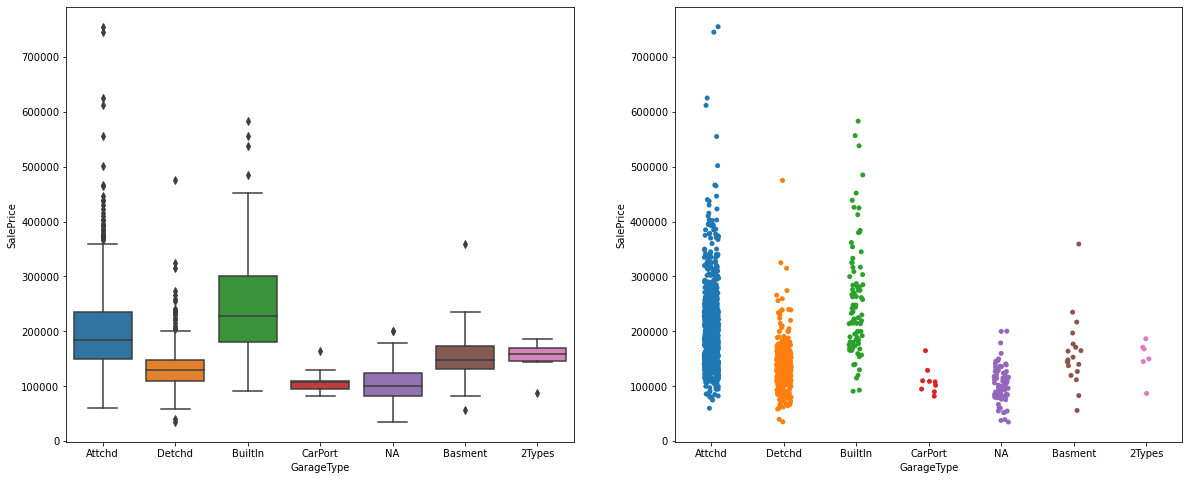

In [591]:
make_discrete_plot('GarageType',0,0)

Miscellaneous feature not covered in other categories.

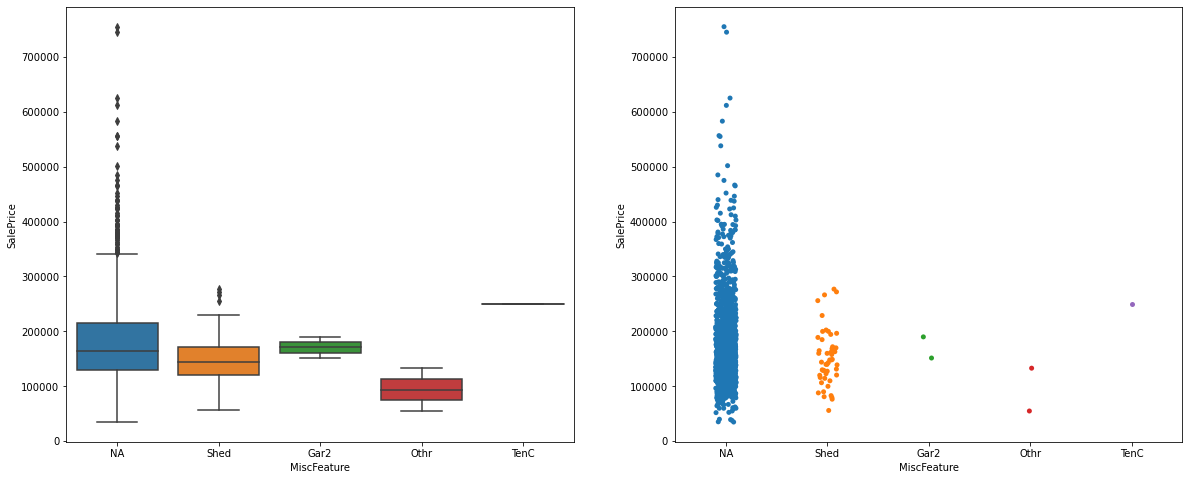

In [592]:
make_discrete_plot('MiscFeature',0,0)

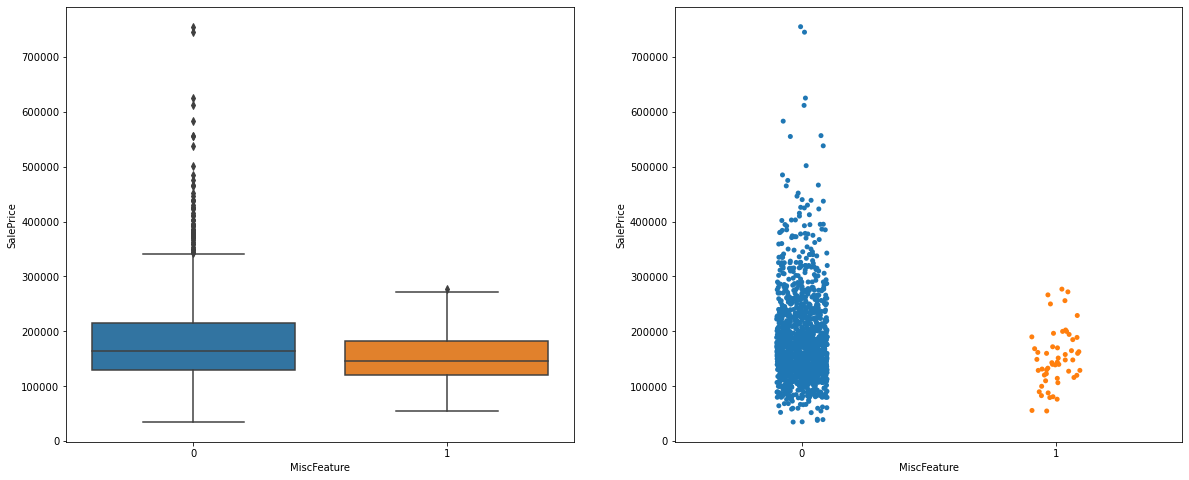

In [593]:
# few values for every category except NA
dataset.MiscFeature = dataset.MiscFeature.apply(lambda x: 0 if x == 'NA' else 1)
make_discrete_plot('MiscFeature',0,0)

Type of sale.

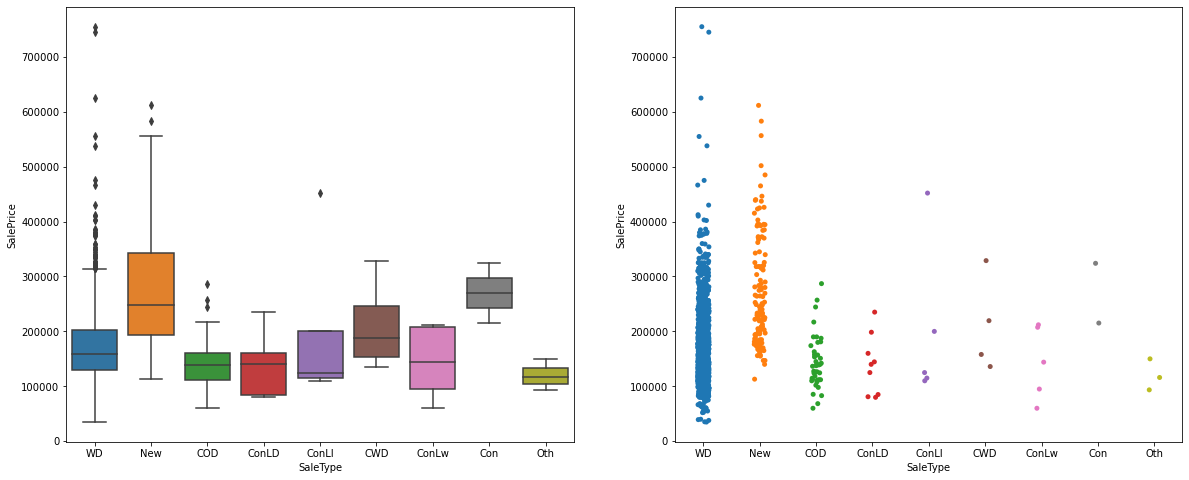

In [594]:
make_discrete_plot('SaleType',0,0)

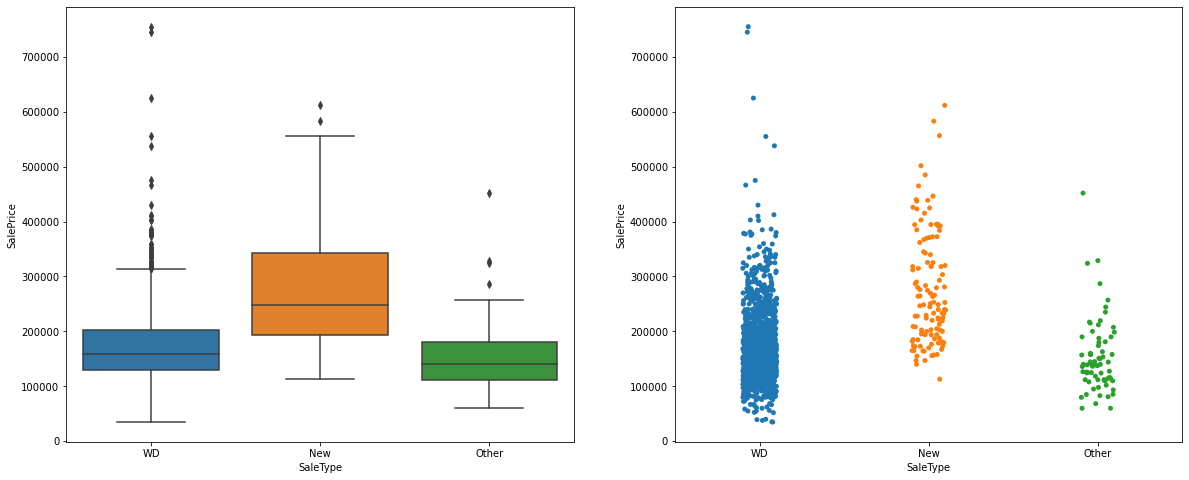

In [595]:
# few values for every category except WD and New
dataset.SaleType = dataset.SaleType.apply(lambda x: x if (x == 'WD' or x == 'New') else 'Other')
make_discrete_plot('SaleType',0,0)

Condition of Sale.

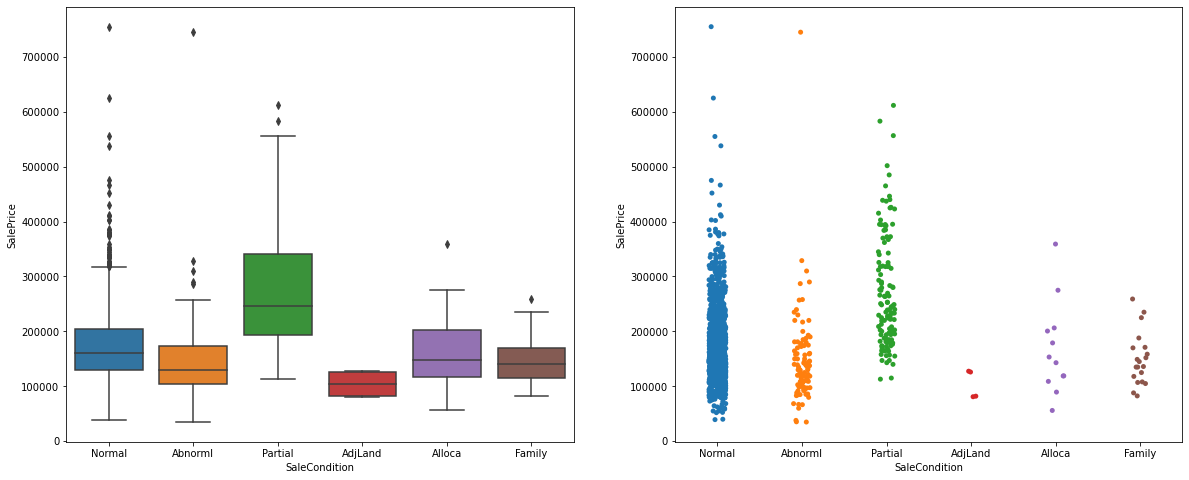

In [596]:
make_discrete_plot('SaleCondition',0,0)

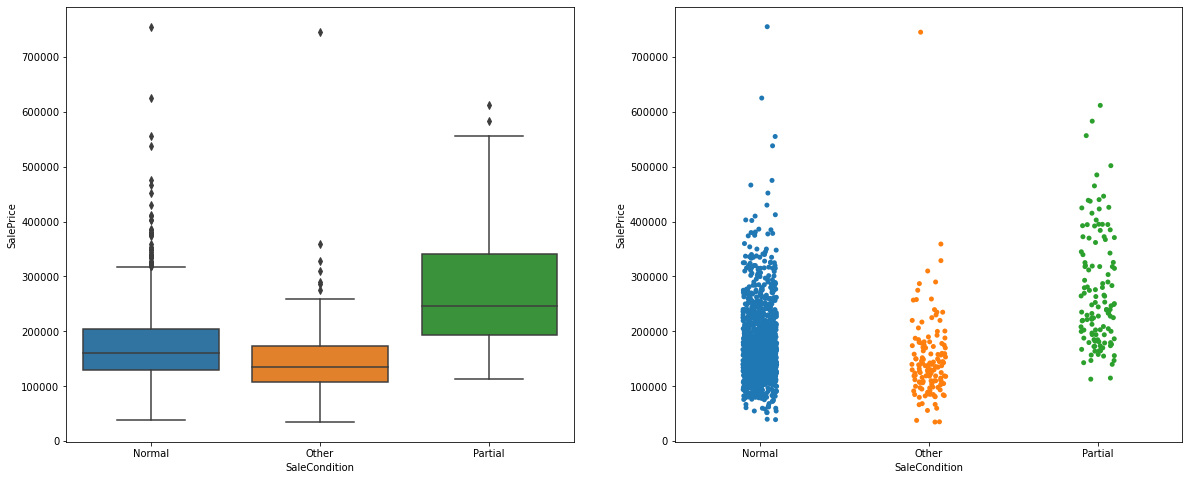

In [597]:
# few values for AdjLand, Alloca and Family
dataset.SaleCondition = dataset.SaleCondition.apply(lambda x: x if (x == 'Normal' or x == 'Abnormal' or x == 'Partial') else 'Other')
make_discrete_plot('SaleCondition',0,0)

## Training the Model

#### Steps:<br>

1. Get dummies/label encoding<br>
2. split the data<br>
3. analyze skwness<br>

4. Training the model using:<br>

    Lasso<br>
    ElasticNet<br>
    Kernel Ridge<br>
    Gradient Boosting Regressor<br>
    XGBoost<br>
    Light Gradient Boosting<br>
    
Note: tuning parameters were obtained from GridSearchCV.

In [598]:
dataset = dataset.reset_index(drop=True)
dataset.shape

(2917, 73)

In [599]:
# splitting data 
X = dataset.loc[:,dataset.columns.difference(['SalePrice', 'Id'])]
Y = dataset.SalePrice

X = pd.get_dummies(X) # getting dummies

Analyzing skewness and replacing column with the best transformation (boxcox with different lambdas, log or keep the column as it is).

In [600]:
skewness = list(abs(stats.skew(X)) > 0.7)
counter = 0
lambdas = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
for i in X.columns:
    if skewness[counter] == True:
        print("Column: ", i)
        idx = np.argmin([abs(stats.skew(boxcox1p(X[i], 0.1))),
                         abs(stats.skew(boxcox1p(X[i], 0.15))),
                         abs(stats.skew(boxcox1p(X[i], 0.2))),
                         abs(stats.skew(boxcox1p(X[i], 0.25))),
                         abs(stats.skew(boxcox1p(X[i], 0.3))),
                         abs(stats.skew(boxcox1p(X[i], 0.35))),
                         abs(stats.skew(boxcox1p(X[i], 0.4))),
                         abs(stats.skew(boxcox1p(X[i], 0.45))),
                         abs(stats.skew(np.log1p(X[i]))),
                         abs(stats.skew(X[i]))])
        if idx < 8:
            X[i] = boxcox1p(X[i], lambdas[idx])
        if idx == 8:
            X[i] = np.log1p(X[i])
    counter = counter + 1

Column:  BsmtCond
Column:  BsmtExposure
Column:  BsmtFinSF2
Column:  BsmtHalfBath
Column:  BsmtQual
Column:  CentralAir
Column:  Electrical
Column:  ExterCond
Column:  ExterQual
Column:  GarageQual
Column:  LandSlope
Column:  LotShape
Column:  LowQualFinSF
Column:  MiscFeature
Column:  OverallCond
Column:  PavedDrive
Column:  PoolArea
Column:  TotalBsmtSF
Column:  2ndFlrSF_1000-1250
Column:  2ndFlrSF_1250-2100
Column:  2ndFlrSF_250-500
Column:  2ndFlrSF_500-750
Column:  2ndFlrSF_750-1000
Column:  Alley_Grvl
Column:  Alley_NA
Column:  Alley_Pave
Column:  BedroomAbvGr_0
Column:  BedroomAbvGr_1
Column:  BedroomAbvGr_2
Column:  BedroomAbvGr_4
Column:  BedroomAbvGr_5
Column:  BldgType_1Fam
Column:  BldgType_2fmCon
Column:  BldgType_Duplex
Column:  BldgType_Twnhs
Column:  BldgType_TwnhsE
Column:  BsmtFinSF1_1000-1250
Column:  BsmtFinSF1_1250-4011
Column:  BsmtFinSF1_250-500
Column:  BsmtFinSF1_500-750
Column:  BsmtFinSF1_750-1000
Column:  BsmtFinType1_0
Column:  BsmtFinType1_1
Column:  BsmtF

Scaling with RobustScaler (better for treating outliers). You can see the types of Scaling in the link below.<br>
http://benalexkeen.com/feature-scaling-with-scikit-learn/


In [601]:
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [602]:
# train and test
X_train = X.iloc[0:1457].values
Y_train = Y.iloc[0:1457].values
X_test = X.iloc[1457:].values
test_ids = dataset.Id.iloc[1457:]

Skewness analysis for target variable.

In [603]:
lambdas = [0.15, 0.25, 0.35, 0.45]
idx = np.argmin([abs(stats.skew(boxcox1p(Y_train, 0.15))),
                 abs(stats.skew(boxcox1p(Y_train, 0.25))),
                 abs(stats.skew(boxcox1p(Y_train, 0.35))),
                 abs(stats.skew(boxcox1p(Y_train, 0.45))),
                 abs(stats.skew(np.log1p(Y_train)))])
if idx < 4:
    Y_train = boxcox1p(Y_train, lambdas[idx])
if idx == 4:
            Y_train = np.log1p(Y_train)

In [604]:
idx

4

### Lasso

In [605]:
lasso = Lasso(alpha= 0.0005) # alpha obtained from GridSearchCv

### ElasticNet

In [606]:
elastic = ElasticNet(alpha=0.0005, l1_ratio=.9)  # parameters were obtained with GridSearchCV

### Kernel Ridge

GridSearch for Ridge.

In [607]:
"""

k_ridge = KernelRidge()

param_grid = {'alpha': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'kernel':['polynomial'], 
              'degree':[2,3,4,5,6,7,8],
              'coef0':[0,1,1.5,2,2.5,3,3.5,10]}

k = GridSearchCV(k_ridge, 
                 param_grid = param_grid, 
                 cv = 10, 
                 scoring = "neg_mean_squared_error", 
                 n_jobs = -1, 
                 verbose = 1)

k.fit(X_train,Y_train)

k_best = k.best_estimator_

k.best_score_

"""

'\n\nk_ridge = KernelRidge()\n\nparam_grid = {\'alpha\': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],\n              \'kernel\':[\'polynomial\'], \n              \'degree\':[2,3,4,5,6,7,8],\n              \'coef0\':[0,1,1.5,2,2.5,3,3.5,10]}\n\nk = GridSearchCV(k_ridge, \n                 param_grid = param_grid, \n                 cv = 10, \n                 scoring = "neg_mean_squared_error", \n                 n_jobs = -1, \n                 verbose = 1)\n\nk.fit(X_train,Y_train)\n\nk_best = k.best_estimator_\n\nk.best_score_\n\n'

In [608]:
k_ridge = KernelRidge(alpha=0.1, coef0=2.5, degree=3, gamma=None, kernel='polynomial',kernel_params=None)

GridSearch for GBR.

In [609]:
"""

GBMR = GradientBoostingRegressor()

GBMR_param_grid = {'loss': ['huber'],
                   'n_estimators':[3000,3300], 
                   'learning_rate':[0.01],
                   'max_depth':[3,5], 
                   'max_features':[18,20],
                   'min_samples_leaf':[2,3], 
                   'min_samples_split':[3,5]}

gsGBMR = GridSearchCV(GBMR, 
                      param_grid = GBMR_param_grid, 
                      cv = 5, 
                      scoring = "neg_mean_squared_error", 
                      n_jobs = -1, 
                      verbose = 1)

gsGBMR.fit(X_train,Y_train)

GBMR_best = gsGBMR.best_estimator_

gsGBMR.best_score_

"""

'\n\nGBMR = GradientBoostingRegressor()\n\nGBMR_param_grid = {\'loss\': [\'huber\'],\n                   \'n_estimators\':[3000,3300], \n                   \'learning_rate\':[0.01],\n                   \'max_depth\':[3,5], \n                   \'max_features\':[18,20],\n                   \'min_samples_leaf\':[2,3], \n                   \'min_samples_split\':[3,5]}\n\ngsGBMR = GridSearchCV(GBMR, \n                      param_grid = GBMR_param_grid, \n                      cv = 5, \n                      scoring = "neg_mean_squared_error", \n                      n_jobs = -1, \n                      verbose = 1)\n\ngsGBMR.fit(X_train,Y_train)\n\nGBMR_best = gsGBMR.best_estimator_\n\ngsGBMR.best_score_\n\n'

In [610]:
g_boost = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=3, max_features=18, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=3, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=3300,
                          n_iter_no_change=None,random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### XGBoost

GridSearch for XGBoost.

In [611]:
"""

XGBMR = XGBRegressor()

XGBMR_param_grid = {'learning_rate': [0.001,0.01,0.1], 
                  'max_depth': [3,4,7],
                  'n_estimators': [3300,4000], 
                  'gamma': [0],
                  'subsample': [0.3,0.5,0.8]}

gsXGBMR = GridSearchCV(XGBMR, 
                      param_grid = XGBMR_param_grid, 
                      cv = 5, 
                      scoring = "neg_mean_squared_error", 
                      n_jobs = -1, 
                      verbose = 1)

gsXGBMR.fit(X_train,Y_train)

XGBMR_best = gsXGBMR.best_estimator_

gsXGBMR.best_score_

"""

'\n\nXGBMR = XGBRegressor()\n\nXGBMR_param_grid = {\'learning_rate\': [0.001,0.01,0.1], \n                  \'max_depth\': [3,4,7],\n                  \'n_estimators\': [3300,4000], \n                  \'gamma\': [0],\n                  \'subsample\': [0.3,0.5,0.8]}\n\ngsXGBMR = GridSearchCV(XGBMR, \n                      param_grid = XGBMR_param_grid, \n                      cv = 5, \n                      scoring = "neg_mean_squared_error", \n                      n_jobs = -1, \n                      verbose = 1)\n\ngsXGBMR.fit(X_train,Y_train)\n\nXGBMR_best = gsXGBMR.best_estimator_\n\ngsXGBMR.best_score_\n\n'

In [612]:
xg_boost = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=3300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.3, verbosity=1)

GridSearch for Light GBM.

In [613]:
'''

LGBMR = LGBMRegressor()

LGBMR_param_grid = {'objective':['regression','dart','goss','rf'],
                    'num_leaves':[7],
                    'learning_rate':[0.01], 
                    'n_estimators': [3300],
                    'max_depth':[4], 
                    'max_bin': [65],
                    'bagging_fraction':[0.6],
                    'bagging_freq':[9], 
                    'feature_fraction':[0.1],
                    'feature_fraction_seed':[1],
                    'bagging_seed':[14],
                    'min_data_in_leaf':[5], 
                    'min_sum_hessian_in_leaf':[5],
                    'colsample_bytree':[0],
                    'reg_alpha':[0.2],
                    'reg_lambda':[0.1]}

gsLGBMR = GridSearchCV(LGBMR, 
                      param_grid = LGBMR_param_grid, 
                      cv = 10, 
                      scoring = "neg_mean_squared_error", 
                      n_jobs = -1, 
                      verbose = 1)

gsLGBMR.fit(X_train,Y_train)

LGBMR_best = gsLGBMR.best_estimator_

gsLGBMR.best_score_

'''


'\n\nLGBMR = LGBMRegressor()\n\nLGBMR_param_grid = {\'objective\':[\'regression\',\'dart\',\'goss\',\'rf\'],\n                    \'num_leaves\':[7],\n                    \'learning_rate\':[0.01], \n                    \'n_estimators\': [3300],\n                    \'max_depth\':[4], \n                    \'max_bin\': [65],\n                    \'bagging_fraction\':[0.6],\n                    \'bagging_freq\':[9], \n                    \'feature_fraction\':[0.1],\n                    \'feature_fraction_seed\':[1],\n                    \'bagging_seed\':[14],\n                    \'min_data_in_leaf\':[5], \n                    \'min_sum_hessian_in_leaf\':[5],\n                    \'colsample_bytree\':[0],\n                    \'reg_alpha\':[0.2],\n                    \'reg_lambda\':[0.1]}\n\ngsLGBMR = GridSearchCV(LGBMR, \n                      param_grid = LGBMR_param_grid, \n                      cv = 10, \n                      scoring = "neg_mean_squared_error", \n                   

In [614]:
lgbm = LGBMRegressor(bagging_fraction=0.6, bagging_freq=9, bagging_seed=14,
              boosting_type='gbdt', class_weight=None, colsample_bytree=0,
              feature_fraction=0.1, feature_fraction_seed=1,
              importance_type='split', learning_rate=0.01, max_bin=65,
              max_depth=4, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=5, min_split_gain=0.0, min_sum_hessian_in_leaf=5,
              n_estimators=3300, n_jobs=-1, num_leaves=7,
              objective='regression', random_state=None, reg_alpha=0.2,
              reg_lambda=0.1, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

## Stacking

Let us choose some models to be regressors and lasso to be the meta regressor. Lasso seems to be a good model for this competition, thats why it will be the meta.

In [615]:
stacking = StackingRegressor(regressors=(elastic, g_boost, k_ridge),
                             meta_regressor = lasso)

param_grid = {} 

stack = GridSearchCV(stacking, 
                   param_grid = param_grid,
                   cv = 10, 
                   scoring = "neg_mean_squared_error",
                   n_jobs = 5, 
                   verbose = 1)

stack.fit(X_train,Y_train)

s_best = stack.best_estimator_

stack.best_score_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


-0.014301342601693929

In [616]:
stacking = s_best

## Voting

A voting regressor is an ensemble meta-estimator that fits base regressors each on the whole dataset. It, then, averages the individual predictions to form a final prediction.

In [ ]:
voting = VotingRegressor(estimators=[('xgboost', xg_boost), 
                                     ('lgbm', lgbm),
                                     ('stacking', stacking)])

v_param_grid = {} # tuning voting parameter

gsV = GridSearchCV(voting, 
                   param_grid = v_param_grid,
                   cv = 10, 
                   scoring = "neg_mean_squared_error",
                   n_jobs = 5, 
                   verbose = 1)

gsV.fit(X_train,Y_train)

v_best = gsV.best_estimator_



In [620]:
voting = v_best

In [ ]:
# Voting
y_vote = np.expm1(voting.predict(X_test))

# Lasso
lasso.fit(X_train,Y_train)
y_lasso = np.expm1(lasso.predict(X_test))


y_pred =(0.6*y_vote + 0.4*y_lasso)
submission = pd.DataFrame(test_ids.values, columns = ["Id"])
submission['SalePrice'] = list(y_pred)
submission.to_csv('submission.csv',index=False)